In [1]:
# from functools import partial
from pathlib import Path
# from typing import Optional, Tuple
# import cv2
# import fire
import numpy as np
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from PIL import Image
from scipy.sparse.linalg import eigsh
# from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
# from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
import extract_utils as utils
from torch.utils.data import Dataset, DataLoader
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from torch import nn
import torchvision
from scipy.ndimage import affine_transform
from matplotlib import pyplot as plt

## Extract Eigen Vectors

In [2]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/images"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16"
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64pred_dssubmax_10_histogram"
which_matrix= 'laplacian'
which_color_matrix= 'knn'
which_features= 'k'
normalize=True
threshold_at_zero=True
lapnorm= True
K= 5
image_downsample_factor = None
image_color_lambda = 0.0
multiprocessing = 0
batch_size=2
epochs=10

## Incorporating SimSiam with PCA projector and a predictor

In [3]:
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
for inp in tqdm(inputs[:1]):
    index, features_file = inp
    print(index, features_file)
     # Load
    data_dict = torch.load(features_file, map_location='cpu')
    # print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
    # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
    image_id = data_dict['file'][:-4]
    print(image_id)
    # Load
    output_file = str(Path(output_dir) / f'{image_id}.pth')
    if Path(output_file).is_file():
        print(f'Skipping existing file {str(output_file)}')
        # break
        # return  # skip because already generated

    # Load affinity matrix
    feats = data_dict[which_features].squeeze().cuda()
    print(feats.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

0 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0001.pth
0001


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

torch.Size([400, 384])


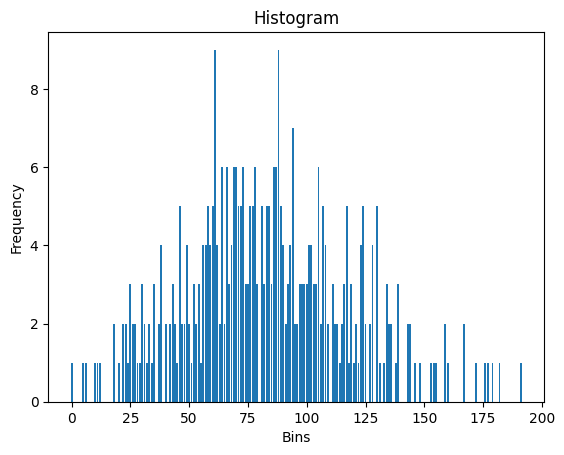

In [13]:
# # Compute the histogram
#
# hist = torch.histc(feats.cpu()[:1], bins=192)
# # Plot the histogram
# plt.bar(range(len(hist)), hist)
# plt.xlabel('Bins')
# plt.ylabel('Frequency')
# plt.title('Histogram')
# plt.show()

In [5]:
# tanh_feats=torch.tanh(feats)
# hist = torch.histc(tanh_feats.cpu()[i+j,:], bins=20)
# print(range(len(hist)))
#
# print(torch.tanh())
# print(torch.max(feats[0]))   ## print(feats[0])
# print(torch.min(feats[0]))    #-1.1075,
# # print(feats[0])
# print(torch.max(tanh_feats[0]))   # print(tanh_feats[0])
# print(torch.min(tanh_feats[0]))   ##-0.8032
# # print(tanh_feats[0])
# hist = torch.histc(tanh_feats.cpu()[0,:], bins=20, min=-1, max=1)
# print(type(hist))
# print(hist.shape)
# print(hist)
#
# torch.histc(torch.tensor([1., 2, 1]), bins=4, min=0, max=3)
# x=np.linspace(-1, 1, 20)
# print(x)

400
torch.Size([400, 384])


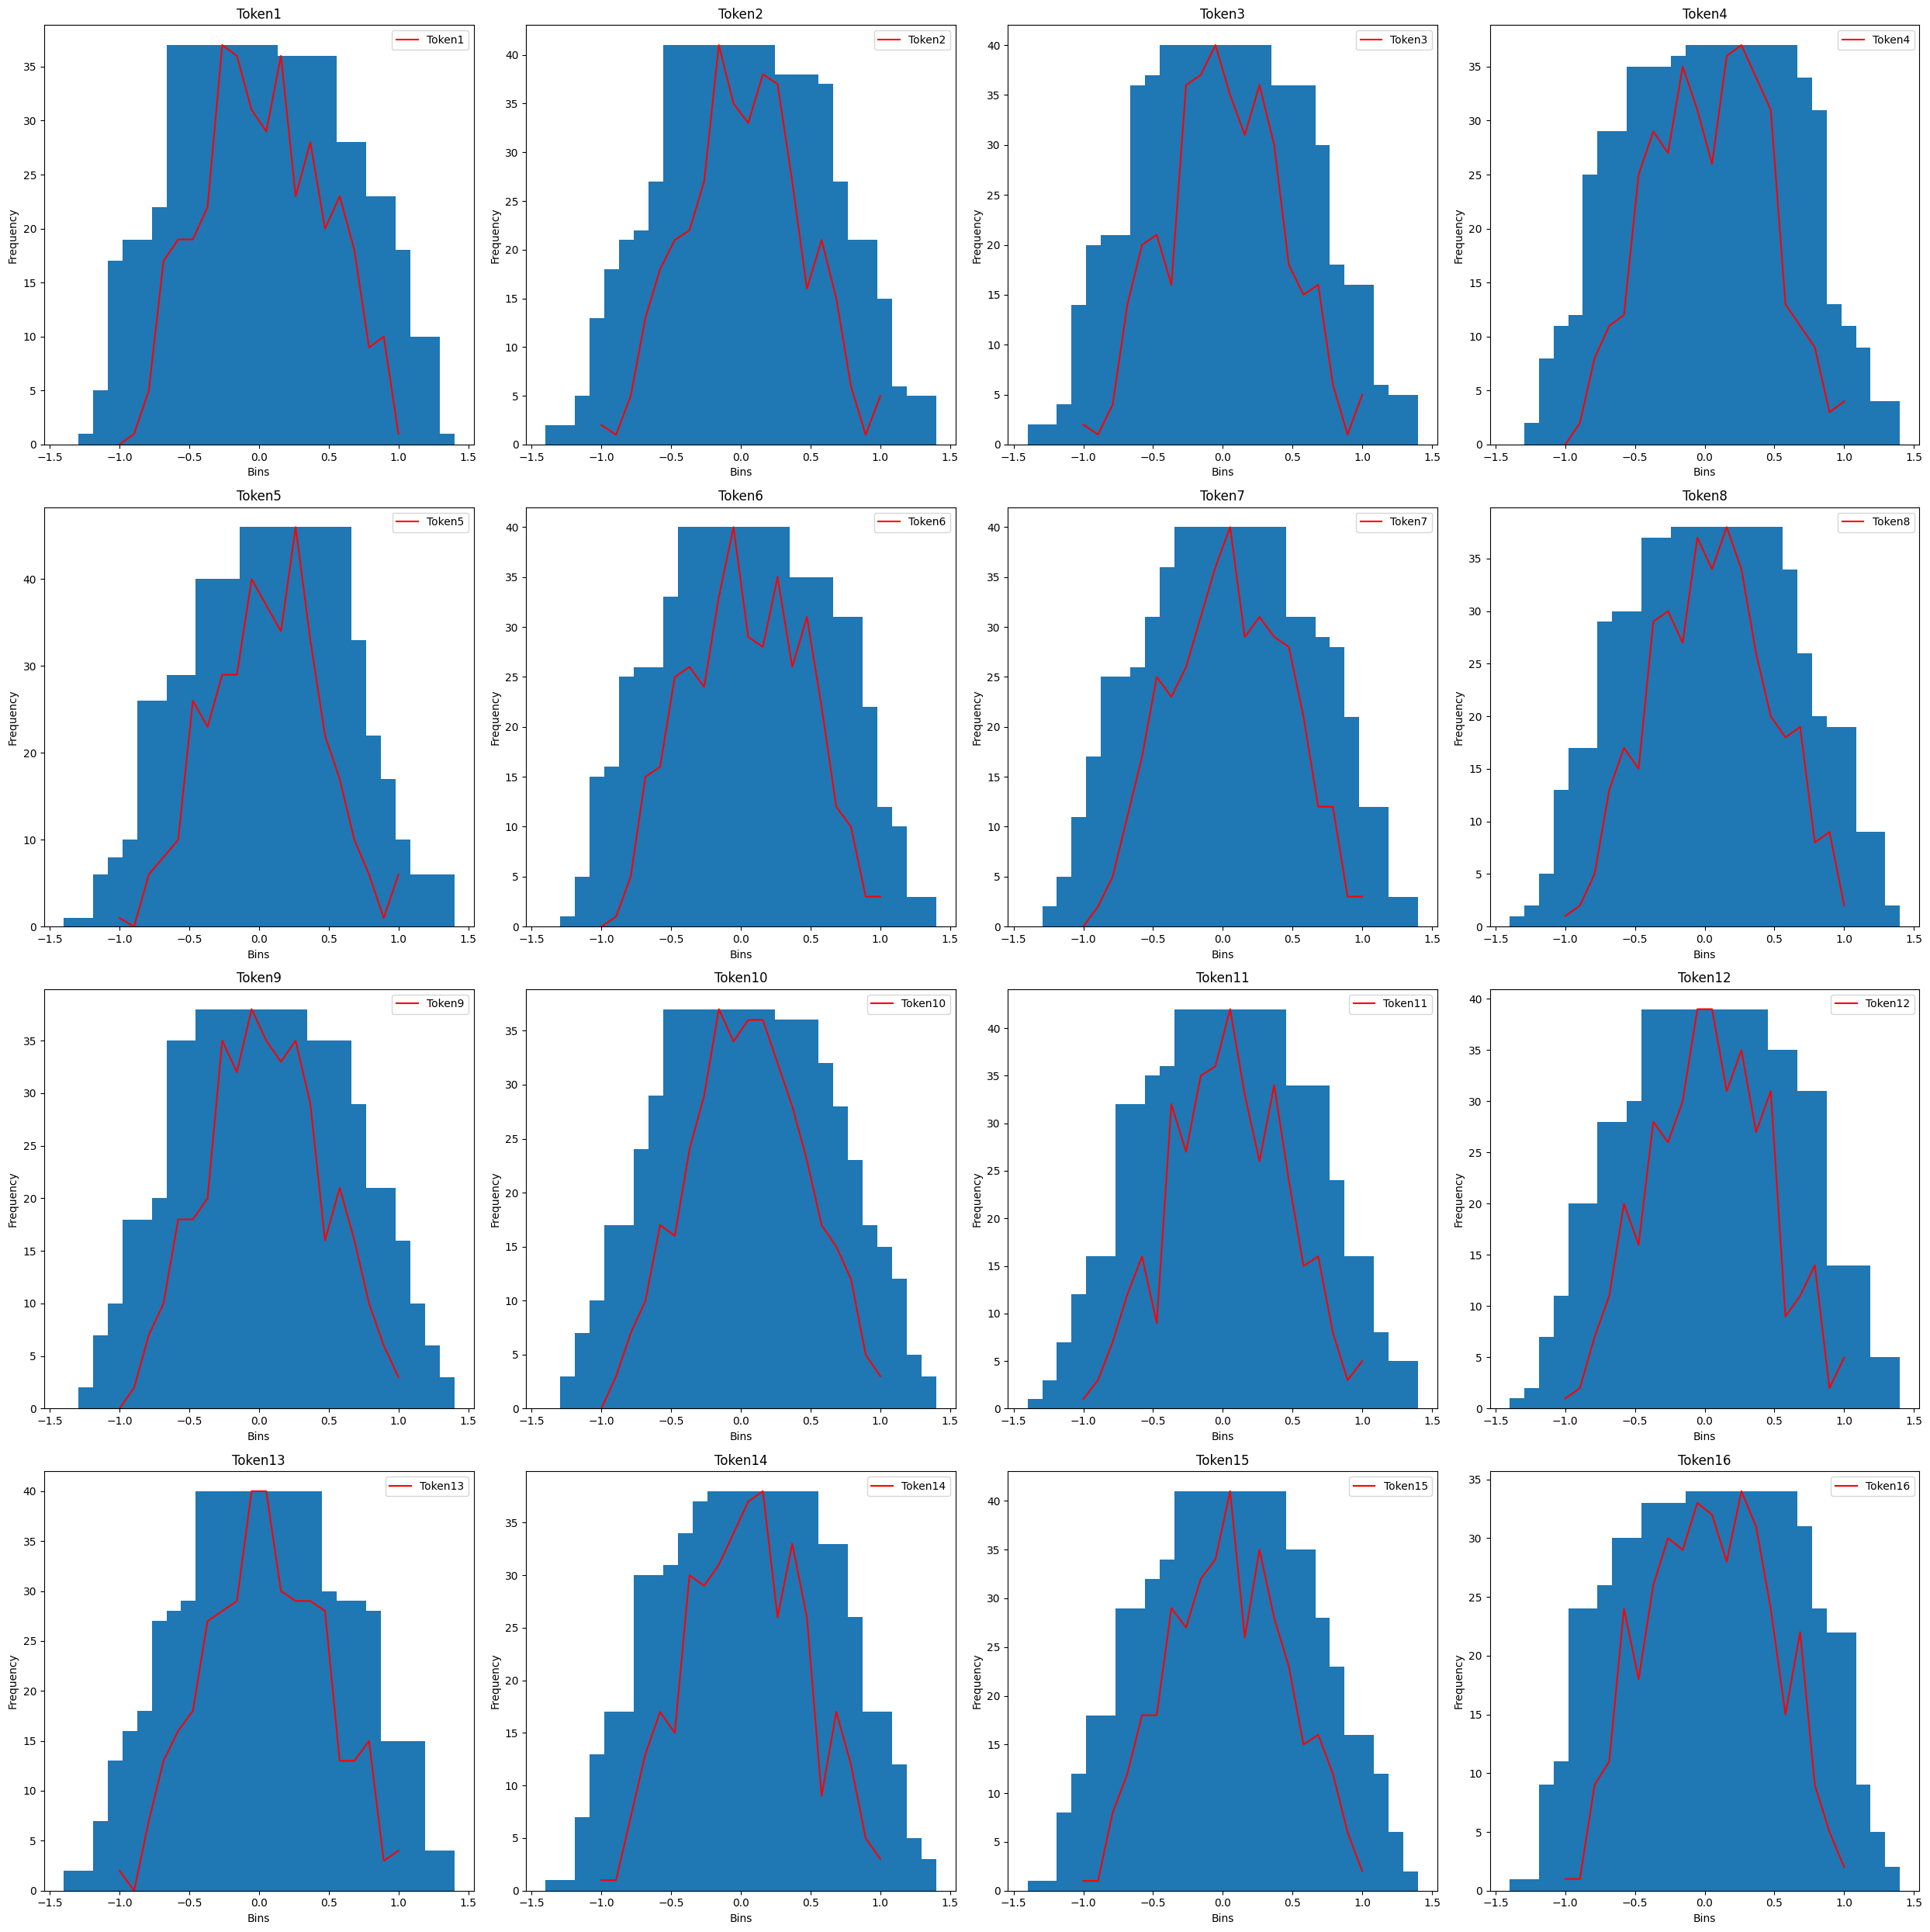

In [29]:
# tanh_feats=torch.tanh(feats)
# print(len(tanh_feats))   #400
# print(tanh_feats.shape)   #(400,384)
# Create a figure and subplots
fig, axs = plt.subplots(4, 4, figsize=(25,25))
rows= 4
cols=4
tokens=0
for i in range(rows):
    for j in range(cols):
        tanh_feats=100*torch.tanh(feats[tokens])
        hist = torch.histc(tanh_feats.cpu(), bins=20, min=-100, max=100)
        x=np.linspace(-100, 100, 20)
        # Plot the subplot
        axs[i, j].plot(x, hist, 'r', label='Token' +str(tokens+1) )
        axs[i, j].bar(x, hist)
        axs[i, j].set_xlabel('Bins')
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].set_title('Token' + str(tokens+1))
        axs[i, j].legend()
        tokens=tokens+1
# Adjust spacing between subplots
plt.tight_layout()
# Show the figure
plt.show()

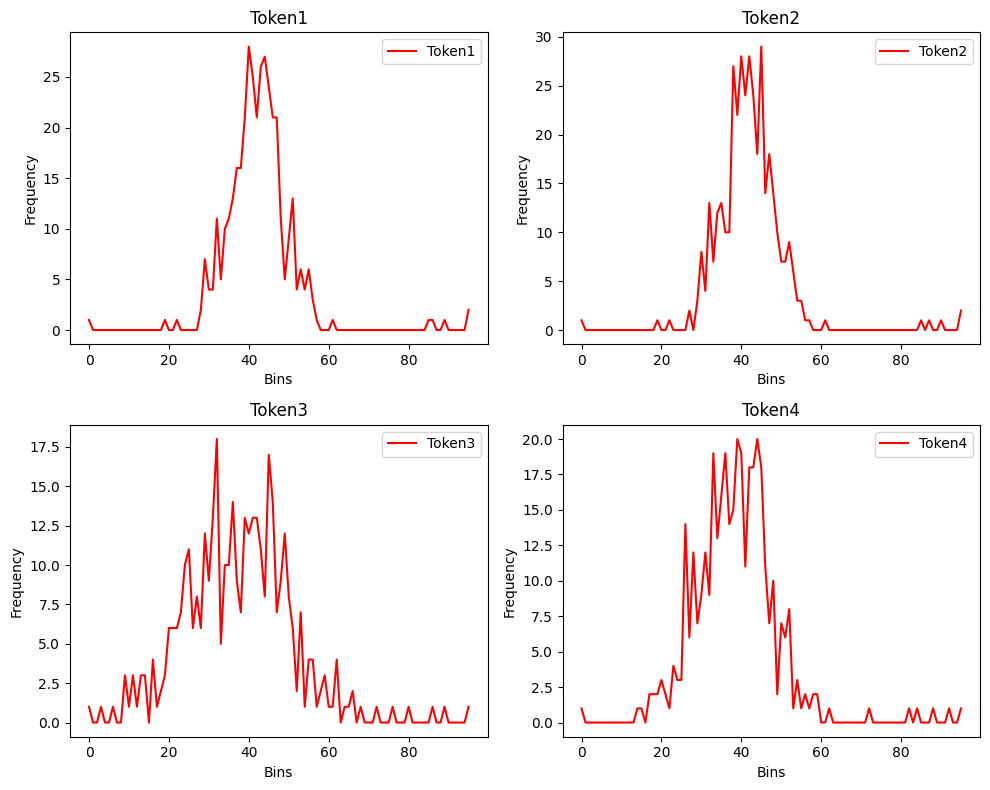

In [23]:
# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

hist1 = torch.histc(feats.cpu()[1,:], bins=96)
hist2 = torch.histc(feats.cpu()[2,:], bins=96)
hist3 = torch.histc(feats.cpu()[3,:], bins=96)
hist4 = torch.histc(feats.cpu()[4,:], bins=96)

# Plot the first subplot
# Plot the first subplot
axs[0, 0].plot(range(len(hist1)), hist1, 'r', label='Token1')
axs[0, 0].set_xlabel('Bins')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Token1')
axs[0, 0].legend()


# Plot the second subplot
axs[0, 1].plot(range(len(hist2)), hist2, 'r', label='Token2')
axs[0, 1].set_xlabel('Bins')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Token2')
axs[0, 1].legend()

# Plot the Third subplot
axs[1, 0].plot(range(len(hist3)), hist3, 'r', label='Token3')
axs[1, 0].set_xlabel('Bins')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Token3')
axs[1, 0].legend()

# Plot the Fourth subplot
axs[1, 1].plot(range(len(hist4)), hist4, 'r', label='Token4')
axs[1, 1].set_xlabel('Bins')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Token4')
axs[1, 1].legend()


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [3]:
# Define a custom dataset class
class Feature_Dataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __getitem__(self, index):
        return self.features[index]

    def __len__(self):
        return len(self.features)

In [6]:
pca_comp=64
pca = PCA(n_components=pca_comp)
utils.make_output_dir(output_dir)
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
for inp in tqdm(inputs):
    index, features_file = inp
    print(index, features_file)
     # Load
    data_dict = torch.load(features_file, map_location='cpu')
    print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
    # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
    image_id = data_dict['file'][:-4]
    print(image_id)
    # Load
    output_file = str(Path(output_dir) / f'{image_id}.pth')
    if Path(output_file).is_file():
        print(f'Skipping existing file {str(output_file)}')
        # break
        # return  # skip because already generated

    # Load affinity matrix
    feats = data_dict[which_features].squeeze().cuda()
    # print("Without normalizing, Features Shape is",feats.shape)
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)
    # print("After normalization, Features Shape",feats.shape)
    # print("which_matrix=", which_matrix)
    # Eigenvectors of affinity matrix
    if which_matrix == 'affinity_torch':
        W = feats @ feats.T
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
            # print("W shape=", W.shape)
        eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
        eigenvalues = eigenvalues.cpu()
        eigenvectors = eigenvectors.cpu()
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity_svd':
        USV = torch.linalg.svd(feats, full_matrices=False)
        eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
        eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
        print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity':
        # print("Without normalizing, Features Shape is",feats.shape)
        W = (feats @ feats.T)
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
        W = W.cpu().numpy()
        # print("W shape=", W.shape)
        eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
        eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of matting laplacian matrix
    elif which_matrix in ['matting_laplacian', 'laplacian']:

        # Get sizes
        B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
        if image_downsample_factor is None:
            image_downsample_factor = P
        H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

        # Upscale features to match the resolution
        if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
            feats = F.interpolate(
                feats.T.reshape(1, -1, H_patch, W_patch),
                size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
            ).reshape(-1, H_pad_lr * W_pad_lr).T

        ### Feature affinities
        # print("Without normalizing, Features Shape is",feats.shape)

        W_feat_ds = (feats @ feats.T)
        max_wfeatds=torch.max(W_feat_ds).item()
        alpha=3
        W_feat_ds = W_feat_ds - (max_wfeatds / alpha)
        layer=nn.Linear(pca_comp,pca_comp).cuda()
        x0=feats
        x0_arr=x0.cpu()
        # print(x0_arr.shape)
        z0_arr= pca.fit_transform(x0_arr)

        # Define the affine transformation parameters
        scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
        translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
        rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
        shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions

        # Define the affine matrix
        affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
                                  [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
                                  [0, 0, 1]])
        z1_arr=affine_transform(z0_arr, affine_matrix)
#         z1_arr=pca.fit_transform(z1_arr)
        z0 = torch.from_numpy(z0_arr).float()
        z1 = torch.from_numpy(z1_arr).float()

        # feat_list.append(feats)
        feat_dataset_z0 = Feature_Dataset(z0)
        if feats.shape[0]%2==0:
            features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)

        feat_dataset_z1 = Feature_Dataset(z1)
        if feats.shape[0]%2==0:
            features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
        criterion = NegativeCosineSimilarity()
        optimizer = torch.optim.SGD(layer.parameters(), lr=0.06)
        print("Starting Training")
        for epoch in range(epochs):
            total_loss = 0
            for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
                z0_new = z0_new.to(device)
                z1_new = z1_new.to(device)
    #             print("z0_new.shape", z0_new.shape)
    #             print("z1_new.shape", z1_new.shape)
                p0=layer(z0_new)
                p1=layer(z1_new)
    #             print("p0.shape", p0.shape)
    #             print("p1.shape", p1.shape)
                loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
                total_loss += loss.detach()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            avg_loss = total_loss / len(features_dataloader_z0)
            print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
        projected_feature=layer(z0.to(device))
        print(projected_feature.shape)
        W_feat_siam=torch.matmul(projected_feature, projected_feature.t())
        # max_wfeatsiam=torch.max(W_feat_siam).item()
        # alpha=3
        # W_feat_siam = W_feat_siam - (max_wfeatsiam / alpha)
        # W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
        W_feat=W_feat_ds + 0.1*W_feat_siam
#         W_feat=normalize_affinity_matrix(W_feat_unnorm, axis=1)
        # print("W_feat.shape=", W_feat.shape)
        # print("W_feat.shape=", W_feat.shape)
        # W_feat=contrastive_affinity(feats, feats.T)
        if threshold_at_zero:
            W_feat = (W_feat * (W_feat > 0))
        W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
        # W_feat = W_feat.cpu().numpy()
        W_feat = W_feat.detach().cpu().numpy()
        # print("W_feat shape=",W_feat.shape)

        ### Color affinities
        # If we are fusing with color affinites, then load the image and compute
        if image_color_lambda > 0:

            # Load image
            image_file = str(Path(images_root) / f'{image_id}.jpg')
            image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
            image_lr = np.array(image_lr) / 255.

            # Color affinities (of type scipy.sparse.csr_matrix)
            if which_color_matrix == 'knn':
                W_lr = utils.knn_affinity(image_lr / 255)
            elif which_color_matrix == 'rw':
                W_lr = utils.rw_affinity(image_lr / 255)

            # Convert to dense numpy array
            W_color = np.array(W_lr.todense().astype(np.float32))
            # print("W_color shape", W_color.shape)

        else:

            # No color affinity
            W_color = 0

        # Combine
        W_comb = W_feat + W_color * image_color_lambda  # combination
        D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
        # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
        if lapnorm:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
        else:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
        eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
    # Sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Save dict
    output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
    torch.save(output_dict, output_file)

  0%|                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]

0 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0001.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0001
Starting Training
epoch: 00, loss: -0.01469
epoch: 01, loss: -0.03822
epoch: 02, loss: -0.04120
epoch: 03, loss: -0.04389
epoch: 04, loss: -0.04602
epoch: 05, loss: -0.04341
epoch: 06, loss: -0.04534
epoch: 07, loss: -0.04503
epoch: 08, loss: -0.04780
epoch: 09, loss: -0.04779
torch.Size([400, 64])


  0%|▏                                                                                                                                                                  | 1/1000 [00:26<7:24:48, 26.72s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
1 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0002.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0002
Starting Training
epoch: 00, loss: -0.01980
epoch: 01, loss: -0.04086
epoch: 02, loss: -0.04452
epoch: 03, loss: -0.04482
epoch: 04, loss: -0.04549
epoch: 05, loss: -0.04542
epoch: 06, loss: -0.04565
epoch: 07, loss: -0.04592
epoch: 08, loss: -0.04594
epoch: 09, loss: -0.04603
torch.Size([400, 64])


  0%|▎                                                                                                                                                                  | 2/1000 [00:52<7:17:19, 26.29s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
2 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0003.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0003
Starting Training
epoch: 00, loss: -0.04015
epoch: 01, loss: -0.07432
epoch: 02, loss: -0.07755
epoch: 03, loss: -0.07779
epoch: 04, loss: -0.08153
epoch: 05, loss: -0.08092
epoch: 06, loss: -0.08330
epoch: 07, loss: -0.08204
epoch: 08, loss: -0.08360
epoch: 09, loss: -0.08257
torch.Size([400, 64])


  0%|▍                                                                                                                                                                  | 3/1000 [01:14<6:41:08, 24.14s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
3 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0004.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0004
Starting Training
epoch: 00, loss: -0.02659
epoch: 01, loss: -0.05154
epoch: 02, loss: -0.05424
epoch: 03, loss: -0.05463
epoch: 04, loss: -0.05508
epoch: 05, loss: -0.05519
epoch: 06, loss: -0.05544
epoch: 07, loss: -0.05541
epoch: 08, loss: -0.05569
epoch: 09, loss: -0.05581
torch.Size([400, 64])


  0%|▋                                                                                                                                                                  | 4/1000 [01:34<6:12:18, 22.43s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
4 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0005.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0005
Starting Training
epoch: 00, loss: -0.01359
epoch: 01, loss: -0.03690
epoch: 02, loss: -0.04075
epoch: 03, loss: -0.04168
epoch: 04, loss: -0.04213
epoch: 05, loss: -0.04214
epoch: 06, loss: -0.04253
epoch: 07, loss: -0.04252
epoch: 08, loss: -0.04280
epoch: 09, loss: -0.04281
torch.Size([400, 64])


  0%|▊                                                                                                                                                                  | 5/1000 [01:54<5:59:26, 21.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
5 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0006.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0006
Starting Training
epoch: 00, loss: -0.03020
epoch: 01, loss: -0.05364
epoch: 02, loss: -0.05532
epoch: 03, loss: -0.05578
epoch: 04, loss: -0.05599
epoch: 05, loss: -0.05626
epoch: 06, loss: -0.05654
epoch: 07, loss: -0.05653
epoch: 08, loss: -0.05673
epoch: 09, loss: -0.05692
torch.Size([400, 64])


  1%|▉                                                                                                                                                                  | 6/1000 [02:15<5:57:59, 21.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
6 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0007.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0007
Starting Training
epoch: 00, loss: -0.03693
epoch: 01, loss: -0.07042
epoch: 02, loss: -0.07457
epoch: 03, loss: -0.07505
epoch: 04, loss: -0.07766
epoch: 05, loss: -0.07606
epoch: 06, loss: -0.07853
epoch: 07, loss: -0.07742
epoch: 08, loss: -0.07824
epoch: 09, loss: -0.07879
torch.Size([400, 64])


  1%|█▏                                                                                                                                                                 | 7/1000 [02:35<5:44:24, 20.81s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
7 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0008.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0008
Starting Training
epoch: 00, loss: -0.00565
epoch: 01, loss: -0.01619
epoch: 02, loss: -0.01959
epoch: 03, loss: -0.02128
epoch: 04, loss: -0.02166
epoch: 05, loss: -0.02241
epoch: 06, loss: -0.02241
epoch: 07, loss: -0.02274
epoch: 08, loss: -0.02289
epoch: 09, loss: -0.02320
torch.Size([400, 64])


  1%|█▎                                                                                                                                                                 | 8/1000 [02:58<6:00:11, 21.79s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
8 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0009.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0009
Starting Training
epoch: 00, loss: -0.05296
epoch: 01, loss: -0.07794
epoch: 02, loss: -0.08137
epoch: 03, loss: -0.08543
epoch: 04, loss: -0.08334
epoch: 05, loss: -0.08643
epoch: 06, loss: -0.08848
epoch: 07, loss: -0.09089
epoch: 08, loss: -0.08816
epoch: 09, loss: -0.08829
torch.Size([400, 64])


  1%|█▍                                                                                                                                                                 | 9/1000 [03:23<6:14:21, 22.67s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
9 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0010.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0010
Starting Training
epoch: 00, loss: -0.10002
epoch: 01, loss: -0.13192
epoch: 02, loss: -0.13897
epoch: 03, loss: -0.14011
epoch: 04, loss: -0.14249
epoch: 05, loss: -0.14484
epoch: 06, loss: -0.14455
epoch: 07, loss: -0.14309
epoch: 08, loss: -0.14388
epoch: 09, loss: -0.14295
torch.Size([400, 64])


  1%|█▌                                                                                                                                                                | 10/1000 [03:46<6:17:55, 22.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
10 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0011.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0011
Starting Training
epoch: 00, loss: -0.03431
epoch: 01, loss: -0.05724
epoch: 02, loss: -0.05819
epoch: 03, loss: -0.05913
epoch: 04, loss: -0.05912
epoch: 05, loss: -0.05926
epoch: 06, loss: -0.05953
epoch: 07, loss: -0.05979
epoch: 08, loss: -0.05967
epoch: 09, loss: -0.05986
torch.Size([400, 64])


  1%|█▊                                                                                                                                                                | 11/1000 [04:09<6:13:38, 22.67s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
11 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0012.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0012
Starting Training
epoch: 00, loss: -0.02381
epoch: 01, loss: -0.04867
epoch: 02, loss: -0.05164
epoch: 03, loss: -0.05241
epoch: 04, loss: -0.05299
epoch: 05, loss: -0.05317
epoch: 06, loss: -0.05344
epoch: 07, loss: -0.05344
epoch: 08, loss: -0.05401
epoch: 09, loss: -0.05379
torch.Size([400, 64])


  1%|█▉                                                                                                                                                                | 12/1000 [04:33<6:19:27, 23.04s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
12 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0013.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0013
Starting Training
epoch: 00, loss: -0.04177
epoch: 01, loss: -0.07872
epoch: 02, loss: -0.08364
epoch: 03, loss: -0.08894
epoch: 04, loss: -0.08893
epoch: 05, loss: -0.08824
epoch: 06, loss: -0.08976
epoch: 07, loss: -0.09301
epoch: 08, loss: -0.09051
epoch: 09, loss: -0.09065
torch.Size([400, 64])


  1%|██                                                                                                                                                                | 13/1000 [04:54<6:12:18, 22.63s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
13 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0014.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0014
Starting Training
epoch: 00, loss: -0.03224
epoch: 01, loss: -0.05960
epoch: 02, loss: -0.06774
epoch: 03, loss: -0.06674
epoch: 04, loss: -0.06985
epoch: 05, loss: -0.06905
epoch: 06, loss: -0.06946
epoch: 07, loss: -0.07176
epoch: 08, loss: -0.06937
epoch: 09, loss: -0.07237
torch.Size([400, 64])


  1%|██▎                                                                                                                                                               | 14/1000 [05:16<6:08:11, 22.40s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
14 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0015.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0015
Starting Training
epoch: 00, loss: -0.03183
epoch: 01, loss: -0.06160
epoch: 02, loss: -0.06770
epoch: 03, loss: -0.06748
epoch: 04, loss: -0.06782
epoch: 05, loss: -0.06861
epoch: 06, loss: -0.06972
epoch: 07, loss: -0.07043
epoch: 08, loss: -0.07220
epoch: 09, loss: -0.07198
torch.Size([400, 64])


  2%|██▍                                                                                                                                                               | 15/1000 [05:42<6:25:52, 23.50s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
15 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0016.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0016
Starting Training
epoch: 00, loss: -0.00017
epoch: 01, loss: -0.01802
epoch: 02, loss: -0.02367
epoch: 03, loss: -0.02618
epoch: 04, loss: -0.02710
epoch: 05, loss: -0.02764
epoch: 06, loss: -0.02798
epoch: 07, loss: -0.02808
epoch: 08, loss: -0.02828
epoch: 09, loss: -0.02839
torch.Size([400, 64])


  2%|██▌                                                                                                                                                               | 16/1000 [06:04<6:15:29, 22.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
16 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0017.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0017
Starting Training
epoch: 00, loss: -0.01362
epoch: 01, loss: -0.03118
epoch: 02, loss: -0.03470
epoch: 03, loss: -0.03551
epoch: 04, loss: -0.03610
epoch: 05, loss: -0.03661
epoch: 06, loss: -0.03661
epoch: 07, loss: -0.03723
epoch: 08, loss: -0.03696
epoch: 09, loss: -0.03694
torch.Size([400, 64])


  2%|██▊                                                                                                                                                               | 17/1000 [06:31<6:37:24, 24.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
17 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0018.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0018
Starting Training
epoch: 00, loss: -0.04238
epoch: 01, loss: -0.07000
epoch: 02, loss: -0.07122
epoch: 03, loss: -0.07157
epoch: 04, loss: -0.07208
epoch: 05, loss: -0.07222
epoch: 06, loss: -0.07246
epoch: 07, loss: -0.07245
epoch: 08, loss: -0.07282
epoch: 09, loss: -0.07278
torch.Size([400, 64])


  2%|██▉                                                                                                                                                               | 18/1000 [06:55<6:37:31, 24.29s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
18 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0019.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0019
Starting Training
epoch: 00, loss: -0.03146
epoch: 01, loss: -0.04789
epoch: 02, loss: -0.04948
epoch: 03, loss: -0.05020
epoch: 04, loss: -0.04972
epoch: 05, loss: -0.05099
epoch: 06, loss: -0.05116
epoch: 07, loss: -0.05109
epoch: 08, loss: -0.05157
epoch: 09, loss: -0.05110
torch.Size([400, 64])


  2%|███                                                                                                                                                               | 19/1000 [07:19<6:35:31, 24.19s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
19 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0020.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0020
Starting Training
epoch: 00, loss: -0.03263
epoch: 01, loss: -0.06435
epoch: 02, loss: -0.07212
epoch: 03, loss: -0.07223
epoch: 04, loss: -0.07628
epoch: 05, loss: -0.07759
epoch: 06, loss: -0.07815
epoch: 07, loss: -0.07596
epoch: 08, loss: -0.07570
epoch: 09, loss: -0.07728
torch.Size([400, 64])


  2%|███▏                                                                                                                                                              | 20/1000 [07:41<6:21:40, 23.37s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
20 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0021.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0021
Starting Training
epoch: 00, loss: -0.06017
epoch: 01, loss: -0.08068
epoch: 02, loss: -0.08598
epoch: 03, loss: -0.08580
epoch: 04, loss: -0.08631
epoch: 05, loss: -0.08698
epoch: 06, loss: -0.08794
epoch: 07, loss: -0.08982
epoch: 08, loss: -0.08989
epoch: 09, loss: -0.09001
torch.Size([400, 64])


  2%|███▍                                                                                                                                                              | 21/1000 [08:05<6:23:10, 23.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
21 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0022.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0022
Starting Training
epoch: 00, loss: -0.02413
epoch: 01, loss: -0.05198
epoch: 02, loss: -0.05892
epoch: 03, loss: -0.06032
epoch: 04, loss: -0.06481
epoch: 05, loss: -0.06154
epoch: 06, loss: -0.06143
epoch: 07, loss: -0.06189
epoch: 08, loss: -0.06248
epoch: 09, loss: -0.06395
torch.Size([400, 64])


  2%|███▌                                                                                                                                                              | 22/1000 [08:25<6:08:36, 22.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
22 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0023.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0023
Starting Training
epoch: 00, loss: -0.08531
epoch: 01, loss: -0.11730
epoch: 02, loss: -0.12225
epoch: 03, loss: -0.12375
epoch: 04, loss: -0.12597
epoch: 05, loss: -0.12662
epoch: 06, loss: -0.12746
epoch: 07, loss: -0.12759
epoch: 08, loss: -0.12941
epoch: 09, loss: -0.12828
torch.Size([400, 64])


  2%|███▋                                                                                                                                                              | 23/1000 [08:48<6:09:25, 22.69s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
23 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0024.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0024
Starting Training
epoch: 00, loss: -0.01496
epoch: 01, loss: -0.03200
epoch: 02, loss: -0.03489
epoch: 03, loss: -0.03566
epoch: 04, loss: -0.03604
epoch: 05, loss: -0.03618
epoch: 06, loss: -0.03655
epoch: 07, loss: -0.03665
epoch: 08, loss: -0.03693
epoch: 09, loss: -0.03693
torch.Size([400, 64])


  2%|███▉                                                                                                                                                              | 24/1000 [09:13<6:18:57, 23.30s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
24 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0025.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0025
Starting Training
epoch: 00, loss: -0.13274
epoch: 01, loss: -0.17279
epoch: 02, loss: -0.17980
epoch: 03, loss: -0.18209
epoch: 04, loss: -0.18588
epoch: 05, loss: -0.18622
epoch: 06, loss: -0.18828
epoch: 07, loss: -0.19376
epoch: 08, loss: -0.18743
epoch: 09, loss: -0.19275
torch.Size([400, 64])


  2%|████                                                                                                                                                              | 25/1000 [09:31<5:55:00, 21.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
25 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0026.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0026
Starting Training
epoch: 00, loss: -0.09411
epoch: 01, loss: -0.11984
epoch: 02, loss: -0.12426
epoch: 03, loss: -0.12634
epoch: 04, loss: -0.12692
epoch: 05, loss: -0.12872
epoch: 06, loss: -0.12723
epoch: 07, loss: -0.12905
epoch: 08, loss: -0.12921
epoch: 09, loss: -0.13036
torch.Size([400, 64])


  3%|████▏                                                                                                                                                             | 26/1000 [10:02<6:36:03, 24.40s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
26 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0027.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0027
Starting Training
epoch: 00, loss: -0.01883
epoch: 01, loss: -0.04815
epoch: 02, loss: -0.05510
epoch: 03, loss: -0.05566
epoch: 04, loss: -0.05773
epoch: 05, loss: -0.05777
epoch: 06, loss: -0.05832
epoch: 07, loss: -0.05781
epoch: 08, loss: -0.05641
epoch: 09, loss: -0.05903
torch.Size([400, 64])


  3%|████▎                                                                                                                                                             | 27/1000 [10:28<6:45:18, 24.99s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
27 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0028.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0028
Starting Training
epoch: 00, loss: -0.07550
epoch: 01, loss: -0.10674
epoch: 02, loss: -0.11292
epoch: 03, loss: -0.11417
epoch: 04, loss: -0.11560
epoch: 05, loss: -0.11671
epoch: 06, loss: -0.11690
epoch: 07, loss: -0.11707
epoch: 08, loss: -0.11994
epoch: 09, loss: -0.11802
torch.Size([400, 64])


  3%|████▌                                                                                                                                                             | 28/1000 [11:00<7:18:34, 27.07s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
28 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0029.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0029
Starting Training
epoch: 00, loss: -0.03865
epoch: 01, loss: -0.07489
epoch: 02, loss: -0.07977
epoch: 03, loss: -0.08246
epoch: 04, loss: -0.08474
epoch: 05, loss: -0.08670
epoch: 06, loss: -0.08483
epoch: 07, loss: -0.08591
epoch: 08, loss: -0.08624
epoch: 09, loss: -0.08694
torch.Size([400, 64])


  3%|████▋                                                                                                                                                             | 29/1000 [11:26<7:14:23, 26.84s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
29 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0030.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0030
Starting Training
epoch: 00, loss: -0.02505
epoch: 01, loss: -0.05237
epoch: 02, loss: -0.05426
epoch: 03, loss: -0.05580
epoch: 04, loss: -0.05555
epoch: 05, loss: -0.05570
epoch: 06, loss: -0.05590
epoch: 07, loss: -0.05612
epoch: 08, loss: -0.05629
epoch: 09, loss: -0.05633
torch.Size([400, 64])


  3%|████▊                                                                                                                                                             | 30/1000 [11:55<7:21:52, 27.33s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
30 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0031.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0031
Starting Training
epoch: 00, loss: -0.11144
epoch: 01, loss: -0.15621
epoch: 02, loss: -0.15803
epoch: 03, loss: -0.16473
epoch: 04, loss: -0.16062
epoch: 05, loss: -0.16394
epoch: 06, loss: -0.16376
epoch: 07, loss: -0.16908
epoch: 08, loss: -0.16461
epoch: 09, loss: -0.16415
torch.Size([400, 64])


  3%|█████                                                                                                                                                             | 31/1000 [12:22<7:22:46, 27.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
31 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0032.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0032
Starting Training
epoch: 00, loss: -0.01780
epoch: 01, loss: -0.04240
epoch: 02, loss: -0.04566
epoch: 03, loss: -0.04646
epoch: 04, loss: -0.04703
epoch: 05, loss: -0.04700
epoch: 06, loss: -0.04699
epoch: 07, loss: -0.04724
epoch: 08, loss: -0.04730
epoch: 09, loss: -0.04768
torch.Size([400, 64])


  3%|█████▏                                                                                                                                                            | 32/1000 [12:44<6:56:28, 25.81s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
32 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0033.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0033
Starting Training
epoch: 00, loss: -0.00738
epoch: 01, loss: -0.02398
epoch: 02, loss: -0.02809
epoch: 03, loss: -0.02939
epoch: 04, loss: -0.02997
epoch: 05, loss: -0.03032
epoch: 06, loss: -0.03062
epoch: 07, loss: -0.03086
epoch: 08, loss: -0.03098
epoch: 09, loss: -0.03096
torch.Size([400, 64])


  3%|█████▎                                                                                                                                                            | 33/1000 [13:13<7:08:51, 26.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
33 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0034.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0034
Starting Training
epoch: 00, loss: -0.09491
epoch: 01, loss: -0.12117
epoch: 02, loss: -0.12657
epoch: 03, loss: -0.12784
epoch: 04, loss: -0.13225
epoch: 05, loss: -0.13041
epoch: 06, loss: -0.13018
epoch: 07, loss: -0.13367
epoch: 08, loss: -0.13328
epoch: 09, loss: -0.13851
torch.Size([400, 64])


  3%|█████▌                                                                                                                                                            | 34/1000 [13:41<7:15:24, 27.04s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
34 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0035.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0035
Starting Training
epoch: 00, loss: -0.00840
epoch: 01, loss: -0.02789
epoch: 02, loss: -0.03512
epoch: 03, loss: -0.03696
epoch: 04, loss: -0.03955
epoch: 05, loss: -0.04060
epoch: 06, loss: -0.04315
epoch: 07, loss: -0.04208
epoch: 08, loss: -0.04217
epoch: 09, loss: -0.04376
torch.Size([400, 64])


  4%|█████▋                                                                                                                                                            | 35/1000 [14:03<6:51:53, 25.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
35 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0036.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0036
Starting Training
epoch: 00, loss: -0.07431
epoch: 01, loss: -0.11293
epoch: 02, loss: -0.11606
epoch: 03, loss: -0.11736
epoch: 04, loss: -0.11684
epoch: 05, loss: -0.12218
epoch: 06, loss: -0.11787
epoch: 07, loss: -0.11677
epoch: 08, loss: -0.12000
epoch: 09, loss: -0.11944
torch.Size([450, 64])


  4%|█████▊                                                                                                                                                            | 36/1000 [14:27<6:43:41, 25.13s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
36 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0037.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0037
Starting Training
epoch: 00, loss: -0.02802
epoch: 01, loss: -0.05128
epoch: 02, loss: -0.05550
epoch: 03, loss: -0.05631
epoch: 04, loss: -0.05805
epoch: 05, loss: -0.05896
epoch: 06, loss: -0.06035
epoch: 07, loss: -0.05955
epoch: 08, loss: -0.06037
epoch: 09, loss: -0.06079
torch.Size([450, 64])


  4%|█████▉                                                                                                                                                            | 37/1000 [14:57<7:07:55, 26.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
37 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0038.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0038
Starting Training
epoch: 00, loss: -0.02411
epoch: 01, loss: -0.04574
epoch: 02, loss: -0.04815
epoch: 03, loss: -0.04858
epoch: 04, loss: -0.04937
epoch: 05, loss: -0.04932
epoch: 06, loss: -0.04954
epoch: 07, loss: -0.04963
epoch: 08, loss: -0.04964
epoch: 09, loss: -0.04981
torch.Size([400, 64])


  4%|██████▏                                                                                                                                                           | 38/1000 [15:22<6:58:01, 26.07s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
38 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0039.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0039
Starting Training
epoch: 00, loss: -0.04822
epoch: 01, loss: -0.07887
epoch: 02, loss: -0.08378
epoch: 03, loss: -0.08495
epoch: 04, loss: -0.08415
epoch: 05, loss: -0.08712
epoch: 06, loss: -0.08655
epoch: 07, loss: -0.09063
epoch: 08, loss: -0.08672
epoch: 09, loss: -0.08844
torch.Size([400, 64])


  4%|██████▎                                                                                                                                                           | 39/1000 [15:47<6:50:43, 25.64s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
39 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0040.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0040
Starting Training
epoch: 00, loss: -0.06273
epoch: 01, loss: -0.08649
epoch: 02, loss: -0.08720
epoch: 03, loss: -0.08775
epoch: 04, loss: -0.08781
epoch: 05, loss: -0.08809
epoch: 06, loss: -0.08829
epoch: 07, loss: -0.08823
epoch: 08, loss: -0.08849
epoch: 09, loss: -0.08860
torch.Size([400, 64])


  4%|██████▍                                                                                                                                                           | 40/1000 [16:13<6:54:05, 25.88s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
40 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0041.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0041
Starting Training
epoch: 00, loss: -0.00529
epoch: 01, loss: -0.03443
epoch: 02, loss: -0.03769
epoch: 03, loss: -0.03966
epoch: 04, loss: -0.04096
epoch: 05, loss: -0.04174
epoch: 06, loss: -0.04363
epoch: 07, loss: -0.04327
epoch: 08, loss: -0.04448
epoch: 09, loss: -0.04435
torch.Size([450, 64])


  4%|██████▋                                                                                                                                                           | 41/1000 [16:41<7:03:59, 26.53s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
41 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0042.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0042
Starting Training
epoch: 00, loss: -0.00671
epoch: 01, loss: -0.02676
epoch: 02, loss: -0.03159
epoch: 03, loss: -0.03286
epoch: 04, loss: -0.03357
epoch: 05, loss: -0.03367
epoch: 06, loss: -0.03392
epoch: 07, loss: -0.03411
epoch: 08, loss: -0.03440
epoch: 09, loss: -0.03441
torch.Size([400, 64])


  4%|██████▊                                                                                                                                                           | 42/1000 [17:05<6:48:56, 25.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
42 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0043.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0043
Starting Training
epoch: 00, loss: -0.04106
epoch: 01, loss: -0.06822
epoch: 02, loss: -0.06974
epoch: 03, loss: -0.07137
epoch: 04, loss: -0.07114
epoch: 05, loss: -0.07278
epoch: 06, loss: -0.07398
epoch: 07, loss: -0.07121
epoch: 08, loss: -0.07275
epoch: 09, loss: -0.07336
torch.Size([450, 64])


  4%|██████▉                                                                                                                                                           | 43/1000 [17:33<7:02:36, 26.50s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
43 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0044.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0044
Starting Training
epoch: 00, loss: -0.04761
epoch: 01, loss: -0.08146
epoch: 02, loss: -0.08573
epoch: 03, loss: -0.08772
epoch: 04, loss: -0.08879
epoch: 05, loss: -0.08561
epoch: 06, loss: -0.09054
epoch: 07, loss: -0.08921
epoch: 08, loss: -0.08858
epoch: 09, loss: -0.09074
torch.Size([525, 64])


  4%|███████▏                                                                                                                                                          | 44/1000 [18:08<7:43:05, 29.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
44 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0045.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0045
Starting Training
epoch: 00, loss: -0.06991
epoch: 01, loss: -0.09346
epoch: 02, loss: -0.09792
epoch: 03, loss: -0.09836
epoch: 04, loss: -0.10156
epoch: 05, loss: -0.10122
epoch: 06, loss: -0.10403
epoch: 07, loss: -0.10185
epoch: 08, loss: -0.10450
epoch: 09, loss: -0.10491
torch.Size([450, 64])


  4%|███████▎                                                                                                                                                          | 45/1000 [18:37<7:40:50, 28.95s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
45 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0046.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0046
Starting Training
epoch: 00, loss: -0.05184
epoch: 01, loss: -0.07819
epoch: 02, loss: -0.08181
epoch: 03, loss: -0.08167
epoch: 04, loss: -0.08235
epoch: 05, loss: -0.08477
epoch: 06, loss: -0.08276
epoch: 07, loss: -0.08452
epoch: 08, loss: -0.08328
epoch: 09, loss: -0.08392
torch.Size([450, 64])


  5%|███████▍                                                                                                                                                          | 46/1000 [19:05<7:36:01, 28.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
46 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0047.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0047
Starting Training
epoch: 00, loss: -0.05169
epoch: 01, loss: -0.07328
epoch: 02, loss: -0.07966
epoch: 03, loss: -0.07842
epoch: 04, loss: -0.08077
epoch: 05, loss: -0.08012
epoch: 06, loss: -0.08116
epoch: 07, loss: -0.08144
epoch: 08, loss: -0.08194
epoch: 09, loss: -0.08374
torch.Size([400, 64])


  5%|███████▌                                                                                                                                                          | 47/1000 [19:36<7:44:34, 29.25s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
47 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0048.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0048
Starting Training
epoch: 00, loss: -0.06160
epoch: 01, loss: -0.09410
epoch: 02, loss: -0.09644
epoch: 03, loss: -0.10049
epoch: 04, loss: -0.10116
epoch: 05, loss: -0.10079
epoch: 06, loss: -0.10054
epoch: 07, loss: -0.09947
epoch: 08, loss: -0.10255
epoch: 09, loss: -0.10375
torch.Size([450, 64])


  5%|███████▊                                                                                                                                                          | 48/1000 [20:09<8:03:14, 30.46s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
48 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0049.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0049
Starting Training
epoch: 00, loss: -0.04269
epoch: 01, loss: -0.07979
epoch: 02, loss: -0.08629
epoch: 03, loss: -0.08421
epoch: 04, loss: -0.08470
epoch: 05, loss: -0.08827
epoch: 06, loss: -0.08933
epoch: 07, loss: -0.08886
epoch: 08, loss: -0.08736
epoch: 09, loss: -0.08836
torch.Size([450, 64])


  5%|███████▉                                                                                                                                                          | 49/1000 [20:39<8:00:19, 30.30s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
49 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0050.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0050
Starting Training
epoch: 00, loss: -0.03509
epoch: 01, loss: -0.06392
epoch: 02, loss: -0.06676
epoch: 03, loss: -0.06754
epoch: 04, loss: -0.06975
epoch: 05, loss: -0.07033
epoch: 06, loss: -0.07112
epoch: 07, loss: -0.07125
epoch: 08, loss: -0.07060
epoch: 09, loss: -0.07117
torch.Size([400, 64])


  5%|████████                                                                                                                                                          | 50/1000 [21:04<7:34:03, 28.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
50 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0051.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0051
Starting Training
epoch: 00, loss: -0.08193
epoch: 01, loss: -0.10023
epoch: 02, loss: -0.10111
epoch: 03, loss: -0.10159
epoch: 04, loss: -0.10163
epoch: 05, loss: -0.10169
epoch: 06, loss: -0.10233
epoch: 07, loss: -0.10236
epoch: 08, loss: -0.10247
epoch: 09, loss: -0.10259
torch.Size([450, 64])


  5%|████████▎                                                                                                                                                         | 51/1000 [21:30<7:23:53, 28.07s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
51 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0052.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0052
Starting Training
epoch: 00, loss: -0.05479
epoch: 01, loss: -0.07435
epoch: 02, loss: -0.07382
epoch: 03, loss: -0.07751
epoch: 04, loss: -0.07561
epoch: 05, loss: -0.07612
epoch: 06, loss: -0.07708
epoch: 07, loss: -0.07812
epoch: 08, loss: -0.07727
epoch: 09, loss: -0.07630
torch.Size([450, 64])


  5%|████████▍                                                                                                                                                         | 52/1000 [21:59<7:24:22, 28.12s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
52 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0053.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0053
Starting Training
epoch: 00, loss: -0.00291
epoch: 01, loss: -0.03883
epoch: 02, loss: -0.04902
epoch: 03, loss: -0.04875
epoch: 04, loss: -0.05204
epoch: 05, loss: -0.05477
epoch: 06, loss: -0.05301
epoch: 07, loss: -0.05608
epoch: 08, loss: -0.05689
epoch: 09, loss: -0.05849
torch.Size([375, 64])


  5%|████████▌                                                                                                                                                         | 53/1000 [22:24<7:10:17, 27.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
53 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0054.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0054
Starting Training
epoch: 00, loss: -0.03795
epoch: 01, loss: -0.06961
epoch: 02, loss: -0.07248
epoch: 03, loss: -0.07378
epoch: 04, loss: -0.07272
epoch: 05, loss: -0.07401
epoch: 06, loss: -0.07631
epoch: 07, loss: -0.07468
epoch: 08, loss: -0.07493
epoch: 09, loss: -0.07659
torch.Size([450, 64])


  5%|████████▋                                                                                                                                                         | 54/1000 [22:53<7:17:47, 27.77s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
54 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0055.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0055
Starting Training
epoch: 00, loss: -0.07112
epoch: 01, loss: -0.10525
epoch: 02, loss: -0.10572
epoch: 03, loss: -0.10750
epoch: 04, loss: -0.10842
epoch: 05, loss: -0.10991
epoch: 06, loss: -0.11008
epoch: 07, loss: -0.10787
epoch: 08, loss: -0.11010
epoch: 09, loss: -0.10882
torch.Size([450, 64])


  6%|████████▉                                                                                                                                                         | 55/1000 [23:22<7:26:19, 28.34s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
55 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0056.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0056
Starting Training
epoch: 00, loss: -0.01802
epoch: 01, loss: -0.03749
epoch: 02, loss: -0.04042
epoch: 03, loss: -0.04126
epoch: 04, loss: -0.04225
epoch: 05, loss: -0.04288
epoch: 06, loss: -0.04301
epoch: 07, loss: -0.04362
epoch: 08, loss: -0.04330
epoch: 09, loss: -0.04372
torch.Size([400, 64])


  6%|█████████                                                                                                                                                         | 56/1000 [23:48<7:14:13, 27.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
56 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0057.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0057
Starting Training
epoch: 00, loss: -0.09331
epoch: 01, loss: -0.12646
epoch: 02, loss: -0.12951
epoch: 03, loss: -0.13223
epoch: 04, loss: -0.13272
epoch: 05, loss: -0.13498
epoch: 06, loss: -0.13349
epoch: 07, loss: -0.13497
epoch: 08, loss: -0.13555
epoch: 09, loss: -0.13746
torch.Size([400, 64])


  6%|█████████▏                                                                                                                                                        | 57/1000 [24:13<7:01:26, 26.82s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
57 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0058.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0058
Starting Training
epoch: 00, loss: -0.06606
epoch: 01, loss: -0.09942
epoch: 02, loss: -0.10361
epoch: 03, loss: -0.10505
epoch: 04, loss: -0.10456
epoch: 05, loss: -0.11016
epoch: 06, loss: -0.10745
epoch: 07, loss: -0.10793
epoch: 08, loss: -0.10977
epoch: 09, loss: -0.10785
torch.Size([425, 64])


  6%|█████████▍                                                                                                                                                        | 58/1000 [24:39<6:55:41, 26.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
58 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0059.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0059
Starting Training
epoch: 00, loss: -0.05294
epoch: 01, loss: -0.07388
epoch: 02, loss: -0.07632
epoch: 03, loss: -0.07797
epoch: 04, loss: -0.07816
epoch: 05, loss: -0.07903
epoch: 06, loss: -0.07984
epoch: 07, loss: -0.07983
epoch: 08, loss: -0.08038
epoch: 09, loss: -0.08000
torch.Size([450, 64])


  6%|█████████▌                                                                                                                                                        | 59/1000 [25:06<6:57:08, 26.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
59 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0060.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0060
Starting Training
epoch: 00, loss: -0.07418
epoch: 01, loss: -0.09829
epoch: 02, loss: -0.09906
epoch: 03, loss: -0.09923
epoch: 04, loss: -0.09940
epoch: 05, loss: -0.09972
epoch: 06, loss: -0.10016
epoch: 07, loss: -0.10004
epoch: 08, loss: -0.10015
epoch: 09, loss: -0.10023
torch.Size([400, 64])


  6%|█████████▋                                                                                                                                                        | 60/1000 [25:28<6:34:21, 25.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
60 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0061.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0061
Starting Training
epoch: 00, loss: -0.05430
epoch: 01, loss: -0.08425
epoch: 02, loss: -0.08643
epoch: 03, loss: -0.09152
epoch: 04, loss: -0.09139
epoch: 05, loss: -0.09363
epoch: 06, loss: -0.09551
epoch: 07, loss: -0.09219
epoch: 08, loss: -0.09227
epoch: 09, loss: -0.09152
torch.Size([425, 64])


  6%|█████████▉                                                                                                                                                        | 61/1000 [25:51<6:24:03, 24.54s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
61 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0062.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0062
Starting Training
epoch: 00, loss: -0.03203
epoch: 01, loss: -0.06292
epoch: 02, loss: -0.06933
epoch: 03, loss: -0.06860
epoch: 04, loss: -0.07261
epoch: 05, loss: -0.07302
epoch: 06, loss: -0.07196
epoch: 07, loss: -0.07160
epoch: 08, loss: -0.07011
epoch: 09, loss: -0.07066
torch.Size([425, 64])


  6%|██████████                                                                                                                                                        | 62/1000 [26:17<6:30:06, 24.95s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
62 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0063.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0063
Starting Training
epoch: 00, loss: -0.04999
epoch: 01, loss: -0.08557
epoch: 02, loss: -0.09096
epoch: 03, loss: -0.09343
epoch: 04, loss: -0.09100
epoch: 05, loss: -0.09511
epoch: 06, loss: -0.09095
epoch: 07, loss: -0.09218
epoch: 08, loss: -0.09339
epoch: 09, loss: -0.09293
torch.Size([400, 64])


  6%|██████████▏                                                                                                                                                       | 63/1000 [26:41<6:26:43, 24.76s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
63 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0064.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0064
Starting Training
epoch: 00, loss: -0.03706
epoch: 01, loss: -0.05262
epoch: 02, loss: -0.05366
epoch: 03, loss: -0.05430
epoch: 04, loss: -0.05452
epoch: 05, loss: -0.05459
epoch: 06, loss: -0.05517
epoch: 07, loss: -0.05500
epoch: 08, loss: -0.05510
epoch: 09, loss: -0.05522
torch.Size([400, 64])


  6%|██████████▎                                                                                                                                                       | 64/1000 [27:05<6:24:35, 24.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
64 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0065.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0065
Starting Training
epoch: 00, loss: -0.01754
epoch: 01, loss: -0.03471
epoch: 02, loss: -0.03613
epoch: 03, loss: -0.03628
epoch: 04, loss: -0.03680
epoch: 05, loss: -0.03943
epoch: 06, loss: -0.03766
epoch: 07, loss: -0.03830
epoch: 08, loss: -0.04088
epoch: 09, loss: -0.03646
torch.Size([450, 64])


  6%|██████████▌                                                                                                                                                       | 65/1000 [27:33<6:36:57, 25.47s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
65 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0066.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0066
Starting Training
epoch: 00, loss: -0.02481
epoch: 01, loss: -0.04884
epoch: 02, loss: -0.05169
epoch: 03, loss: -0.05236
epoch: 04, loss: -0.05238
epoch: 05, loss: -0.05272
epoch: 06, loss: -0.05288
epoch: 07, loss: -0.05303
epoch: 08, loss: -0.05323
epoch: 09, loss: -0.05330
torch.Size([400, 64])


  7%|██████████▋                                                                                                                                                       | 66/1000 [27:53<6:13:50, 24.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
66 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0067.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0067
Starting Training
epoch: 00, loss: -0.00964
epoch: 01, loss: -0.02192
epoch: 02, loss: -0.02611
epoch: 03, loss: -0.02741
epoch: 04, loss: -0.02794
epoch: 05, loss: -0.02802
epoch: 06, loss: -0.02882
epoch: 07, loss: -0.02917
epoch: 08, loss: -0.02910
epoch: 09, loss: -0.02938
torch.Size([350, 64])


  7%|██████████▊                                                                                                                                                       | 67/1000 [28:15<6:03:49, 23.40s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 350])
67 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0068.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0068
Starting Training
epoch: 00, loss: -0.03822
epoch: 01, loss: -0.06077
epoch: 02, loss: -0.06298
epoch: 03, loss: -0.06366
epoch: 04, loss: -0.06505
epoch: 05, loss: -0.06839
epoch: 06, loss: -0.06550
epoch: 07, loss: -0.06800
epoch: 08, loss: -0.06786
epoch: 09, loss: -0.06714
torch.Size([525, 64])


  7%|███████████                                                                                                                                                       | 68/1000 [28:58<7:33:11, 29.18s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
68 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0069.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0069
Starting Training
epoch: 00, loss: -0.04919
epoch: 01, loss: -0.08434
epoch: 02, loss: -0.08789
epoch: 03, loss: -0.08660
epoch: 04, loss: -0.08775
epoch: 05, loss: -0.08752
epoch: 06, loss: -0.08886
epoch: 07, loss: -0.08956
epoch: 08, loss: -0.08981
epoch: 09, loss: -0.09082
torch.Size([425, 64])


  7%|███████████▏                                                                                                                                                      | 69/1000 [29:21<7:02:12, 27.21s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
69 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0070.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0070
Starting Training
epoch: 00, loss: -0.04449
epoch: 01, loss: -0.07538
epoch: 02, loss: -0.07409
epoch: 03, loss: -0.07846
epoch: 04, loss: -0.07800
epoch: 05, loss: -0.07669
epoch: 06, loss: -0.07960
epoch: 07, loss: -0.07944
epoch: 08, loss: -0.07745
epoch: 09, loss: -0.08017
torch.Size([500, 64])


  7%|███████████▎                                                                                                                                                      | 70/1000 [29:47<6:56:48, 26.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
70 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0071.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0071
Starting Training
epoch: 00, loss: -0.06448
epoch: 01, loss: -0.10137
epoch: 02, loss: -0.10590
epoch: 03, loss: -0.10767
epoch: 04, loss: -0.10645
epoch: 05, loss: -0.10817
epoch: 06, loss: -0.10734
epoch: 07, loss: -0.10975
epoch: 08, loss: -0.10780
epoch: 09, loss: -0.10763
torch.Size([450, 64])


  7%|███████████▌                                                                                                                                                      | 71/1000 [30:14<6:56:31, 26.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
71 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0072.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0072
Starting Training
epoch: 00, loss: -0.02817
epoch: 01, loss: -0.05789
epoch: 02, loss: -0.06060
epoch: 03, loss: -0.06104
epoch: 04, loss: -0.06137
epoch: 05, loss: -0.06144
epoch: 06, loss: -0.06157
epoch: 07, loss: -0.06181
epoch: 08, loss: -0.06183
epoch: 09, loss: -0.06200
torch.Size([400, 64])


  7%|███████████▋                                                                                                                                                      | 72/1000 [30:39<6:49:44, 26.49s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
72 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0073.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0073
Starting Training
epoch: 00, loss: -0.03284
epoch: 01, loss: -0.06054
epoch: 02, loss: -0.06396
epoch: 03, loss: -0.06540
epoch: 04, loss: -0.06621
epoch: 05, loss: -0.06577
epoch: 06, loss: -0.06629
epoch: 07, loss: -0.06877
epoch: 08, loss: -0.06851
epoch: 09, loss: -0.06894
torch.Size([450, 64])


  7%|███████████▊                                                                                                                                                      | 73/1000 [31:13<7:23:07, 28.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
73 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0074.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0074
Starting Training
epoch: 00, loss: -0.03538
epoch: 01, loss: -0.06914
epoch: 02, loss: -0.07461
epoch: 03, loss: -0.07420
epoch: 04, loss: -0.07559
epoch: 05, loss: -0.07509
epoch: 06, loss: -0.07536
epoch: 07, loss: -0.07733
epoch: 08, loss: -0.07586
epoch: 09, loss: -0.07708
torch.Size([450, 64])


  7%|███████████▉                                                                                                                                                      | 74/1000 [31:45<7:36:40, 29.59s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
74 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0075.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0075
Starting Training
epoch: 00, loss: -0.07574
epoch: 01, loss: -0.09351
epoch: 02, loss: -0.09364
epoch: 03, loss: -0.09392
epoch: 04, loss: -0.09472
epoch: 05, loss: -0.09491
epoch: 06, loss: -0.09478
epoch: 07, loss: -0.09474
epoch: 08, loss: -0.09475
epoch: 09, loss: -0.09538
torch.Size([450, 64])


  8%|████████████▏                                                                                                                                                     | 75/1000 [32:10<7:14:15, 28.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
75 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0076.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0076
Starting Training
epoch: 00, loss: -0.03432
epoch: 01, loss: -0.06034
epoch: 02, loss: -0.06214
epoch: 03, loss: -0.06230
epoch: 04, loss: -0.06259
epoch: 05, loss: -0.06289
epoch: 06, loss: -0.06305
epoch: 07, loss: -0.06317
epoch: 08, loss: -0.06322
epoch: 09, loss: -0.06336
torch.Size([400, 64])


  8%|████████████▎                                                                                                                                                     | 76/1000 [32:31<6:43:00, 26.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
76 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0077.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0077
Starting Training
epoch: 00, loss: -0.04524
epoch: 01, loss: -0.06848
epoch: 02, loss: -0.06920
epoch: 03, loss: -0.06942
epoch: 04, loss: -0.06982
epoch: 05, loss: -0.07004
epoch: 06, loss: -0.07026
epoch: 07, loss: -0.07036
epoch: 08, loss: -0.07049
epoch: 09, loss: -0.07045
torch.Size([450, 64])


  8%|████████████▍                                                                                                                                                     | 77/1000 [32:55<6:30:02, 25.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
77 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0078.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0078
Starting Training
epoch: 00, loss: -0.03758
epoch: 01, loss: -0.06225
epoch: 02, loss: -0.06856
epoch: 03, loss: -0.07151
epoch: 04, loss: -0.07018
epoch: 05, loss: -0.06989
epoch: 06, loss: -0.07101
epoch: 07, loss: -0.07011
epoch: 08, loss: -0.06944
epoch: 09, loss: -0.07305
torch.Size([400, 64])


  8%|████████████▋                                                                                                                                                     | 78/1000 [33:18<6:20:47, 24.78s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
78 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0079.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0079
Starting Training
epoch: 00, loss: -0.05898
epoch: 01, loss: -0.08565
epoch: 02, loss: -0.08461
epoch: 03, loss: -0.08959
epoch: 04, loss: -0.08716
epoch: 05, loss: -0.08997
epoch: 06, loss: -0.09006
epoch: 07, loss: -0.09201
epoch: 08, loss: -0.09110
epoch: 09, loss: -0.09120
torch.Size([525, 64])


  8%|████████████▊                                                                                                                                                     | 79/1000 [33:55<7:14:34, 28.31s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
79 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0080.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0080
Starting Training
epoch: 00, loss: -0.04750
epoch: 01, loss: -0.08237
epoch: 02, loss: -0.08511
epoch: 03, loss: -0.08690
epoch: 04, loss: -0.08773
epoch: 05, loss: -0.08857
epoch: 06, loss: -0.08938
epoch: 07, loss: -0.09071
epoch: 08, loss: -0.08911
epoch: 09, loss: -0.09019
torch.Size([450, 64])


  8%|████████████▉                                                                                                                                                     | 80/1000 [34:19<6:56:06, 27.14s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
80 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0081.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0081
Starting Training
epoch: 00, loss: -0.06572
epoch: 01, loss: -0.08366
epoch: 02, loss: -0.08406
epoch: 03, loss: -0.08466
epoch: 04, loss: -0.08470
epoch: 05, loss: -0.08465
epoch: 06, loss: -0.08505
epoch: 07, loss: -0.08510
epoch: 08, loss: -0.08515
epoch: 09, loss: -0.08518
torch.Size([450, 64])


  8%|█████████████                                                                                                                                                     | 81/1000 [34:41<6:33:22, 25.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
81 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0082.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0082
Starting Training
epoch: 00, loss: -0.00066
epoch: 01, loss: -0.02412
epoch: 02, loss: -0.03301
epoch: 03, loss: -0.03321
epoch: 04, loss: -0.03521
epoch: 05, loss: -0.03782
epoch: 06, loss: -0.03490
epoch: 07, loss: -0.03693
epoch: 08, loss: -0.03917
epoch: 09, loss: -0.03653
torch.Size([450, 64])


  8%|█████████████▎                                                                                                                                                    | 82/1000 [35:05<6:24:44, 25.15s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
82 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0083.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0083
Starting Training
epoch: 00, loss: -0.02379
epoch: 01, loss: -0.05055
epoch: 02, loss: -0.05265
epoch: 03, loss: -0.05310
epoch: 04, loss: -0.05339
epoch: 05, loss: -0.05334
epoch: 06, loss: -0.05363
epoch: 07, loss: -0.05375
epoch: 08, loss: -0.05376
epoch: 09, loss: -0.05386
torch.Size([450, 64])
eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])


  8%|█████████████▍                                                                                                                                                    | 83/1000 [35:30<6:24:20, 25.15s/it]

83 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0084.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0084
Starting Training
epoch: 00, loss: -0.02287
epoch: 01, loss: -0.04076
epoch: 02, loss: -0.04288
epoch: 03, loss: -0.04375
epoch: 04, loss: -0.04367
epoch: 05, loss: -0.04455
epoch: 06, loss: -0.04435
epoch: 07, loss: -0.04448
epoch: 08, loss: -0.04484
epoch: 09, loss: -0.04470
torch.Size([450, 64])


  8%|█████████████▌                                                                                                                                                    | 84/1000 [35:55<6:22:36, 25.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
84 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0085.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0085
Starting Training
epoch: 00, loss: -0.01773
epoch: 01, loss: -0.02945
epoch: 02, loss: -0.03143
epoch: 03, loss: -0.03217
epoch: 04, loss: -0.03281
epoch: 05, loss: -0.03296
epoch: 06, loss: -0.03331
epoch: 07, loss: -0.03334
epoch: 08, loss: -0.03345
epoch: 09, loss: -0.03358
torch.Size([450, 64])


  8%|█████████████▊                                                                                                                                                    | 85/1000 [36:23<6:35:25, 25.93s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
85 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0086.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0086
Starting Training
epoch: 00, loss: -0.01357
epoch: 01, loss: -0.04137
epoch: 02, loss: -0.04614
epoch: 03, loss: -0.04735
epoch: 04, loss: -0.04977
epoch: 05, loss: -0.04872
epoch: 06, loss: -0.05275
epoch: 07, loss: -0.05061
epoch: 08, loss: -0.05079
epoch: 09, loss: -0.05329
torch.Size([450, 64])


  9%|█████████████▉                                                                                                                                                    | 86/1000 [36:48<6:30:47, 25.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
86 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0087.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0087
Starting Training
epoch: 00, loss: -0.08625
epoch: 01, loss: -0.11007
epoch: 02, loss: -0.11134
epoch: 03, loss: -0.11221
epoch: 04, loss: -0.11263
epoch: 05, loss: -0.11317
epoch: 06, loss: -0.11521
epoch: 07, loss: -0.11509
epoch: 08, loss: -0.11449
epoch: 09, loss: -0.11527
torch.Size([450, 64])


  9%|██████████████                                                                                                                                                    | 87/1000 [37:15<6:35:02, 25.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
87 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0088.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0088
Starting Training
epoch: 00, loss: -0.00375
epoch: 01, loss: -0.01456
epoch: 02, loss: -0.02306
epoch: 03, loss: -0.02590
epoch: 04, loss: -0.02590
epoch: 05, loss: -0.02701
epoch: 06, loss: -0.03000
epoch: 07, loss: -0.03211
epoch: 08, loss: -0.02957
epoch: 09, loss: -0.02871
torch.Size([450, 64])


  9%|██████████████▎                                                                                                                                                   | 88/1000 [37:44<6:51:05, 27.05s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
88 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0089.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0089
Starting Training
epoch: 00, loss: -0.04923
epoch: 01, loss: -0.07930
epoch: 02, loss: -0.07884
epoch: 03, loss: -0.08079
epoch: 04, loss: -0.07953
epoch: 05, loss: -0.08082
epoch: 06, loss: -0.08250
epoch: 07, loss: -0.08028
epoch: 08, loss: -0.08328
epoch: 09, loss: -0.08184
torch.Size([400, 64])


  9%|██████████████▍                                                                                                                                                   | 89/1000 [38:11<6:49:06, 26.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
89 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0090.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0090
Starting Training
epoch: 00, loss: -0.04998
epoch: 01, loss: -0.08097
epoch: 02, loss: -0.09006
epoch: 03, loss: -0.08816
epoch: 04, loss: -0.09193
epoch: 05, loss: -0.09095
epoch: 06, loss: -0.09247
epoch: 07, loss: -0.09652
epoch: 08, loss: -0.09376
epoch: 09, loss: -0.09354
torch.Size([400, 64])


  9%|██████████████▌                                                                                                                                                   | 90/1000 [38:34<6:31:48, 25.83s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
90 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0091.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0091
Starting Training
epoch: 00, loss: -0.02997
epoch: 01, loss: -0.06194
epoch: 02, loss: -0.06346
epoch: 03, loss: -0.06534
epoch: 04, loss: -0.06625
epoch: 05, loss: -0.06844
epoch: 06, loss: -0.06832
epoch: 07, loss: -0.06895
epoch: 08, loss: -0.06991
epoch: 09, loss: -0.07088
torch.Size([400, 64])


  9%|██████████████▋                                                                                                                                                   | 91/1000 [38:57<6:18:07, 24.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
91 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0092.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0092
Starting Training
epoch: 00, loss: -0.04026
epoch: 01, loss: -0.07577
epoch: 02, loss: -0.08028
epoch: 03, loss: -0.08152
epoch: 04, loss: -0.08221
epoch: 05, loss: -0.08578
epoch: 06, loss: -0.08607
epoch: 07, loss: -0.08651
epoch: 08, loss: -0.08759
epoch: 09, loss: -0.08754
torch.Size([400, 64])


  9%|██████████████▉                                                                                                                                                   | 92/1000 [39:18<5:59:34, 23.76s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
92 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0093.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0093
Starting Training
epoch: 00, loss: -0.03336
epoch: 01, loss: -0.06816
epoch: 02, loss: -0.07571
epoch: 03, loss: -0.07701
epoch: 04, loss: -0.07782
epoch: 05, loss: -0.07847
epoch: 06, loss: -0.07813
epoch: 07, loss: -0.07642
epoch: 08, loss: -0.08022
epoch: 09, loss: -0.08055
torch.Size([400, 64])


  9%|███████████████                                                                                                                                                   | 93/1000 [39:42<6:01:32, 23.92s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
93 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0094.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0094
Starting Training
epoch: 00, loss: -0.02035
epoch: 01, loss: -0.04078
epoch: 02, loss: -0.04354
epoch: 03, loss: -0.04460
epoch: 04, loss: -0.04450
epoch: 05, loss: -0.04467
epoch: 06, loss: -0.04486
epoch: 07, loss: -0.04497
epoch: 08, loss: -0.04532
epoch: 09, loss: -0.04525
torch.Size([400, 64])


  9%|███████████████▏                                                                                                                                                  | 94/1000 [40:12<6:26:31, 25.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
94 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0095.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0095
Starting Training
epoch: 00, loss: 0.00215
epoch: 01, loss: -0.01350
epoch: 02, loss: -0.02012
epoch: 03, loss: -0.02283
epoch: 04, loss: -0.02417
epoch: 05, loss: -0.02496
epoch: 06, loss: -0.02516
epoch: 07, loss: -0.02541
epoch: 08, loss: -0.02568
epoch: 09, loss: -0.02569
torch.Size([400, 64])


 10%|███████████████▍                                                                                                                                                  | 95/1000 [40:35<6:16:25, 24.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
95 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0096.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0096
Starting Training
epoch: 00, loss: -0.03225
epoch: 01, loss: -0.05595
epoch: 02, loss: -0.06025
epoch: 03, loss: -0.06533
epoch: 04, loss: -0.06593
epoch: 05, loss: -0.06646
epoch: 06, loss: -0.06828
epoch: 07, loss: -0.06631
epoch: 08, loss: -0.06677
epoch: 09, loss: -0.06691
torch.Size([400, 64])


 10%|███████████████▌                                                                                                                                                  | 96/1000 [41:01<6:17:08, 25.03s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
96 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0097.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0097
Starting Training
epoch: 00, loss: -0.04245
epoch: 01, loss: -0.07506
epoch: 02, loss: -0.07856
epoch: 03, loss: -0.08120
epoch: 04, loss: -0.07781
epoch: 05, loss: -0.08162
epoch: 06, loss: -0.08125
epoch: 07, loss: -0.08348
epoch: 08, loss: -0.08195
epoch: 09, loss: -0.08408
torch.Size([400, 64])


 10%|███████████████▋                                                                                                                                                  | 97/1000 [41:22<5:58:31, 23.82s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
97 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0098.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0098
Starting Training
epoch: 00, loss: -0.07513
epoch: 01, loss: -0.11130
epoch: 02, loss: -0.11932
epoch: 03, loss: -0.12029
epoch: 04, loss: -0.12200
epoch: 05, loss: -0.12388
epoch: 06, loss: -0.12073
epoch: 07, loss: -0.12406
epoch: 08, loss: -0.12424
epoch: 09, loss: -0.12546
torch.Size([400, 64])


 10%|███████████████▉                                                                                                                                                  | 98/1000 [41:51<6:22:23, 25.44s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
98 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0099.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0099
Starting Training
epoch: 00, loss: -0.01700
epoch: 01, loss: -0.04070
epoch: 02, loss: -0.04895
epoch: 03, loss: -0.04922
epoch: 04, loss: -0.04675
epoch: 05, loss: -0.04777
epoch: 06, loss: -0.05016
epoch: 07, loss: -0.05471
epoch: 08, loss: -0.05279
epoch: 09, loss: -0.05212
torch.Size([400, 64])


 10%|████████████████                                                                                                                                                  | 99/1000 [42:18<6:29:54, 25.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
99 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0100.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0100
Starting Training
epoch: 00, loss: -0.00483
epoch: 01, loss: -0.02088
epoch: 02, loss: -0.02515
epoch: 03, loss: -0.02682
epoch: 04, loss: -0.02741
epoch: 05, loss: -0.02783
epoch: 06, loss: -0.02808
epoch: 07, loss: -0.02818
epoch: 08, loss: -0.02839
epoch: 09, loss: -0.02843
torch.Size([400, 64])


 10%|████████████████                                                                                                                                                 | 100/1000 [42:37<5:56:01, 23.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
100 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0101.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0101
Starting Training
epoch: 00, loss: -0.03775
epoch: 01, loss: -0.05574
epoch: 02, loss: -0.05689
epoch: 03, loss: -0.05727
epoch: 04, loss: -0.05778
epoch: 05, loss: -0.05787
epoch: 06, loss: -0.05808
epoch: 07, loss: -0.05835
epoch: 08, loss: -0.05845
epoch: 09, loss: -0.05863
torch.Size([400, 64])


 10%|████████████████▎                                                                                                                                                | 101/1000 [43:05<6:16:43, 25.14s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
101 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0102.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0102
Starting Training
epoch: 00, loss: 0.00088
epoch: 01, loss: -0.01641
epoch: 02, loss: -0.02496
epoch: 03, loss: -0.02851
epoch: 04, loss: -0.03033
epoch: 05, loss: -0.02848
epoch: 06, loss: -0.03139
epoch: 07, loss: -0.02971
epoch: 08, loss: -0.03153
epoch: 09, loss: -0.03049
torch.Size([400, 64])


 10%|████████████████▍                                                                                                                                                | 102/1000 [43:25<5:54:03, 23.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
102 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0103.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0103
Starting Training
epoch: 00, loss: -0.03118
epoch: 01, loss: -0.05004
epoch: 02, loss: -0.05110
epoch: 03, loss: -0.05185
epoch: 04, loss: -0.05246
epoch: 05, loss: -0.05265
epoch: 06, loss: -0.05288
epoch: 07, loss: -0.05287
epoch: 08, loss: -0.05291
epoch: 09, loss: -0.05311
torch.Size([400, 64])


 10%|████████████████▌                                                                                                                                                | 103/1000 [43:49<5:54:56, 23.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
103 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0104.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0104
Starting Training
epoch: 00, loss: -0.03884
epoch: 01, loss: -0.06099
epoch: 02, loss: -0.06204
epoch: 03, loss: -0.06238
epoch: 04, loss: -0.06298
epoch: 05, loss: -0.06336
epoch: 06, loss: -0.06331
epoch: 07, loss: -0.06354
epoch: 08, loss: -0.06366
epoch: 09, loss: -0.06370
torch.Size([400, 64])


 10%|████████████████▋                                                                                                                                                | 104/1000 [44:11<5:47:00, 23.24s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
104 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0105.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0105
Starting Training
epoch: 00, loss: -0.02765
epoch: 01, loss: -0.04805
epoch: 02, loss: -0.05004
epoch: 03, loss: -0.05060
epoch: 04, loss: -0.05116
epoch: 05, loss: -0.05119
epoch: 06, loss: -0.05137
epoch: 07, loss: -0.05129
epoch: 08, loss: -0.05143
epoch: 09, loss: -0.05164
torch.Size([400, 64])


 10%|████████████████▉                                                                                                                                                | 105/1000 [44:31<5:30:23, 22.15s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
105 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0106.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0106
Starting Training
epoch: 00, loss: -0.10651
epoch: 01, loss: -0.14668
epoch: 02, loss: -0.14930
epoch: 03, loss: -0.15180
epoch: 04, loss: -0.15221
epoch: 05, loss: -0.15577
epoch: 06, loss: -0.15519
epoch: 07, loss: -0.15408
epoch: 08, loss: -0.15396
epoch: 09, loss: -0.15734
torch.Size([400, 64])


 11%|█████████████████                                                                                                                                                | 106/1000 [44:56<5:42:13, 22.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
106 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0107.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0107
Starting Training
epoch: 00, loss: -0.01364
epoch: 01, loss: -0.03143
epoch: 02, loss: -0.03425
epoch: 03, loss: -0.03534
epoch: 04, loss: -0.03606
epoch: 05, loss: -0.03623
epoch: 06, loss: -0.03643
epoch: 07, loss: -0.03640
epoch: 08, loss: -0.03673
epoch: 09, loss: -0.03664
torch.Size([400, 64])


 11%|█████████████████▏                                                                                                                                               | 107/1000 [45:17<5:35:15, 22.53s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
107 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0108.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0108
Starting Training
epoch: 00, loss: -0.04572
epoch: 01, loss: -0.07359
epoch: 02, loss: -0.07377
epoch: 03, loss: -0.07632
epoch: 04, loss: -0.07844
epoch: 05, loss: -0.07733
epoch: 06, loss: -0.07799
epoch: 07, loss: -0.07914
epoch: 08, loss: -0.08014
epoch: 09, loss: -0.07842
torch.Size([400, 64])


 11%|█████████████████▍                                                                                                                                               | 108/1000 [45:43<5:48:08, 23.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
108 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0109.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0109
Starting Training
epoch: 00, loss: 0.00051
epoch: 01, loss: -0.00656
epoch: 02, loss: -0.00996
epoch: 03, loss: -0.01186
epoch: 04, loss: -0.01293
epoch: 05, loss: -0.01361
epoch: 06, loss: -0.01425
epoch: 07, loss: -0.01444
epoch: 08, loss: -0.01465
epoch: 09, loss: -0.01499
torch.Size([400, 64])


 11%|█████████████████▌                                                                                                                                               | 109/1000 [46:07<5:52:14, 23.72s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
109 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0110.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0110
Starting Training
epoch: 00, loss: -0.00226
epoch: 01, loss: -0.02064
epoch: 02, loss: -0.02577
epoch: 03, loss: -0.02793
epoch: 04, loss: -0.02885
epoch: 05, loss: -0.02895
epoch: 06, loss: -0.02926
epoch: 07, loss: -0.02948
epoch: 08, loss: -0.02971
epoch: 09, loss: -0.02959
torch.Size([400, 64])


 11%|█████████████████▋                                                                                                                                               | 110/1000 [46:33<6:00:49, 24.33s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
110 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0111.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0111
Starting Training
epoch: 00, loss: -0.00792
epoch: 01, loss: -0.02318
epoch: 02, loss: -0.02662
epoch: 03, loss: -0.02781
epoch: 04, loss: -0.02833
epoch: 05, loss: -0.02890
epoch: 06, loss: -0.02900
epoch: 07, loss: -0.02923
epoch: 08, loss: -0.02949
epoch: 09, loss: -0.02943
torch.Size([400, 64])


 11%|█████████████████▊                                                                                                                                               | 111/1000 [46:57<5:58:12, 24.18s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
111 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0112.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0112
Starting Training
epoch: 00, loss: -0.04543
epoch: 01, loss: -0.08006
epoch: 02, loss: -0.08359
epoch: 03, loss: -0.08153
epoch: 04, loss: -0.08574
epoch: 05, loss: -0.08700
epoch: 06, loss: -0.08843
epoch: 07, loss: -0.08667
epoch: 08, loss: -0.08744
epoch: 09, loss: -0.09027
torch.Size([400, 64])


 11%|██████████████████                                                                                                                                               | 112/1000 [47:18<5:45:07, 23.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
112 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0113.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0113
Starting Training
epoch: 00, loss: -0.00410
epoch: 01, loss: -0.02110
epoch: 02, loss: -0.02635
epoch: 03, loss: -0.02813
epoch: 04, loss: -0.02873
epoch: 05, loss: -0.02913
epoch: 06, loss: -0.02938
epoch: 07, loss: -0.02969
epoch: 08, loss: -0.02974
epoch: 09, loss: -0.02984
torch.Size([400, 64])


 11%|██████████████████▏                                                                                                                                              | 113/1000 [47:43<5:50:23, 23.70s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
113 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0114.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0114
Starting Training
epoch: 00, loss: -0.02168
epoch: 01, loss: -0.05074
epoch: 02, loss: -0.05248
epoch: 03, loss: -0.05669
epoch: 04, loss: -0.05736
epoch: 05, loss: -0.05791
epoch: 06, loss: -0.05964
epoch: 07, loss: -0.06085
epoch: 08, loss: -0.06245
epoch: 09, loss: -0.06064
torch.Size([400, 64])


 11%|██████████████████▎                                                                                                                                              | 114/1000 [48:04<5:40:08, 23.03s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
114 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0115.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0115
Starting Training
epoch: 00, loss: -0.03353
epoch: 01, loss: -0.05008
epoch: 02, loss: -0.05170
epoch: 03, loss: -0.05204
epoch: 04, loss: -0.05249
epoch: 05, loss: -0.05262
epoch: 06, loss: -0.05273
epoch: 07, loss: -0.05295
epoch: 08, loss: -0.05296
epoch: 09, loss: -0.05325
torch.Size([400, 64])


 12%|██████████████████▌                                                                                                                                              | 115/1000 [48:28<5:44:01, 23.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
115 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0116.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0116
Starting Training
epoch: 00, loss: 0.00601
epoch: 01, loss: -0.00613
epoch: 02, loss: -0.01221
epoch: 03, loss: -0.01531
epoch: 04, loss: -0.01687
epoch: 05, loss: -0.01757
epoch: 06, loss: -0.01826
epoch: 07, loss: -0.01866
epoch: 08, loss: -0.01881
epoch: 09, loss: -0.01902
torch.Size([400, 64])


 12%|██████████████████▋                                                                                                                                              | 116/1000 [48:48<5:29:58, 22.40s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
116 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0117.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0117
Starting Training
epoch: 00, loss: 0.00042
epoch: 01, loss: -0.01406
epoch: 02, loss: -0.01871
epoch: 03, loss: -0.02058
epoch: 04, loss: -0.02142
epoch: 05, loss: -0.02205
epoch: 06, loss: -0.02242
epoch: 07, loss: -0.02261
epoch: 08, loss: -0.02276
epoch: 09, loss: -0.02296
torch.Size([400, 64])


 12%|██████████████████▊                                                                                                                                              | 117/1000 [49:10<5:28:27, 22.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
117 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0118.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0118
Starting Training
epoch: 00, loss: -0.02490
epoch: 01, loss: -0.05452
epoch: 02, loss: -0.06023
epoch: 03, loss: -0.06232
epoch: 04, loss: -0.06092
epoch: 05, loss: -0.06413
epoch: 06, loss: -0.06385
epoch: 07, loss: -0.06681
epoch: 08, loss: -0.06321
epoch: 09, loss: -0.06683
torch.Size([400, 64])


 12%|██████████████████▉                                                                                                                                              | 118/1000 [49:34<5:33:53, 22.71s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
118 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0119.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0119
Starting Training
epoch: 00, loss: 0.00725
epoch: 01, loss: -0.01384
epoch: 02, loss: -0.01975
epoch: 03, loss: -0.02343
epoch: 04, loss: -0.02628
epoch: 05, loss: -0.03011
epoch: 06, loss: -0.02956
epoch: 07, loss: -0.02930
epoch: 08, loss: -0.02943
epoch: 09, loss: -0.03059
torch.Size([400, 64])


 12%|███████████████████▏                                                                                                                                             | 119/1000 [49:54<5:20:24, 21.82s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
119 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0120.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0120
Starting Training
epoch: 00, loss: -0.01816
epoch: 01, loss: -0.03554
epoch: 02, loss: -0.03847
epoch: 03, loss: -0.03930
epoch: 04, loss: -0.03954
epoch: 05, loss: -0.03995
epoch: 06, loss: -0.04002
epoch: 07, loss: -0.04013
epoch: 08, loss: -0.04021
epoch: 09, loss: -0.04028
torch.Size([400, 64])


 12%|███████████████████▎                                                                                                                                             | 120/1000 [50:21<5:42:35, 23.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
120 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0121.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0121
Starting Training
epoch: 00, loss: -0.05897
epoch: 01, loss: -0.09201
epoch: 02, loss: -0.09572
epoch: 03, loss: -0.09795
epoch: 04, loss: -0.09686
epoch: 05, loss: -0.10147
epoch: 06, loss: -0.09960
epoch: 07, loss: -0.10092
epoch: 08, loss: -0.09947
epoch: 09, loss: -0.10191
torch.Size([400, 64])


 12%|███████████████████▍                                                                                                                                             | 121/1000 [50:46<5:48:21, 23.78s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
121 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0122.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0122
Starting Training
epoch: 00, loss: 0.00895
epoch: 01, loss: -0.00144
epoch: 02, loss: -0.00704
epoch: 03, loss: -0.01032
epoch: 04, loss: -0.01231
epoch: 05, loss: -0.01347
epoch: 06, loss: -0.01427
epoch: 07, loss: -0.01478
epoch: 08, loss: -0.01513
epoch: 09, loss: -0.01542
torch.Size([400, 64])


 12%|███████████████████▋                                                                                                                                             | 122/1000 [51:05<5:30:16, 22.57s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
122 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0123.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0123
Starting Training
epoch: 00, loss: -0.08234
epoch: 01, loss: -0.11515
epoch: 02, loss: -0.11885
epoch: 03, loss: -0.12079
epoch: 04, loss: -0.12347
epoch: 05, loss: -0.12069
epoch: 06, loss: -0.12374
epoch: 07, loss: -0.12313
epoch: 08, loss: -0.12568
epoch: 09, loss: -0.12641
torch.Size([400, 64])


 12%|███████████████████▊                                                                                                                                             | 123/1000 [51:28<5:30:01, 22.58s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
123 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0124.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0124
Starting Training
epoch: 00, loss: -0.02457
epoch: 01, loss: -0.05241
epoch: 02, loss: -0.05750
epoch: 03, loss: -0.05490
epoch: 04, loss: -0.05995
epoch: 05, loss: -0.06020
epoch: 06, loss: -0.06038
epoch: 07, loss: -0.06079
epoch: 08, loss: -0.06150
epoch: 09, loss: -0.06123
torch.Size([400, 64])


 12%|███████████████████▉                                                                                                                                             | 124/1000 [51:52<5:36:34, 23.05s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
124 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0125.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0125
Starting Training
epoch: 00, loss: -0.03203
epoch: 01, loss: -0.05098
epoch: 02, loss: -0.05377
epoch: 03, loss: -0.05385
epoch: 04, loss: -0.05574
epoch: 05, loss: -0.05552
epoch: 06, loss: -0.05513
epoch: 07, loss: -0.05561
epoch: 08, loss: -0.05601
epoch: 09, loss: -0.05675
torch.Size([400, 64])


 12%|████████████████████▏                                                                                                                                            | 125/1000 [52:15<5:35:20, 23.00s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
125 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0126.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0126
Starting Training
epoch: 00, loss: -0.00142
epoch: 01, loss: -0.00995
epoch: 02, loss: -0.01358
epoch: 03, loss: -0.01566
epoch: 04, loss: -0.01681
epoch: 05, loss: -0.01741
epoch: 06, loss: -0.01788
epoch: 07, loss: -0.01823
epoch: 08, loss: -0.01825
epoch: 09, loss: -0.01848
torch.Size([400, 64])


 13%|████████████████████▎                                                                                                                                            | 126/1000 [52:37<5:30:57, 22.72s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
126 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0127.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0127
Starting Training
epoch: 00, loss: -0.04605
epoch: 01, loss: -0.09072
epoch: 02, loss: -0.09623
epoch: 03, loss: -0.09755
epoch: 04, loss: -0.10003
epoch: 05, loss: -0.10153
epoch: 06, loss: -0.10245
epoch: 07, loss: -0.10309
epoch: 08, loss: -0.10331
epoch: 09, loss: -0.10247
torch.Size([400, 64])


 13%|████████████████████▍                                                                                                                                            | 127/1000 [52:56<5:13:54, 21.57s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
127 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0128.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0128
Starting Training
epoch: 00, loss: -0.02350
epoch: 01, loss: -0.05177
epoch: 02, loss: -0.06010
epoch: 03, loss: -0.06464
epoch: 04, loss: -0.06155
epoch: 05, loss: -0.06130
epoch: 06, loss: -0.06521
epoch: 07, loss: -0.06345
epoch: 08, loss: -0.06551
epoch: 09, loss: -0.06385
torch.Size([400, 64])


 13%|████████████████████▌                                                                                                                                            | 128/1000 [53:18<5:15:22, 21.70s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
128 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0129.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0129
Starting Training
epoch: 00, loss: -0.09631
epoch: 01, loss: -0.12435
epoch: 02, loss: -0.12909
epoch: 03, loss: -0.13094
epoch: 04, loss: -0.13024
epoch: 05, loss: -0.13258
epoch: 06, loss: -0.13283
epoch: 07, loss: -0.13530
epoch: 08, loss: -0.13297
epoch: 09, loss: -0.13269
torch.Size([425, 64])


 13%|████████████████████▊                                                                                                                                            | 129/1000 [53:44<5:33:48, 22.99s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
129 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0130.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0130
Starting Training
epoch: 00, loss: -0.00001
epoch: 01, loss: -0.02200
epoch: 02, loss: -0.02665
epoch: 03, loss: -0.02882
epoch: 04, loss: -0.02984
epoch: 05, loss: -0.03148
epoch: 06, loss: -0.03211
epoch: 07, loss: -0.03133
epoch: 08, loss: -0.03402
epoch: 09, loss: -0.03224
torch.Size([425, 64])


 13%|████████████████████▉                                                                                                                                            | 130/1000 [54:08<5:39:14, 23.40s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
130 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0131.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0131
Starting Training
epoch: 00, loss: -0.14736
epoch: 01, loss: -0.18408
epoch: 02, loss: -0.18947
epoch: 03, loss: -0.19321
epoch: 04, loss: -0.19574
epoch: 05, loss: -0.19562
epoch: 06, loss: -0.19805
epoch: 07, loss: -0.19968
epoch: 08, loss: -0.20125
epoch: 09, loss: -0.20196
torch.Size([450, 64])


 13%|█████████████████████                                                                                                                                            | 131/1000 [54:33<5:46:43, 23.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
131 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0132.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0132
Starting Training
epoch: 00, loss: -0.04662
epoch: 01, loss: -0.06427
epoch: 02, loss: -0.06519
epoch: 03, loss: -0.06549
epoch: 04, loss: -0.06601
epoch: 05, loss: -0.06638
epoch: 06, loss: -0.06682
epoch: 07, loss: -0.06681
epoch: 08, loss: -0.06700
epoch: 09, loss: -0.06723
torch.Size([400, 64])


 13%|█████████████████████▎                                                                                                                                           | 132/1000 [54:53<5:27:42, 22.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
132 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0133.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0133
Starting Training
epoch: 00, loss: -0.05340
epoch: 01, loss: -0.07944
epoch: 02, loss: -0.07832
epoch: 03, loss: -0.08329
epoch: 04, loss: -0.08025
epoch: 05, loss: -0.08034
epoch: 06, loss: -0.08301
epoch: 07, loss: -0.08091
epoch: 08, loss: -0.08203
epoch: 09, loss: -0.08485
torch.Size([525, 64])


 13%|█████████████████████▍                                                                                                                                           | 133/1000 [55:36<6:54:47, 28.71s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
133 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0134.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0134
Starting Training
epoch: 00, loss: -0.03576
epoch: 01, loss: -0.06229
epoch: 02, loss: -0.06366
epoch: 03, loss: -0.06413
epoch: 04, loss: -0.06461
epoch: 05, loss: -0.06458
epoch: 06, loss: -0.06471
epoch: 07, loss: -0.06482
epoch: 08, loss: -0.06486
epoch: 09, loss: -0.06505
torch.Size([400, 64])


 13%|█████████████████████▌                                                                                                                                           | 134/1000 [56:00<6:34:53, 27.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
134 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0135.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0135
Starting Training
epoch: 00, loss: -0.04997
epoch: 01, loss: -0.06536
epoch: 02, loss: -0.06622
epoch: 03, loss: -0.06648
epoch: 04, loss: -0.06714
epoch: 05, loss: -0.06701
epoch: 06, loss: -0.06728
epoch: 07, loss: -0.06729
epoch: 08, loss: -0.06760
epoch: 09, loss: -0.06752
torch.Size([450, 64])


 14%|█████████████████████▋                                                                                                                                           | 135/1000 [56:26<6:27:30, 26.88s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
135 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0136.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0136
Starting Training
epoch: 00, loss: -0.00619
epoch: 01, loss: -0.02063
epoch: 02, loss: -0.02713
epoch: 03, loss: -0.02919
epoch: 04, loss: -0.02684
epoch: 05, loss: -0.03338
epoch: 06, loss: -0.03157
epoch: 07, loss: -0.03084
epoch: 08, loss: -0.03159
epoch: 09, loss: -0.03262
torch.Size([450, 64])


 14%|█████████████████████▉                                                                                                                                           | 136/1000 [56:56<6:40:18, 27.80s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
136 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0137.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0137
Starting Training
epoch: 00, loss: -0.06044
epoch: 01, loss: -0.09617
epoch: 02, loss: -0.10016
epoch: 03, loss: -0.09962
epoch: 04, loss: -0.10248
epoch: 05, loss: -0.10364
epoch: 06, loss: -0.10054
epoch: 07, loss: -0.10346
epoch: 08, loss: -0.10222
epoch: 09, loss: -0.10269
torch.Size([475, 64])


 14%|██████████████████████                                                                                                                                           | 137/1000 [57:23<6:36:39, 27.58s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
137 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0138.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0138
Starting Training
epoch: 00, loss: -0.05618
epoch: 01, loss: -0.08480
epoch: 02, loss: -0.08860
epoch: 03, loss: -0.08877
epoch: 04, loss: -0.08923
epoch: 05, loss: -0.09188
epoch: 06, loss: -0.09215
epoch: 07, loss: -0.08919
epoch: 08, loss: -0.09242
epoch: 09, loss: -0.09222
torch.Size([450, 64])


 14%|██████████████████████▏                                                                                                                                          | 138/1000 [57:47<6:23:00, 26.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
138 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0139.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0139
Starting Training
epoch: 00, loss: -0.02499
epoch: 01, loss: -0.04629
epoch: 02, loss: -0.04798
epoch: 03, loss: -0.04876
epoch: 04, loss: -0.04903
epoch: 05, loss: -0.04929
epoch: 06, loss: -0.04958
epoch: 07, loss: -0.04971
epoch: 08, loss: -0.04983
epoch: 09, loss: -0.04997
torch.Size([450, 64])


 14%|██████████████████████▍                                                                                                                                          | 139/1000 [58:10<6:05:20, 25.46s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
139 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0140.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0140
Starting Training
epoch: 00, loss: -0.09350
epoch: 01, loss: -0.11871
epoch: 02, loss: -0.12346
epoch: 03, loss: -0.12482
epoch: 04, loss: -0.12664
epoch: 05, loss: -0.12852
epoch: 06, loss: -0.12841
epoch: 07, loss: -0.12952
epoch: 08, loss: -0.13222
epoch: 09, loss: -0.12915
torch.Size([450, 64])


 14%|██████████████████████▌                                                                                                                                          | 140/1000 [58:37<6:11:01, 25.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
140 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0141.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0141
Starting Training
epoch: 00, loss: -0.00910
epoch: 01, loss: -0.03739
epoch: 02, loss: -0.04341
epoch: 03, loss: -0.04454
epoch: 04, loss: -0.04597
epoch: 05, loss: -0.04585
epoch: 06, loss: -0.04904
epoch: 07, loss: -0.05027
epoch: 08, loss: -0.04565
epoch: 09, loss: -0.04883
torch.Size([350, 64])


 14%|██████████████████████▋                                                                                                                                          | 141/1000 [59:03<6:11:07, 25.92s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 350])
141 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0142.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0142
Starting Training
epoch: 00, loss: -0.06783
epoch: 01, loss: -0.09766
epoch: 02, loss: -0.09879
epoch: 03, loss: -0.09919
epoch: 04, loss: -0.09832
epoch: 05, loss: -0.09961
epoch: 06, loss: -0.09956
epoch: 07, loss: -0.10018
epoch: 08, loss: -0.10021
epoch: 09, loss: -0.10054
torch.Size([450, 64])


 14%|██████████████████████▊                                                                                                                                          | 142/1000 [59:33<6:27:22, 27.09s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
142 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0143.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0143
Starting Training
epoch: 00, loss: -0.04283
epoch: 01, loss: -0.06031
epoch: 02, loss: -0.06118
epoch: 03, loss: -0.06162
epoch: 04, loss: -0.06198
epoch: 05, loss: -0.06219
epoch: 06, loss: -0.06227
epoch: 07, loss: -0.06230
epoch: 08, loss: -0.06254
epoch: 09, loss: -0.06265
torch.Size([450, 64])


 14%|██████████████████████▋                                                                                                                                        | 143/1000 [1:00:04<6:44:40, 28.33s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
143 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0144.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0144
Starting Training
epoch: 00, loss: -0.04363
epoch: 01, loss: -0.06285
epoch: 02, loss: -0.06985
epoch: 03, loss: -0.07028
epoch: 04, loss: -0.06868
epoch: 05, loss: -0.06888
epoch: 06, loss: -0.07126
epoch: 07, loss: -0.06953
epoch: 08, loss: -0.06978
epoch: 09, loss: -0.07169
torch.Size([425, 64])


 14%|██████████████████████▉                                                                                                                                        | 144/1000 [1:00:31<6:38:16, 27.92s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
144 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0145.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0145
Starting Training
epoch: 00, loss: -0.03178
epoch: 01, loss: -0.05751
epoch: 02, loss: -0.06103
epoch: 03, loss: -0.06444
epoch: 04, loss: -0.06511
epoch: 05, loss: -0.06626
epoch: 06, loss: -0.06547
epoch: 07, loss: -0.06531
epoch: 08, loss: -0.06418
epoch: 09, loss: -0.06645
torch.Size([450, 64])


 14%|███████████████████████                                                                                                                                        | 145/1000 [1:00:55<6:19:34, 26.64s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
145 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0146.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0146
Starting Training
epoch: 00, loss: -0.01027
epoch: 01, loss: -0.02247
epoch: 02, loss: -0.02468
epoch: 03, loss: -0.02570
epoch: 04, loss: -0.02636
epoch: 05, loss: -0.02657
epoch: 06, loss: -0.02694
epoch: 07, loss: -0.02696
epoch: 08, loss: -0.02713
epoch: 09, loss: -0.02718
torch.Size([400, 64])


 15%|███████████████████████▏                                                                                                                                       | 146/1000 [1:01:16<5:55:11, 24.95s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
146 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0147.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0147
Starting Training
epoch: 00, loss: -0.02289
epoch: 01, loss: -0.04849
epoch: 02, loss: -0.04978
epoch: 03, loss: -0.05282
epoch: 04, loss: -0.05293
epoch: 05, loss: -0.05432
epoch: 06, loss: -0.05306
epoch: 07, loss: -0.05387
epoch: 08, loss: -0.05235
epoch: 09, loss: -0.05486
torch.Size([550, 64])


 15%|███████████████████████▎                                                                                                                                       | 147/1000 [1:02:05<7:37:51, 32.21s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 550])
147 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0148.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0148
Starting Training
epoch: 00, loss: -0.05651
epoch: 01, loss: -0.09506
epoch: 02, loss: -0.09841
epoch: 03, loss: -0.09967
epoch: 04, loss: -0.10019
epoch: 05, loss: -0.09980
epoch: 06, loss: -0.10317
epoch: 07, loss: -0.10107
epoch: 08, loss: -0.10230
epoch: 09, loss: -0.10348
torch.Size([400, 64])


 15%|███████████████████████▌                                                                                                                                       | 148/1000 [1:02:29<7:04:51, 29.92s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
148 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0149.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0149
Starting Training
epoch: 00, loss: -0.02908
epoch: 01, loss: -0.05030
epoch: 02, loss: -0.05105
epoch: 03, loss: -0.05213
epoch: 04, loss: -0.05207
epoch: 05, loss: -0.05323
epoch: 06, loss: -0.05361
epoch: 07, loss: -0.05306
epoch: 08, loss: -0.05389
epoch: 09, loss: -0.05356
torch.Size([400, 64])


 15%|███████████████████████▋                                                                                                                                       | 149/1000 [1:02:51<6:30:50, 27.56s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
149 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0150.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0150
Starting Training
epoch: 00, loss: -0.02184
epoch: 01, loss: -0.04779
epoch: 02, loss: -0.05049
epoch: 03, loss: -0.05077
epoch: 04, loss: -0.05139
epoch: 05, loss: -0.05189
epoch: 06, loss: -0.05179
epoch: 07, loss: -0.05202
epoch: 08, loss: -0.05242
epoch: 09, loss: -0.05238
torch.Size([450, 64])


 15%|███████████████████████▊                                                                                                                                       | 150/1000 [1:03:17<6:20:57, 26.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
150 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0151.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0151
Starting Training
epoch: 00, loss: -0.09989
epoch: 01, loss: -0.12560
epoch: 02, loss: -0.13067
epoch: 03, loss: -0.13244
epoch: 04, loss: -0.13302
epoch: 05, loss: -0.13248
epoch: 06, loss: -0.13427
epoch: 07, loss: -0.13446
epoch: 08, loss: -0.13364
epoch: 09, loss: -0.13268
torch.Size([525, 64])


 15%|████████████████████████                                                                                                                                       | 151/1000 [1:04:02<7:36:54, 32.29s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
151 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0152.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0152
Starting Training
epoch: 00, loss: -0.06730
epoch: 01, loss: -0.09459
epoch: 02, loss: -0.09594
epoch: 03, loss: -0.09611
epoch: 04, loss: -0.09922
epoch: 05, loss: -0.09909
epoch: 06, loss: -0.10092
epoch: 07, loss: -0.10089
epoch: 08, loss: -0.09962
epoch: 09, loss: -0.10172
torch.Size([450, 64])


 15%|████████████████████████▏                                                                                                                                      | 152/1000 [1:04:31<7:23:44, 31.40s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
152 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0153.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0153
Starting Training
epoch: 00, loss: -0.00783
epoch: 01, loss: -0.02236
epoch: 02, loss: -0.02521
epoch: 03, loss: -0.02625
epoch: 04, loss: -0.02677
epoch: 05, loss: -0.02713
epoch: 06, loss: -0.02735
epoch: 07, loss: -0.02764
epoch: 08, loss: -0.02777
epoch: 09, loss: -0.02793
torch.Size([450, 64])


 15%|████████████████████████▎                                                                                                                                      | 153/1000 [1:04:57<6:59:56, 29.75s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
153 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0154.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0154
Starting Training
epoch: 00, loss: -0.02810
epoch: 01, loss: -0.05079
epoch: 02, loss: -0.05241
epoch: 03, loss: -0.05318
epoch: 04, loss: -0.05344
epoch: 05, loss: -0.05353
epoch: 06, loss: -0.05384
epoch: 07, loss: -0.05394
epoch: 08, loss: -0.05432
epoch: 09, loss: -0.05411
torch.Size([450, 64])


 15%|████████████████████████▍                                                                                                                                      | 154/1000 [1:05:23<6:45:20, 28.75s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
154 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0155.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0155
Starting Training
epoch: 00, loss: -0.02858
epoch: 01, loss: -0.04716
epoch: 02, loss: -0.04888
epoch: 03, loss: -0.05020
epoch: 04, loss: -0.04928
epoch: 05, loss: -0.05053
epoch: 06, loss: -0.04984
epoch: 07, loss: -0.05103
epoch: 08, loss: -0.05062
epoch: 09, loss: -0.05126
torch.Size([475, 64])


 16%|████████████████████████▋                                                                                                                                      | 155/1000 [1:05:55<6:59:19, 29.78s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
155 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0156.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0156
Starting Training
epoch: 00, loss: -0.05360
epoch: 01, loss: -0.07503
epoch: 02, loss: -0.07542
epoch: 03, loss: -0.07574
epoch: 04, loss: -0.07580
epoch: 05, loss: -0.07609
epoch: 06, loss: -0.07629
epoch: 07, loss: -0.07664
epoch: 08, loss: -0.07658
epoch: 09, loss: -0.07676
torch.Size([400, 64])


 16%|████████████████████████▊                                                                                                                                      | 156/1000 [1:06:18<6:28:33, 27.62s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
156 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0157.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0157
Starting Training
epoch: 00, loss: -0.04909
epoch: 01, loss: -0.07891
epoch: 02, loss: -0.08047
epoch: 03, loss: -0.08274
epoch: 04, loss: -0.08401
epoch: 05, loss: -0.08307
epoch: 06, loss: -0.08490
epoch: 07, loss: -0.08392
epoch: 08, loss: -0.08526
epoch: 09, loss: -0.08350
torch.Size([375, 64])


 16%|████████████████████████▉                                                                                                                                      | 157/1000 [1:06:42<6:14:47, 26.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
157 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0158.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0158
Starting Training
epoch: 00, loss: -0.14673
epoch: 01, loss: -0.17496
epoch: 02, loss: -0.17461
epoch: 03, loss: -0.17452
epoch: 04, loss: -0.17470
epoch: 05, loss: -0.17467
epoch: 06, loss: -0.17498
epoch: 07, loss: -0.17511
epoch: 08, loss: -0.17525
epoch: 09, loss: -0.17530
torch.Size([300, 64])


 16%|█████████████████████████                                                                                                                                      | 158/1000 [1:06:57<5:24:39, 23.13s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 300])
158 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0159.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0159
Starting Training
epoch: 00, loss: -0.04317
epoch: 01, loss: -0.06710
epoch: 02, loss: -0.07155
epoch: 03, loss: -0.07426
epoch: 04, loss: -0.07523
epoch: 05, loss: -0.07673
epoch: 06, loss: -0.07345
epoch: 07, loss: -0.07422
epoch: 08, loss: -0.07514
epoch: 09, loss: -0.07544
torch.Size([425, 64])


 16%|█████████████████████████▎                                                                                                                                     | 159/1000 [1:07:24<5:39:35, 24.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
159 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0160.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0160
Starting Training
epoch: 00, loss: -0.04318
epoch: 01, loss: -0.07427
epoch: 02, loss: -0.07722
epoch: 03, loss: -0.08058
epoch: 04, loss: -0.07816
epoch: 05, loss: -0.08092
epoch: 06, loss: -0.07940
epoch: 07, loss: -0.08051
epoch: 08, loss: -0.07919
epoch: 09, loss: -0.08161
torch.Size([400, 64])


 16%|█████████████████████████▍                                                                                                                                     | 160/1000 [1:07:49<5:39:47, 24.27s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
160 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0161.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0161
Starting Training
epoch: 00, loss: -0.00310
epoch: 01, loss: -0.01729
epoch: 02, loss: -0.02129
epoch: 03, loss: -0.02280
epoch: 04, loss: -0.02334
epoch: 05, loss: -0.02369
epoch: 06, loss: -0.02376
epoch: 07, loss: -0.02399
epoch: 08, loss: -0.02412
epoch: 09, loss: -0.02423
torch.Size([450, 64])


 16%|█████████████████████████▌                                                                                                                                     | 161/1000 [1:08:15<5:49:22, 24.98s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
161 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0162.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0162
Starting Training
epoch: 00, loss: -0.02894
epoch: 01, loss: -0.06063
epoch: 02, loss: -0.06777
epoch: 03, loss: -0.06766
epoch: 04, loss: -0.06969
epoch: 05, loss: -0.06846
epoch: 06, loss: -0.07142
epoch: 07, loss: -0.06838
epoch: 08, loss: -0.07220
epoch: 09, loss: -0.07316
torch.Size([450, 64])


 16%|█████████████████████████▊                                                                                                                                     | 162/1000 [1:08:41<5:52:21, 25.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
162 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0163.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0163
Starting Training
epoch: 00, loss: -0.05704
epoch: 01, loss: -0.08937
epoch: 02, loss: -0.09369
epoch: 03, loss: -0.09326
epoch: 04, loss: -0.09638
epoch: 05, loss: -0.09295
epoch: 06, loss: -0.09394
epoch: 07, loss: -0.09805
epoch: 08, loss: -0.09689
epoch: 09, loss: -0.09721
torch.Size([400, 64])


 16%|█████████████████████████▉                                                                                                                                     | 163/1000 [1:09:04<5:44:17, 24.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
163 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0164.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0164
Starting Training
epoch: 00, loss: -0.08011
epoch: 01, loss: -0.09669
epoch: 02, loss: -0.09713
epoch: 03, loss: -0.09724
epoch: 04, loss: -0.09756
epoch: 05, loss: -0.09768
epoch: 06, loss: -0.09796
epoch: 07, loss: -0.09797
epoch: 08, loss: -0.09808
epoch: 09, loss: -0.09809
torch.Size([550, 64])


 16%|██████████████████████████                                                                                                                                     | 164/1000 [1:09:48<7:02:27, 30.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 550])
164 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0165.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0165
Starting Training
epoch: 00, loss: -0.05070
epoch: 01, loss: -0.08745
epoch: 02, loss: -0.09235
epoch: 03, loss: -0.09178
epoch: 04, loss: -0.09553
epoch: 05, loss: -0.09267
epoch: 06, loss: -0.09203
epoch: 07, loss: -0.09449
epoch: 08, loss: -0.09681
epoch: 09, loss: -0.09692
torch.Size([450, 64])


 16%|██████████████████████████▏                                                                                                                                    | 165/1000 [1:10:11<6:30:30, 28.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
165 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0166.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0166
Starting Training
epoch: 00, loss: -0.01134
epoch: 01, loss: -0.03838
epoch: 02, loss: -0.04290
epoch: 03, loss: -0.04421
epoch: 04, loss: -0.04455
epoch: 05, loss: -0.04480
epoch: 06, loss: -0.04516
epoch: 07, loss: -0.04543
epoch: 08, loss: -0.04536
epoch: 09, loss: -0.04553
torch.Size([400, 64])


 17%|██████████████████████████▍                                                                                                                                    | 166/1000 [1:10:30<5:53:17, 25.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
166 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0167.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0167
Starting Training
epoch: 00, loss: -0.02564
epoch: 01, loss: -0.04767
epoch: 02, loss: -0.04994
epoch: 03, loss: -0.05062
epoch: 04, loss: -0.05088
epoch: 05, loss: -0.05114
epoch: 06, loss: -0.05128
epoch: 07, loss: -0.05139
epoch: 08, loss: -0.05165
epoch: 09, loss: -0.05161
torch.Size([450, 64])


 17%|██████████████████████████▌                                                                                                                                    | 167/1000 [1:10:53<5:43:44, 24.76s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
167 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0168.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0168
Starting Training
epoch: 00, loss: -0.04725
epoch: 01, loss: -0.07642
epoch: 02, loss: -0.07686
epoch: 03, loss: -0.07738
epoch: 04, loss: -0.07753
epoch: 05, loss: -0.07771
epoch: 06, loss: -0.07790
epoch: 07, loss: -0.07807
epoch: 08, loss: -0.07820
epoch: 09, loss: -0.07827
torch.Size([400, 64])


 17%|██████████████████████████▋                                                                                                                                    | 168/1000 [1:11:14<5:27:40, 23.63s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
168 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0169.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0169
Starting Training
epoch: 00, loss: -0.03962
epoch: 01, loss: -0.05824
epoch: 02, loss: -0.06021
epoch: 03, loss: -0.06137
epoch: 04, loss: -0.06089
epoch: 05, loss: -0.06267
epoch: 06, loss: -0.06274
epoch: 07, loss: -0.06302
epoch: 08, loss: -0.06290
epoch: 09, loss: -0.06364
torch.Size([400, 64])


 17%|██████████████████████████▊                                                                                                                                    | 169/1000 [1:11:37<5:24:00, 23.39s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
169 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0170.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0170
Starting Training
epoch: 00, loss: -0.03241
epoch: 01, loss: -0.05713
epoch: 02, loss: -0.05838
epoch: 03, loss: -0.05871
epoch: 04, loss: -0.05891
epoch: 05, loss: -0.05931
epoch: 06, loss: -0.05971
epoch: 07, loss: -0.05972
epoch: 08, loss: -0.05963
epoch: 09, loss: -0.06002
torch.Size([450, 64])


 17%|███████████████████████████                                                                                                                                    | 170/1000 [1:12:03<5:36:40, 24.34s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
170 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0171.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0171
Starting Training
epoch: 00, loss: -0.09186
epoch: 01, loss: -0.11213
epoch: 02, loss: -0.11738
epoch: 03, loss: -0.12188
epoch: 04, loss: -0.11968
epoch: 05, loss: -0.12305
epoch: 06, loss: -0.12060
epoch: 07, loss: -0.12141
epoch: 08, loss: -0.12442
epoch: 09, loss: -0.12406
torch.Size([375, 64])


 17%|███████████████████████████▏                                                                                                                                   | 171/1000 [1:12:23<5:14:52, 22.79s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
171 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0172.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0172
Starting Training
epoch: 00, loss: -0.03946
epoch: 01, loss: -0.06626
epoch: 02, loss: -0.06831
epoch: 03, loss: -0.06848
epoch: 04, loss: -0.07041
epoch: 05, loss: -0.06922
epoch: 06, loss: -0.07051
epoch: 07, loss: -0.07101
epoch: 08, loss: -0.07016
epoch: 09, loss: -0.07020
torch.Size([375, 64])


 17%|███████████████████████████▎                                                                                                                                   | 172/1000 [1:12:46<5:15:48, 22.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
172 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0173.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0173
Starting Training
epoch: 00, loss: -0.07372
epoch: 01, loss: -0.10125
epoch: 02, loss: -0.10373
epoch: 03, loss: -0.10723
epoch: 04, loss: -0.10756
epoch: 05, loss: -0.10754
epoch: 06, loss: -0.10839
epoch: 07, loss: -0.10580
epoch: 08, loss: -0.10909
epoch: 09, loss: -0.10792
torch.Size([450, 64])


 17%|███████████████████████████▌                                                                                                                                   | 173/1000 [1:13:14<5:35:36, 24.35s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
173 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0174.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0174
Starting Training
epoch: 00, loss: -0.02327
epoch: 01, loss: -0.04495
epoch: 02, loss: -0.04647
epoch: 03, loss: -0.04824
epoch: 04, loss: -0.04760
epoch: 05, loss: -0.04739
epoch: 06, loss: -0.04824
epoch: 07, loss: -0.04755
epoch: 08, loss: -0.04820
epoch: 09, loss: -0.04806
torch.Size([375, 64])


 17%|███████████████████████████▋                                                                                                                                   | 174/1000 [1:13:34<5:20:26, 23.28s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
174 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0175.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0175
Starting Training
epoch: 00, loss: -0.05615
epoch: 01, loss: -0.08376
epoch: 02, loss: -0.08522
epoch: 03, loss: -0.08810
epoch: 04, loss: -0.08979
epoch: 05, loss: -0.09082
epoch: 06, loss: -0.08763
epoch: 07, loss: -0.09236
epoch: 08, loss: -0.09163
epoch: 09, loss: -0.09135
torch.Size([450, 64])


 18%|███████████████████████████▊                                                                                                                                   | 175/1000 [1:14:02<5:39:17, 24.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
175 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0176.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0176
Starting Training
epoch: 00, loss: -0.08649
epoch: 01, loss: -0.12023
epoch: 02, loss: -0.12369
epoch: 03, loss: -0.12485
epoch: 04, loss: -0.12634
epoch: 05, loss: -0.12503
epoch: 06, loss: -0.12724
epoch: 07, loss: -0.12975
epoch: 08, loss: -0.12818
epoch: 09, loss: -0.12830
torch.Size([550, 64])


 18%|███████████████████████████▉                                                                                                                                   | 176/1000 [1:14:40<6:32:09, 28.56s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 550])
176 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0177.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0177
Starting Training
epoch: 00, loss: -0.03022
epoch: 01, loss: -0.04868
epoch: 02, loss: -0.05083
epoch: 03, loss: -0.05131
epoch: 04, loss: -0.05192
epoch: 05, loss: -0.05220
epoch: 06, loss: -0.05235
epoch: 07, loss: -0.05241
epoch: 08, loss: -0.05255
epoch: 09, loss: -0.05269
torch.Size([400, 64])


 18%|████████████████████████████▏                                                                                                                                  | 177/1000 [1:15:12<6:45:56, 29.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
177 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0178.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0178
Starting Training
epoch: 00, loss: -0.03968
epoch: 01, loss: -0.07600
epoch: 02, loss: -0.07783
epoch: 03, loss: -0.08111
epoch: 04, loss: -0.08197
epoch: 05, loss: -0.08377
epoch: 06, loss: -0.08148
epoch: 07, loss: -0.08335
epoch: 08, loss: -0.08285
epoch: 09, loss: -0.08461
torch.Size([450, 64])


 18%|████████████████████████████▎                                                                                                                                  | 178/1000 [1:15:41<6:43:25, 29.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
178 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0179.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0179
Starting Training
epoch: 00, loss: -0.03295
epoch: 01, loss: -0.05564
epoch: 02, loss: -0.05658
epoch: 03, loss: -0.05745
epoch: 04, loss: -0.05753
epoch: 05, loss: -0.05784
epoch: 06, loss: -0.05797
epoch: 07, loss: -0.05802
epoch: 08, loss: -0.05822
epoch: 09, loss: -0.05819
torch.Size([400, 64])


 18%|████████████████████████████▍                                                                                                                                  | 179/1000 [1:16:02<6:08:44, 26.95s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
179 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0180.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0180
Starting Training
epoch: 00, loss: -0.06235
epoch: 01, loss: -0.07894
epoch: 02, loss: -0.07998
epoch: 03, loss: -0.08055
epoch: 04, loss: -0.08034
epoch: 05, loss: -0.08070
epoch: 06, loss: -0.08073
epoch: 07, loss: -0.08089
epoch: 08, loss: -0.08088
epoch: 09, loss: -0.08124
torch.Size([400, 64])


 18%|████████████████████████████▌                                                                                                                                  | 180/1000 [1:16:25<5:51:08, 25.69s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
180 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0181.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0181
Starting Training
epoch: 00, loss: -0.02942
epoch: 01, loss: -0.05902
epoch: 02, loss: -0.06516
epoch: 03, loss: -0.06714
epoch: 04, loss: -0.06554
epoch: 05, loss: -0.06605
epoch: 06, loss: -0.06981
epoch: 07, loss: -0.06589
epoch: 08, loss: -0.06965
epoch: 09, loss: -0.06950
torch.Size([375, 64])


 18%|████████████████████████████▊                                                                                                                                  | 181/1000 [1:16:50<5:49:37, 25.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
181 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0182.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0182
Starting Training
epoch: 00, loss: -0.01574
epoch: 01, loss: -0.03478
epoch: 02, loss: -0.03830
epoch: 03, loss: -0.03892
epoch: 04, loss: -0.03991
epoch: 05, loss: -0.03946
epoch: 06, loss: -0.03998
epoch: 07, loss: -0.04012
epoch: 08, loss: -0.04094
epoch: 09, loss: -0.04088
torch.Size([625, 64])


 18%|████████████████████████████▉                                                                                                                                  | 182/1000 [1:17:38<7:21:32, 32.39s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
182 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0183.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0183
Starting Training
epoch: 00, loss: -0.00096
epoch: 01, loss: -0.01000
epoch: 02, loss: -0.01354
epoch: 03, loss: -0.01526
epoch: 04, loss: -0.01616
epoch: 05, loss: -0.01678
epoch: 06, loss: -0.01714
epoch: 07, loss: -0.01744
epoch: 08, loss: -0.01765
epoch: 09, loss: -0.01775
torch.Size([400, 64])


 18%|█████████████████████████████                                                                                                                                  | 183/1000 [1:18:03<6:47:42, 29.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
183 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0184.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0184
Starting Training
epoch: 00, loss: -0.07001
epoch: 01, loss: -0.08174
epoch: 02, loss: -0.08311
epoch: 03, loss: -0.08340
epoch: 04, loss: -0.08355
epoch: 05, loss: -0.08351
epoch: 06, loss: -0.08354
epoch: 07, loss: -0.08392
epoch: 08, loss: -0.08381
epoch: 09, loss: -0.08296
torch.Size([625, 64])


 18%|█████████████████████████████▎                                                                                                                                 | 184/1000 [1:18:41<7:22:40, 32.55s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
184 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0185.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0185
Starting Training
epoch: 00, loss: -0.03512
epoch: 01, loss: -0.05943
epoch: 02, loss: -0.06206
epoch: 03, loss: -0.06363
epoch: 04, loss: -0.06336
epoch: 05, loss: -0.06820
epoch: 06, loss: -0.06691
epoch: 07, loss: -0.06635
epoch: 08, loss: -0.06529
epoch: 09, loss: -0.06730
torch.Size([625, 64])


 18%|█████████████████████████████▍                                                                                                                                 | 185/1000 [1:19:34<8:45:14, 38.67s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
185 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0186.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0186
Starting Training
epoch: 00, loss: -0.04081
epoch: 01, loss: -0.06008
epoch: 02, loss: -0.06107
epoch: 03, loss: -0.06403
epoch: 04, loss: -0.06548
epoch: 05, loss: -0.06486
epoch: 06, loss: -0.06523
epoch: 07, loss: -0.06449
epoch: 08, loss: -0.06636
epoch: 09, loss: -0.06635
torch.Size([625, 64])


 19%|█████████████████████████████▌                                                                                                                                 | 186/1000 [1:20:24<9:30:27, 42.05s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
186 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0187.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0187
Starting Training
epoch: 00, loss: 0.00208
epoch: 01, loss: -0.00988
epoch: 02, loss: -0.01701
epoch: 03, loss: -0.02099
epoch: 04, loss: -0.02344
epoch: 05, loss: -0.02498
epoch: 06, loss: -0.02587
epoch: 07, loss: -0.02650
epoch: 08, loss: -0.02684
epoch: 09, loss: -0.02730
torch.Size([200, 64])


 19%|█████████████████████████████▋                                                                                                                                 | 187/1000 [1:20:35<7:23:28, 32.73s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 200])
187 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0188.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0188
Starting Training
epoch: 00, loss: -0.01401
epoch: 01, loss: -0.03034
epoch: 02, loss: -0.03386
epoch: 03, loss: -0.03480
epoch: 04, loss: -0.03512
epoch: 05, loss: -0.03532
epoch: 06, loss: -0.03558
epoch: 07, loss: -0.03541
epoch: 08, loss: -0.03572
epoch: 09, loss: -0.03595
torch.Size([400, 64])


 19%|█████████████████████████████▉                                                                                                                                 | 188/1000 [1:21:05<7:11:46, 31.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
188 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0189.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0189
Starting Training
epoch: 00, loss: -0.01160
epoch: 01, loss: -0.02589
epoch: 02, loss: -0.02926
epoch: 03, loss: -0.03065
epoch: 04, loss: -0.03113
epoch: 05, loss: -0.03138
epoch: 06, loss: -0.03158
epoch: 07, loss: -0.03183
epoch: 08, loss: -0.03206
epoch: 09, loss: -0.03192
torch.Size([400, 64])


 19%|██████████████████████████████                                                                                                                                 | 189/1000 [1:21:29<6:38:28, 29.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
189 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0190.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0190
Starting Training
epoch: 00, loss: -0.03755
epoch: 01, loss: -0.05523
epoch: 02, loss: -0.05688
epoch: 03, loss: -0.05690
epoch: 04, loss: -0.05721
epoch: 05, loss: -0.05829
epoch: 06, loss: -0.05821
epoch: 07, loss: -0.05837
epoch: 08, loss: -0.05793
epoch: 09, loss: -0.05786
torch.Size([450, 64])


 19%|██████████████████████████████▏                                                                                                                                | 190/1000 [1:21:59<6:39:39, 29.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
190 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0191.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0191
Starting Training
epoch: 00, loss: -0.06257
epoch: 01, loss: -0.09248
epoch: 02, loss: -0.09297
epoch: 03, loss: -0.09608
epoch: 04, loss: -0.09847
epoch: 05, loss: -0.09759
epoch: 06, loss: -0.09971
epoch: 07, loss: -0.09889
epoch: 08, loss: -0.09735
epoch: 09, loss: -0.09990
torch.Size([450, 64])


 19%|██████████████████████████████▎                                                                                                                                | 191/1000 [1:22:24<6:20:41, 28.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
191 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0192.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0192
Starting Training
epoch: 00, loss: -0.05172
epoch: 01, loss: -0.06799
epoch: 02, loss: -0.06945
epoch: 03, loss: -0.06981
epoch: 04, loss: -0.06996
epoch: 05, loss: -0.07034
epoch: 06, loss: -0.07054
epoch: 07, loss: -0.07066
epoch: 08, loss: -0.07097
epoch: 09, loss: -0.07112
torch.Size([400, 64])


 19%|██████████████████████████████▌                                                                                                                                | 192/1000 [1:22:47<6:00:30, 26.77s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
192 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0193.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0193
Starting Training
epoch: 00, loss: -0.00897
epoch: 01, loss: -0.03076
epoch: 02, loss: -0.03507
epoch: 03, loss: -0.03899
epoch: 04, loss: -0.03642
epoch: 05, loss: -0.03544
epoch: 06, loss: -0.03897
epoch: 07, loss: -0.03815
epoch: 08, loss: -0.04003
epoch: 09, loss: -0.04015
torch.Size([450, 64])


 19%|██████████████████████████████▋                                                                                                                                | 193/1000 [1:23:12<5:53:26, 26.28s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
193 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0194.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0194
Starting Training
epoch: 00, loss: -0.01669
epoch: 01, loss: -0.03293
epoch: 02, loss: -0.04107
epoch: 03, loss: -0.03956
epoch: 04, loss: -0.04154
epoch: 05, loss: -0.04348
epoch: 06, loss: -0.04420
epoch: 07, loss: -0.04191
epoch: 08, loss: -0.04604
epoch: 09, loss: -0.04209
torch.Size([450, 64])


 19%|██████████████████████████████▊                                                                                                                                | 194/1000 [1:23:37<5:44:18, 25.63s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
194 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0195.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0195
Starting Training
epoch: 00, loss: -0.07773
epoch: 01, loss: -0.12088
epoch: 02, loss: -0.12664
epoch: 03, loss: -0.12680
epoch: 04, loss: -0.12943
epoch: 05, loss: -0.13082
epoch: 06, loss: -0.13150
epoch: 07, loss: -0.12967
epoch: 08, loss: -0.13244
epoch: 09, loss: -0.13050
torch.Size([400, 64])


 20%|███████████████████████████████                                                                                                                                | 195/1000 [1:23:55<5:14:35, 23.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
195 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0196.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0196
Starting Training
epoch: 00, loss: -0.03610
epoch: 01, loss: -0.04963
epoch: 02, loss: -0.05173
epoch: 03, loss: -0.05210
epoch: 04, loss: -0.05114
epoch: 05, loss: -0.05154
epoch: 06, loss: -0.05258
epoch: 07, loss: -0.05267
epoch: 08, loss: -0.05237
epoch: 09, loss: -0.05242
torch.Size([625, 64])


 20%|███████████████████████████████▏                                                                                                                               | 196/1000 [1:24:49<7:15:47, 32.52s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
196 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0197.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0197
Starting Training
epoch: 00, loss: -0.04924
epoch: 01, loss: -0.07872
epoch: 02, loss: -0.07932
epoch: 03, loss: -0.08001
epoch: 04, loss: -0.08015
epoch: 05, loss: -0.08054
epoch: 06, loss: -0.08085
epoch: 07, loss: -0.08079
epoch: 08, loss: -0.08146
epoch: 09, loss: -0.08098
torch.Size([400, 64])


 20%|███████████████████████████████▎                                                                                                                               | 197/1000 [1:25:08<6:23:48, 28.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
197 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0198.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0198
Starting Training
epoch: 00, loss: -0.00337
epoch: 01, loss: -0.01792
epoch: 02, loss: -0.02062
epoch: 03, loss: -0.02220
epoch: 04, loss: -0.02279
epoch: 05, loss: -0.02471
epoch: 06, loss: -0.02419
epoch: 07, loss: -0.02532
epoch: 08, loss: -0.02518
epoch: 09, loss: -0.02536
torch.Size([425, 64])


 20%|███████████████████████████████▍                                                                                                                               | 198/1000 [1:25:32<6:01:39, 27.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
198 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0199.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0199
Starting Training
epoch: 00, loss: -0.18210
epoch: 01, loss: -0.22551
epoch: 02, loss: -0.23207
epoch: 03, loss: -0.23239
epoch: 04, loss: -0.23476
epoch: 05, loss: -0.23481
epoch: 06, loss: -0.23666
epoch: 07, loss: -0.24099
epoch: 08, loss: -0.24050
epoch: 09, loss: -0.24185
torch.Size([450, 64])


 20%|███████████████████████████████▋                                                                                                                               | 199/1000 [1:25:55<5:47:17, 26.01s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
199 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0200.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0200
Starting Training
epoch: 00, loss: -0.02594
epoch: 01, loss: -0.04403
epoch: 02, loss: -0.04593
epoch: 03, loss: -0.04608
epoch: 04, loss: -0.04655
epoch: 05, loss: -0.04665
epoch: 06, loss: -0.04704
epoch: 07, loss: -0.04697
epoch: 08, loss: -0.04716
epoch: 09, loss: -0.04726
torch.Size([450, 64])


 20%|███████████████████████████████▊                                                                                                                               | 200/1000 [1:26:17<5:30:46, 24.81s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
200 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0201.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0201
Starting Training
epoch: 00, loss: -0.05719
epoch: 01, loss: -0.07268
epoch: 02, loss: -0.07357
epoch: 03, loss: -0.07561
epoch: 04, loss: -0.07574
epoch: 05, loss: -0.07479
epoch: 06, loss: -0.07563
epoch: 07, loss: -0.07635
epoch: 08, loss: -0.07575
epoch: 09, loss: -0.07566
torch.Size([425, 64])


 20%|███████████████████████████████▉                                                                                                                               | 201/1000 [1:26:42<5:32:28, 24.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
201 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0202.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0202
Starting Training
epoch: 00, loss: -0.04092
epoch: 01, loss: -0.05671
epoch: 02, loss: -0.05773
epoch: 03, loss: -0.05862
epoch: 04, loss: -0.05851
epoch: 05, loss: -0.05886
epoch: 06, loss: -0.05950
epoch: 07, loss: -0.05911
epoch: 08, loss: -0.05946
epoch: 09, loss: -0.05914
torch.Size([400, 64])


 20%|████████████████████████████████                                                                                                                               | 202/1000 [1:27:04<5:18:46, 23.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
202 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0203.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0203
Starting Training
epoch: 00, loss: -0.03447
epoch: 01, loss: -0.06729
epoch: 02, loss: -0.07627
epoch: 03, loss: -0.07669
epoch: 04, loss: -0.07737
epoch: 05, loss: -0.07953
epoch: 06, loss: -0.08145
epoch: 07, loss: -0.08036
epoch: 08, loss: -0.08199
epoch: 09, loss: -0.08241
torch.Size([400, 64])


 20%|████████████████████████████████▎                                                                                                                              | 203/1000 [1:27:22<4:55:44, 22.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
203 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0204.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0204
Starting Training
epoch: 00, loss: -0.04647
epoch: 01, loss: -0.06520
epoch: 02, loss: -0.06617
epoch: 03, loss: -0.06641
epoch: 04, loss: -0.06666
epoch: 05, loss: -0.06695
epoch: 06, loss: -0.06692
epoch: 07, loss: -0.06719
epoch: 08, loss: -0.06718
epoch: 09, loss: -0.06722
torch.Size([450, 64])


 20%|████████████████████████████████▍                                                                                                                              | 204/1000 [1:27:55<5:35:51, 25.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
204 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0205.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0205
Starting Training
epoch: 00, loss: -0.01829
epoch: 01, loss: -0.03648
epoch: 02, loss: -0.03941
epoch: 03, loss: -0.03994
epoch: 04, loss: -0.04028
epoch: 05, loss: -0.04152
epoch: 06, loss: -0.04202
epoch: 07, loss: -0.04126
epoch: 08, loss: -0.04223
epoch: 09, loss: -0.04200
torch.Size([450, 64])


 20%|████████████████████████████████▌                                                                                                                              | 205/1000 [1:28:20<5:32:50, 25.12s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
205 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0206.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0206
Starting Training
epoch: 00, loss: -0.02955
epoch: 01, loss: -0.06242
epoch: 02, loss: -0.06829
epoch: 03, loss: -0.06863
epoch: 04, loss: -0.07199
epoch: 05, loss: -0.07318
epoch: 06, loss: -0.07023
epoch: 07, loss: -0.07189
epoch: 08, loss: -0.07212
epoch: 09, loss: -0.07296
torch.Size([400, 64])


 21%|████████████████████████████████▊                                                                                                                              | 206/1000 [1:28:40<5:12:56, 23.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
206 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0207.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0207
Starting Training
epoch: 00, loss: -0.05557
epoch: 01, loss: -0.08388
epoch: 02, loss: -0.08417
epoch: 03, loss: -0.08483
epoch: 04, loss: -0.08478
epoch: 05, loss: -0.08531
epoch: 06, loss: -0.08537
epoch: 07, loss: -0.08550
epoch: 08, loss: -0.08549
epoch: 09, loss: -0.08565
torch.Size([400, 64])


 21%|████████████████████████████████▉                                                                                                                              | 207/1000 [1:29:02<5:06:23, 23.18s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
207 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0208.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0208
Starting Training
epoch: 00, loss: -0.03159
epoch: 01, loss: -0.05234
epoch: 02, loss: -0.05367
epoch: 03, loss: -0.05460
epoch: 04, loss: -0.05459
epoch: 05, loss: -0.05485
epoch: 06, loss: -0.05518
epoch: 07, loss: -0.05505
epoch: 08, loss: -0.05524
epoch: 09, loss: -0.05544
torch.Size([450, 64])


 21%|█████████████████████████████████                                                                                                                              | 208/1000 [1:29:25<5:07:02, 23.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
208 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0209.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0209
Starting Training
epoch: 00, loss: -0.04857
epoch: 01, loss: -0.06466
epoch: 02, loss: -0.06512
epoch: 03, loss: -0.06550
epoch: 04, loss: -0.06560
epoch: 05, loss: -0.06579
epoch: 06, loss: -0.06590
epoch: 07, loss: -0.06606
epoch: 08, loss: -0.06627
epoch: 09, loss: -0.06623
torch.Size([500, 64])


 21%|█████████████████████████████████▏                                                                                                                             | 209/1000 [1:29:53<5:24:59, 24.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
209 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0210.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0210
Starting Training
epoch: 00, loss: -0.01780
epoch: 01, loss: -0.04350
epoch: 02, loss: -0.04519
epoch: 03, loss: -0.04722
epoch: 04, loss: -0.04643
epoch: 05, loss: -0.04642
epoch: 06, loss: -0.04725
epoch: 07, loss: -0.04634
epoch: 08, loss: -0.04668
epoch: 09, loss: -0.04818
torch.Size([425, 64])


 21%|█████████████████████████████████▍                                                                                                                             | 210/1000 [1:30:16<5:17:27, 24.11s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
210 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0211.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0211
Starting Training
epoch: 00, loss: -0.08829
epoch: 01, loss: -0.11510
epoch: 02, loss: -0.11334
epoch: 03, loss: -0.11633
epoch: 04, loss: -0.11721
epoch: 05, loss: -0.11653
epoch: 06, loss: -0.11906
epoch: 07, loss: -0.11779
epoch: 08, loss: -0.11843
epoch: 09, loss: -0.11890
torch.Size([500, 64])


 21%|█████████████████████████████████▌                                                                                                                             | 211/1000 [1:30:43<5:29:35, 25.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
211 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0212.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0212
Starting Training
epoch: 00, loss: -0.05194
epoch: 01, loss: -0.06406
epoch: 02, loss: -0.06477
epoch: 03, loss: -0.06507
epoch: 04, loss: -0.06629
epoch: 05, loss: -0.06563
epoch: 06, loss: -0.06616
epoch: 07, loss: -0.06707
epoch: 08, loss: -0.06605
epoch: 09, loss: -0.06605
torch.Size([625, 64])


 21%|█████████████████████████████████▋                                                                                                                             | 212/1000 [1:31:34<7:10:06, 32.75s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
212 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0213.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0213
Starting Training
epoch: 00, loss: -0.06941
epoch: 01, loss: -0.09538
epoch: 02, loss: -0.09637
epoch: 03, loss: -0.09710
epoch: 04, loss: -0.09852
epoch: 05, loss: -0.09872
epoch: 06, loss: -0.09745
epoch: 07, loss: -0.09839
epoch: 08, loss: -0.09787
epoch: 09, loss: -0.09873
torch.Size([450, 64])


 21%|█████████████████████████████████▊                                                                                                                             | 213/1000 [1:32:02<6:50:58, 31.33s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
213 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0214.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0214
Starting Training
epoch: 00, loss: -0.04202
epoch: 01, loss: -0.06827
epoch: 02, loss: -0.07095
epoch: 03, loss: -0.07445
epoch: 04, loss: -0.07453
epoch: 05, loss: -0.07611
epoch: 06, loss: -0.07588
epoch: 07, loss: -0.07801
epoch: 08, loss: -0.07616
epoch: 09, loss: -0.07565
torch.Size([350, 64])


 21%|██████████████████████████████████                                                                                                                             | 214/1000 [1:32:22<6:07:48, 28.08s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 350])
214 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0215.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0215
Starting Training
epoch: 00, loss: -0.02830
epoch: 01, loss: -0.05574
epoch: 02, loss: -0.05774
epoch: 03, loss: -0.05819
epoch: 04, loss: -0.05826
epoch: 05, loss: -0.05863
epoch: 06, loss: -0.05872
epoch: 07, loss: -0.05848
epoch: 08, loss: -0.05905
epoch: 09, loss: -0.05860
torch.Size([425, 64])


 22%|██████████████████████████████████▏                                                                                                                            | 215/1000 [1:32:45<5:45:36, 26.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
215 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0216.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0216
Starting Training
epoch: 00, loss: -0.01978
epoch: 01, loss: -0.03923
epoch: 02, loss: -0.04294
epoch: 03, loss: -0.04523
epoch: 04, loss: -0.04506
epoch: 05, loss: -0.04496
epoch: 06, loss: -0.04436
epoch: 07, loss: -0.04861
epoch: 08, loss: -0.04597
epoch: 09, loss: -0.04890
torch.Size([450, 64])


 22%|██████████████████████████████████▎                                                                                                                            | 216/1000 [1:33:08<5:33:27, 25.52s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
216 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0217.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0217
Starting Training
epoch: 00, loss: -0.05021
epoch: 01, loss: -0.08207
epoch: 02, loss: -0.08632
epoch: 03, loss: -0.08787
epoch: 04, loss: -0.09079
epoch: 05, loss: -0.09300
epoch: 06, loss: -0.09211
epoch: 07, loss: -0.09227
epoch: 08, loss: -0.09086
epoch: 09, loss: -0.09496
torch.Size([450, 64])


 22%|██████████████████████████████████▌                                                                                                                            | 217/1000 [1:33:32<5:23:48, 24.81s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
217 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0218.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0218
Starting Training
epoch: 00, loss: -0.04728
epoch: 01, loss: -0.07200
epoch: 02, loss: -0.07257
epoch: 03, loss: -0.07292
epoch: 04, loss: -0.07326
epoch: 05, loss: -0.07330
epoch: 06, loss: -0.07362
epoch: 07, loss: -0.07378
epoch: 08, loss: -0.07377
epoch: 09, loss: -0.07389
torch.Size([500, 64])


 22%|██████████████████████████████████▋                                                                                                                            | 218/1000 [1:33:58<5:31:20, 25.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
218 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0219.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0219
Starting Training
epoch: 00, loss: -0.05411
epoch: 01, loss: -0.07561
epoch: 02, loss: -0.07656
epoch: 03, loss: -0.07680
epoch: 04, loss: -0.07711
epoch: 05, loss: -0.07714
epoch: 06, loss: -0.07733
epoch: 07, loss: -0.07733
epoch: 08, loss: -0.07759
epoch: 09, loss: -0.07767
torch.Size([450, 64])


 22%|██████████████████████████████████▊                                                                                                                            | 219/1000 [1:34:22<5:24:57, 24.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
219 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0220.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0220
Starting Training
epoch: 00, loss: -0.11539
epoch: 01, loss: -0.13893
epoch: 02, loss: -0.13904
epoch: 03, loss: -0.13945
epoch: 04, loss: -0.13967
epoch: 05, loss: -0.13983
epoch: 06, loss: -0.13985
epoch: 07, loss: -0.13992
epoch: 08, loss: -0.13997
epoch: 09, loss: -0.14013
torch.Size([500, 64])


 22%|██████████████████████████████████▉                                                                                                                            | 220/1000 [1:34:51<5:38:04, 26.01s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
220 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0221.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0221
Starting Training
epoch: 00, loss: -0.00663
epoch: 01, loss: -0.03405
epoch: 02, loss: -0.03861
epoch: 03, loss: -0.03999
epoch: 04, loss: -0.04048
epoch: 05, loss: -0.04079
epoch: 06, loss: -0.04091
epoch: 07, loss: -0.04111
epoch: 08, loss: -0.04139
epoch: 09, loss: -0.04150
torch.Size([400, 64])


 22%|███████████████████████████████████▏                                                                                                                           | 221/1000 [1:35:20<5:50:03, 26.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
221 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0222.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0222
Starting Training
epoch: 00, loss: -0.01220
epoch: 01, loss: -0.03855
epoch: 02, loss: -0.04282
epoch: 03, loss: -0.04237
epoch: 04, loss: -0.04191
epoch: 05, loss: -0.04208
epoch: 06, loss: -0.04389
epoch: 07, loss: -0.04388
epoch: 08, loss: -0.04474
epoch: 09, loss: -0.04414
torch.Size([500, 64])


 22%|███████████████████████████████████▎                                                                                                                           | 222/1000 [1:35:46<5:44:48, 26.59s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
222 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0223.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0223
Starting Training
epoch: 00, loss: -0.08639
epoch: 01, loss: -0.11778
epoch: 02, loss: -0.12069
epoch: 03, loss: -0.12292
epoch: 04, loss: -0.12378
epoch: 05, loss: -0.12648
epoch: 06, loss: -0.12601
epoch: 07, loss: -0.12720
epoch: 08, loss: -0.12787
epoch: 09, loss: -0.12816
torch.Size([500, 64])


 22%|███████████████████████████████████▍                                                                                                                           | 223/1000 [1:36:17<6:03:59, 28.11s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
223 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0224.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0224
Starting Training
epoch: 00, loss: -0.07430
epoch: 01, loss: -0.09887
epoch: 02, loss: -0.10205
epoch: 03, loss: -0.10417
epoch: 04, loss: -0.10656
epoch: 05, loss: -0.10555
epoch: 06, loss: -0.10620
epoch: 07, loss: -0.10792
epoch: 08, loss: -0.10552
epoch: 09, loss: -0.10547
torch.Size([500, 64])


 22%|███████████████████████████████████▌                                                                                                                           | 224/1000 [1:36:45<6:01:34, 27.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
224 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0225.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0225
Starting Training
epoch: 00, loss: -0.02074
epoch: 01, loss: -0.04600
epoch: 02, loss: -0.04861
epoch: 03, loss: -0.05178
epoch: 04, loss: -0.05026
epoch: 05, loss: -0.04975
epoch: 06, loss: -0.05109
epoch: 07, loss: -0.05295
epoch: 08, loss: -0.05212
epoch: 09, loss: -0.05213
torch.Size([450, 64])


 22%|███████████████████████████████████▊                                                                                                                           | 225/1000 [1:37:07<5:37:46, 26.15s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
225 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0226.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0226
Starting Training
epoch: 00, loss: -0.01753
epoch: 01, loss: -0.04676
epoch: 02, loss: -0.05081
epoch: 03, loss: -0.05185
epoch: 04, loss: -0.05220
epoch: 05, loss: -0.05222
epoch: 06, loss: -0.05274
epoch: 07, loss: -0.05296
epoch: 08, loss: -0.05301
epoch: 09, loss: -0.05297
torch.Size([400, 64])


 23%|███████████████████████████████████▉                                                                                                                           | 226/1000 [1:37:29<5:22:09, 24.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
226 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0227.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0227
Starting Training
epoch: 00, loss: -0.06490
epoch: 01, loss: -0.08248
epoch: 02, loss: -0.08346
epoch: 03, loss: -0.08578
epoch: 04, loss: -0.08420
epoch: 05, loss: -0.08546
epoch: 06, loss: -0.08510
epoch: 07, loss: -0.08470
epoch: 08, loss: -0.08545
epoch: 09, loss: -0.08564
torch.Size([375, 64])


 23%|████████████████████████████████████                                                                                                                           | 227/1000 [1:37:51<5:08:11, 23.92s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
227 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0228.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0228
Starting Training
epoch: 00, loss: -0.07224
epoch: 01, loss: -0.11117
epoch: 02, loss: -0.11302
epoch: 03, loss: -0.11429
epoch: 04, loss: -0.11268
epoch: 05, loss: -0.11506
epoch: 06, loss: -0.11518
epoch: 07, loss: -0.11694
epoch: 08, loss: -0.11759
epoch: 09, loss: -0.11863
torch.Size([375, 64])


 23%|████████████████████████████████████▎                                                                                                                          | 228/1000 [1:38:10<4:49:54, 22.53s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
228 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0229.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0229
Starting Training
epoch: 00, loss: -0.01027
epoch: 01, loss: -0.03070
epoch: 02, loss: -0.03460
epoch: 03, loss: -0.03665
epoch: 04, loss: -0.03409
epoch: 05, loss: -0.03662
epoch: 06, loss: -0.03764
epoch: 07, loss: -0.03728
epoch: 08, loss: -0.04017
epoch: 09, loss: -0.03978
torch.Size([400, 64])


 23%|████████████████████████████████████▍                                                                                                                          | 229/1000 [1:38:31<4:42:41, 22.00s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
229 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0230.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0230
Starting Training
epoch: 00, loss: -0.05426
epoch: 01, loss: -0.07361
epoch: 02, loss: -0.07398
epoch: 03, loss: -0.07453
epoch: 04, loss: -0.07467
epoch: 05, loss: -0.07486
epoch: 06, loss: -0.07483
epoch: 07, loss: -0.07496
epoch: 08, loss: -0.07511
epoch: 09, loss: -0.07510
torch.Size([450, 64])


 23%|████████████████████████████████████▌                                                                                                                          | 230/1000 [1:39:03<5:21:07, 25.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
230 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0231.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0231
Starting Training
epoch: 00, loss: -0.06607
epoch: 01, loss: -0.08986
epoch: 02, loss: -0.09100
epoch: 03, loss: -0.09299
epoch: 04, loss: -0.09410
epoch: 05, loss: -0.09331
epoch: 06, loss: -0.09475
epoch: 07, loss: -0.09462
epoch: 08, loss: -0.09570
epoch: 09, loss: -0.09594
torch.Size([525, 64])


 23%|████████████████████████████████████▋                                                                                                                          | 231/1000 [1:39:51<6:51:22, 32.10s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
231 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0232.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0232
Starting Training
epoch: 00, loss: -0.04332
epoch: 01, loss: -0.05972
epoch: 02, loss: -0.06047
epoch: 03, loss: -0.06075
epoch: 04, loss: -0.06100
epoch: 05, loss: -0.06133
epoch: 06, loss: -0.06130
epoch: 07, loss: -0.06170
epoch: 08, loss: -0.06164
epoch: 09, loss: -0.06176
torch.Size([500, 64])


 23%|████████████████████████████████████▉                                                                                                                          | 232/1000 [1:40:17<6:27:53, 30.30s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
232 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0233.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0233
Starting Training
epoch: 00, loss: -0.04204
epoch: 01, loss: -0.05828
epoch: 02, loss: -0.05906
epoch: 03, loss: -0.06073
epoch: 04, loss: -0.06066
epoch: 05, loss: -0.05987
epoch: 06, loss: -0.06169
epoch: 07, loss: -0.06167
epoch: 08, loss: -0.06014
epoch: 09, loss: -0.06136
torch.Size([475, 64])


 23%|█████████████████████████████████████                                                                                                                          | 233/1000 [1:40:42<6:04:19, 28.50s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
233 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0234.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0234
Starting Training
epoch: 00, loss: -0.03549
epoch: 01, loss: -0.05111
epoch: 02, loss: -0.05224
epoch: 03, loss: -0.05301
epoch: 04, loss: -0.05311
epoch: 05, loss: -0.05343
epoch: 06, loss: -0.05379
epoch: 07, loss: -0.05387
epoch: 08, loss: -0.05389
epoch: 09, loss: -0.05405
torch.Size([400, 64])


 23%|█████████████████████████████████████▏                                                                                                                         | 234/1000 [1:41:05<5:42:34, 26.83s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
234 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0235.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0235
Starting Training
epoch: 00, loss: -0.03725
epoch: 01, loss: -0.05970
epoch: 02, loss: -0.06064
epoch: 03, loss: -0.06135
epoch: 04, loss: -0.06151
epoch: 05, loss: -0.06184
epoch: 06, loss: -0.06216
epoch: 07, loss: -0.06215
epoch: 08, loss: -0.06221
epoch: 09, loss: -0.06237
torch.Size([400, 64])


 24%|█████████████████████████████████████▎                                                                                                                         | 235/1000 [1:41:26<5:22:10, 25.27s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
235 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0236.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0236
Starting Training
epoch: 00, loss: -0.05180
epoch: 01, loss: -0.07853
epoch: 02, loss: -0.07907
epoch: 03, loss: -0.07959
epoch: 04, loss: -0.07963
epoch: 05, loss: -0.07980
epoch: 06, loss: -0.07989
epoch: 07, loss: -0.08015
epoch: 08, loss: -0.08013
epoch: 09, loss: -0.08017
torch.Size([400, 64])


 24%|█████████████████████████████████████▌                                                                                                                         | 236/1000 [1:41:48<5:09:23, 24.30s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
236 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0237.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0237
Starting Training
epoch: 00, loss: -0.07396
epoch: 01, loss: -0.10110
epoch: 02, loss: -0.10446
epoch: 03, loss: -0.10802
epoch: 04, loss: -0.10887
epoch: 05, loss: -0.10733
epoch: 06, loss: -0.11066
epoch: 07, loss: -0.11114
epoch: 08, loss: -0.11069
epoch: 09, loss: -0.10655
torch.Size([400, 64])


 24%|█████████████████████████████████████▋                                                                                                                         | 237/1000 [1:42:09<4:55:54, 23.27s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
237 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0238.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0238
Starting Training
epoch: 00, loss: -0.01902
epoch: 01, loss: -0.03331
epoch: 02, loss: -0.03667
epoch: 03, loss: -0.03732
epoch: 04, loss: -0.03742
epoch: 05, loss: -0.03791
epoch: 06, loss: -0.03878
epoch: 07, loss: -0.03876
epoch: 08, loss: -0.03884
epoch: 09, loss: -0.03893
torch.Size([400, 64])


 24%|█████████████████████████████████████▊                                                                                                                         | 238/1000 [1:42:30<4:45:09, 22.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
238 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0239.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0239
Starting Training
epoch: 00, loss: -0.04137
epoch: 01, loss: -0.06104
epoch: 02, loss: -0.06243
epoch: 03, loss: -0.06251
epoch: 04, loss: -0.06292
epoch: 05, loss: -0.06326
epoch: 06, loss: -0.06346
epoch: 07, loss: -0.06363
epoch: 08, loss: -0.06366
epoch: 09, loss: -0.06375
torch.Size([400, 64])


 24%|██████████████████████████████████████                                                                                                                         | 239/1000 [1:42:53<4:49:15, 22.81s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
239 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0240.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0240
Starting Training
epoch: 00, loss: -0.02673
epoch: 01, loss: -0.04554
epoch: 02, loss: -0.04742
epoch: 03, loss: -0.04973
epoch: 04, loss: -0.05030
epoch: 05, loss: -0.04918
epoch: 06, loss: -0.05035
epoch: 07, loss: -0.05013
epoch: 08, loss: -0.05192
epoch: 09, loss: -0.05206
torch.Size([350, 64])


 24%|██████████████████████████████████████▏                                                                                                                        | 240/1000 [1:43:10<4:25:11, 20.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 350])
240 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0241.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0241
Starting Training
epoch: 00, loss: -0.04747
epoch: 01, loss: -0.07822
epoch: 02, loss: -0.07836
epoch: 03, loss: -0.08186
epoch: 04, loss: -0.08170
epoch: 05, loss: -0.08246
epoch: 06, loss: -0.08216
epoch: 07, loss: -0.08226
epoch: 08, loss: -0.08255
epoch: 09, loss: -0.08232
torch.Size([400, 64])


 24%|██████████████████████████████████████▎                                                                                                                        | 241/1000 [1:43:34<4:37:56, 21.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
241 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0242.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0242
Starting Training
epoch: 00, loss: -0.01897
epoch: 01, loss: -0.04226
epoch: 02, loss: -0.04635
epoch: 03, loss: -0.04832
epoch: 04, loss: -0.04879
epoch: 05, loss: -0.04763
epoch: 06, loss: -0.04785
epoch: 07, loss: -0.04935
epoch: 08, loss: -0.04781
epoch: 09, loss: -0.04988
torch.Size([325, 64])


 24%|██████████████████████████████████████▍                                                                                                                        | 242/1000 [1:43:53<4:23:32, 20.86s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 325])
242 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0243.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0243
Starting Training
epoch: 00, loss: -0.03419
epoch: 01, loss: -0.06499
epoch: 02, loss: -0.06994
epoch: 03, loss: -0.06887
epoch: 04, loss: -0.07090
epoch: 05, loss: -0.06883
epoch: 06, loss: -0.07151
epoch: 07, loss: -0.07274
epoch: 08, loss: -0.07192
epoch: 09, loss: -0.07050
torch.Size([400, 64])


 24%|██████████████████████████████████████▋                                                                                                                        | 243/1000 [1:44:24<5:01:51, 23.92s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
243 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0244.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0244
Starting Training
epoch: 00, loss: -0.08273
epoch: 01, loss: -0.11143
epoch: 02, loss: -0.11696
epoch: 03, loss: -0.11821
epoch: 04, loss: -0.11996
epoch: 05, loss: -0.12086
epoch: 06, loss: -0.12210
epoch: 07, loss: -0.12086
epoch: 08, loss: -0.12161
epoch: 09, loss: -0.12242
torch.Size([400, 64])


 24%|██████████████████████████████████████▊                                                                                                                        | 244/1000 [1:44:44<4:49:14, 22.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
244 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0245.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0245
Starting Training
epoch: 00, loss: -0.08809
epoch: 01, loss: -0.11318
epoch: 02, loss: -0.11585
epoch: 03, loss: -0.12050
epoch: 04, loss: -0.11906
epoch: 05, loss: -0.12134
epoch: 06, loss: -0.12226
epoch: 07, loss: -0.12181
epoch: 08, loss: -0.12000
epoch: 09, loss: -0.12335
torch.Size([400, 64])


 24%|██████████████████████████████████████▉                                                                                                                        | 245/1000 [1:45:05<4:40:12, 22.27s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
245 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0246.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0246
Starting Training
epoch: 00, loss: -0.00747
epoch: 01, loss: -0.03211
epoch: 02, loss: -0.03795
epoch: 03, loss: -0.03937
epoch: 04, loss: -0.03983
epoch: 05, loss: -0.04031
epoch: 06, loss: -0.04047
epoch: 07, loss: -0.04054
epoch: 08, loss: -0.04084
epoch: 09, loss: -0.04069
torch.Size([400, 64])


 25%|███████████████████████████████████████                                                                                                                        | 246/1000 [1:45:28<4:43:07, 22.53s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
246 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0247.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0247
Starting Training
epoch: 00, loss: -0.05906
epoch: 01, loss: -0.08418
epoch: 02, loss: -0.09332
epoch: 03, loss: -0.09221
epoch: 04, loss: -0.09476
epoch: 05, loss: -0.09499
epoch: 06, loss: -0.09646
epoch: 07, loss: -0.09466
epoch: 08, loss: -0.09742
epoch: 09, loss: -0.09830
torch.Size([400, 64])


 25%|███████████████████████████████████████▎                                                                                                                       | 247/1000 [1:45:55<4:57:05, 23.67s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
247 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0248.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0248
Starting Training
epoch: 00, loss: -0.00376
epoch: 01, loss: -0.02223
epoch: 02, loss: -0.02671
epoch: 03, loss: -0.02793
epoch: 04, loss: -0.02858
epoch: 05, loss: -0.02894
epoch: 06, loss: -0.02916
epoch: 07, loss: -0.02935
epoch: 08, loss: -0.02939
epoch: 09, loss: -0.02961
torch.Size([450, 64])


 25%|███████████████████████████████████████▍                                                                                                                       | 248/1000 [1:46:24<5:17:22, 25.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
248 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0249.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0249
Starting Training
epoch: 00, loss: -0.02510
epoch: 01, loss: -0.04851
epoch: 02, loss: -0.05220
epoch: 03, loss: -0.05275
epoch: 04, loss: -0.05340
epoch: 05, loss: -0.05187
epoch: 06, loss: -0.05360
epoch: 07, loss: -0.05375
epoch: 08, loss: -0.05439
epoch: 09, loss: -0.05744
torch.Size([425, 64])


 25%|███████████████████████████████████████▌                                                                                                                       | 249/1000 [1:46:48<5:13:35, 25.05s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
249 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0250.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0250
Starting Training
epoch: 00, loss: -0.12578
epoch: 01, loss: -0.15608
epoch: 02, loss: -0.16264
epoch: 03, loss: -0.16145
epoch: 04, loss: -0.16483
epoch: 05, loss: -0.16705
epoch: 06, loss: -0.16796
epoch: 07, loss: -0.16965
epoch: 08, loss: -0.16972
epoch: 09, loss: -0.16895
torch.Size([400, 64])


 25%|███████████████████████████████████████▊                                                                                                                       | 250/1000 [1:47:09<4:58:27, 23.88s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
250 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0251.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0251
Starting Training
epoch: 00, loss: -0.05843
epoch: 01, loss: -0.08399
epoch: 02, loss: -0.08707
epoch: 03, loss: -0.08799
epoch: 04, loss: -0.08910
epoch: 05, loss: -0.08874
epoch: 06, loss: -0.09010
epoch: 07, loss: -0.09028
epoch: 08, loss: -0.09251
epoch: 09, loss: -0.09114
torch.Size([450, 64])


 25%|███████████████████████████████████████▉                                                                                                                       | 251/1000 [1:47:38<5:16:35, 25.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
251 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0252.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0252
Starting Training
epoch: 00, loss: -0.02151
epoch: 01, loss: -0.04322
epoch: 02, loss: -0.04583
epoch: 03, loss: -0.04643
epoch: 04, loss: -0.04670
epoch: 05, loss: -0.04708
epoch: 06, loss: -0.04724
epoch: 07, loss: -0.04739
epoch: 08, loss: -0.04749
epoch: 09, loss: -0.04766
torch.Size([450, 64])


 25%|████████████████████████████████████████                                                                                                                       | 252/1000 [1:48:04<5:17:09, 25.44s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
252 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0253.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0253
Starting Training
epoch: 00, loss: -0.01428
epoch: 01, loss: -0.04314
epoch: 02, loss: -0.04612
epoch: 03, loss: -0.04967
epoch: 04, loss: -0.04597
epoch: 05, loss: -0.04885
epoch: 06, loss: -0.05161
epoch: 07, loss: -0.05101
epoch: 08, loss: -0.04983
epoch: 09, loss: -0.04957
torch.Size([450, 64])


 25%|████████████████████████████████████████▏                                                                                                                      | 253/1000 [1:48:27<5:08:49, 24.80s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
253 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0254.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0254
Starting Training
epoch: 00, loss: -0.03351
epoch: 01, loss: -0.05439
epoch: 02, loss: -0.05444
epoch: 03, loss: -0.05509
epoch: 04, loss: -0.05550
epoch: 05, loss: -0.05638
epoch: 06, loss: -0.05631
epoch: 07, loss: -0.05704
epoch: 08, loss: -0.05715
epoch: 09, loss: -0.05737
torch.Size([525, 64])


 25%|████████████████████████████████████████▍                                                                                                                      | 254/1000 [1:48:52<5:10:45, 24.99s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
254 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0255.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0255
Starting Training
epoch: 00, loss: -0.04410
epoch: 01, loss: -0.06907
epoch: 02, loss: -0.06863
epoch: 03, loss: -0.07006
epoch: 04, loss: -0.07121
epoch: 05, loss: -0.07118
epoch: 06, loss: -0.07297
epoch: 07, loss: -0.07225
epoch: 08, loss: -0.07176
epoch: 09, loss: -0.07256
torch.Size([575, 64])


 26%|████████████████████████████████████████▌                                                                                                                      | 255/1000 [1:49:35<6:16:48, 30.35s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 575])
255 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0256.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0256
Starting Training
epoch: 00, loss: -0.12915
epoch: 01, loss: -0.15983
epoch: 02, loss: -0.16080
epoch: 03, loss: -0.16404
epoch: 04, loss: -0.16581
epoch: 05, loss: -0.16633
epoch: 06, loss: -0.16730
epoch: 07, loss: -0.17374
epoch: 08, loss: -0.16661
epoch: 09, loss: -0.17339
torch.Size([375, 64])


 26%|████████████████████████████████████████▋                                                                                                                      | 256/1000 [1:49:58<5:47:58, 28.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
256 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0257.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0257
Starting Training
epoch: 00, loss: -0.02033
epoch: 01, loss: -0.04831
epoch: 02, loss: -0.04694
epoch: 03, loss: -0.05219
epoch: 04, loss: -0.04928
epoch: 05, loss: -0.05200
epoch: 06, loss: -0.05148
epoch: 07, loss: -0.05265
epoch: 08, loss: -0.05345
epoch: 09, loss: -0.05244
torch.Size([475, 64])


 26%|████████████████████████████████████████▊                                                                                                                      | 257/1000 [1:50:23<5:34:56, 27.05s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
257 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0258.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0258
Starting Training
epoch: 00, loss: -0.02924
epoch: 01, loss: -0.05069
epoch: 02, loss: -0.05231
epoch: 03, loss: -0.05315
epoch: 04, loss: -0.05321
epoch: 05, loss: -0.05359
epoch: 06, loss: -0.05379
epoch: 07, loss: -0.05414
epoch: 08, loss: -0.05388
epoch: 09, loss: -0.05404
torch.Size([400, 64])


 26%|█████████████████████████████████████████                                                                                                                      | 258/1000 [1:50:44<5:11:51, 25.22s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
258 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0259.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0259
Starting Training
epoch: 00, loss: -0.03982
epoch: 01, loss: -0.05849
epoch: 02, loss: -0.05993
epoch: 03, loss: -0.06033
epoch: 04, loss: -0.06041
epoch: 05, loss: -0.06060
epoch: 06, loss: -0.06100
epoch: 07, loss: -0.06098
epoch: 08, loss: -0.06077
epoch: 09, loss: -0.06153
torch.Size([450, 64])


 26%|█████████████████████████████████████████▏                                                                                                                     | 259/1000 [1:51:11<5:18:15, 25.77s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
259 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0260.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0260
Starting Training
epoch: 00, loss: -0.06247
epoch: 01, loss: -0.08776
epoch: 02, loss: -0.08810
epoch: 03, loss: -0.08876
epoch: 04, loss: -0.08896
epoch: 05, loss: -0.08911
epoch: 06, loss: -0.08940
epoch: 07, loss: -0.08957
epoch: 08, loss: -0.08969
epoch: 09, loss: -0.08971
torch.Size([450, 64])


 26%|█████████████████████████████████████████▎                                                                                                                     | 260/1000 [1:51:38<5:22:57, 26.19s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
260 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0261.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0261
Starting Training
epoch: 00, loss: -0.05136
epoch: 01, loss: -0.06987
epoch: 02, loss: -0.07105
epoch: 03, loss: -0.07146
epoch: 04, loss: -0.07168
epoch: 05, loss: -0.07200
epoch: 06, loss: -0.07220
epoch: 07, loss: -0.07207
epoch: 08, loss: -0.07234
epoch: 09, loss: -0.07238
torch.Size([400, 64])


 26%|█████████████████████████████████████████▍                                                                                                                     | 261/1000 [1:52:00<5:06:34, 24.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
261 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0262.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0262
Starting Training
epoch: 00, loss: -0.02946
epoch: 01, loss: -0.05171
epoch: 02, loss: -0.05348
epoch: 03, loss: -0.05387
epoch: 04, loss: -0.05401
epoch: 05, loss: -0.05439
epoch: 06, loss: -0.05448
epoch: 07, loss: -0.05462
epoch: 08, loss: -0.05474
epoch: 09, loss: -0.05478
torch.Size([450, 64])


 26%|█████████████████████████████████████████▋                                                                                                                     | 262/1000 [1:52:23<4:58:24, 24.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
262 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0263.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0263
Starting Training
epoch: 00, loss: -0.03636
epoch: 01, loss: -0.05149
epoch: 02, loss: -0.05284
epoch: 03, loss: -0.05302
epoch: 04, loss: -0.05356
epoch: 05, loss: -0.05369
epoch: 06, loss: -0.05396
epoch: 07, loss: -0.05413
epoch: 08, loss: -0.05424
epoch: 09, loss: -0.05444
torch.Size([450, 64])


 26%|█████████████████████████████████████████▊                                                                                                                     | 263/1000 [1:52:44<4:48:36, 23.50s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
263 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0264.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0264
Starting Training
epoch: 00, loss: -0.03513
epoch: 01, loss: -0.05271
epoch: 02, loss: -0.05431
epoch: 03, loss: -0.05557
epoch: 04, loss: -0.05638
epoch: 05, loss: -0.05645
epoch: 06, loss: -0.05667
epoch: 07, loss: -0.05700
epoch: 08, loss: -0.05656
epoch: 09, loss: -0.05681
torch.Size([400, 64])


 26%|█████████████████████████████████████████▉                                                                                                                     | 264/1000 [1:53:07<4:43:50, 23.14s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
264 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0265.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0265
Starting Training
epoch: 00, loss: -0.13890
epoch: 01, loss: -0.16653
epoch: 02, loss: -0.17300
epoch: 03, loss: -0.17419
epoch: 04, loss: -0.17638
epoch: 05, loss: -0.17768
epoch: 06, loss: -0.17810
epoch: 07, loss: -0.17871
epoch: 08, loss: -0.18112
epoch: 09, loss: -0.18259
torch.Size([525, 64])


 26%|██████████████████████████████████████████▏                                                                                                                    | 265/1000 [1:53:49<5:54:45, 28.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
265 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0266.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0266
Starting Training
epoch: 00, loss: -0.05061
epoch: 01, loss: -0.07110
epoch: 02, loss: -0.07116
epoch: 03, loss: -0.07148
epoch: 04, loss: -0.07187
epoch: 05, loss: -0.07235
epoch: 06, loss: -0.07349
epoch: 07, loss: -0.07244
epoch: 08, loss: -0.07260
epoch: 09, loss: -0.07254
torch.Size([425, 64])


 27%|██████████████████████████████████████████▎                                                                                                                    | 266/1000 [1:54:16<5:44:59, 28.20s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
266 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0267.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0267
Starting Training
epoch: 00, loss: -0.02083
epoch: 01, loss: -0.04942
epoch: 02, loss: -0.05349
epoch: 03, loss: -0.05460
epoch: 04, loss: -0.05616
epoch: 05, loss: -0.05674
epoch: 06, loss: -0.05662
epoch: 07, loss: -0.05603
epoch: 08, loss: -0.05510
epoch: 09, loss: -0.05642
torch.Size([400, 64])


 27%|██████████████████████████████████████████▍                                                                                                                    | 267/1000 [1:54:38<5:21:56, 26.35s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
267 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0268.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0268
Starting Training
epoch: 00, loss: -0.05200
epoch: 01, loss: -0.08208
epoch: 02, loss: -0.08444
epoch: 03, loss: -0.08641
epoch: 04, loss: -0.08492
epoch: 05, loss: -0.08593
epoch: 06, loss: -0.08467
epoch: 07, loss: -0.08612
epoch: 08, loss: -0.08735
epoch: 09, loss: -0.08709
torch.Size([600, 64])


 27%|██████████████████████████████████████████▌                                                                                                                    | 268/1000 [1:55:26<6:40:41, 32.84s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 600])
268 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0269.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0269
Starting Training
epoch: 00, loss: -0.00843
epoch: 01, loss: -0.03421
epoch: 02, loss: -0.03824
epoch: 03, loss: -0.03913
epoch: 04, loss: -0.03969
epoch: 05, loss: -0.04013
epoch: 06, loss: -0.04017
epoch: 07, loss: -0.04047
epoch: 08, loss: -0.04054
epoch: 09, loss: -0.04075
torch.Size([400, 64])


 27%|██████████████████████████████████████████▊                                                                                                                    | 269/1000 [1:55:55<6:27:26, 31.80s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
269 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0270.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0270
Starting Training
epoch: 00, loss: -0.05655
epoch: 01, loss: -0.09534
epoch: 02, loss: -0.09866
epoch: 03, loss: -0.10099
epoch: 04, loss: -0.10170
epoch: 05, loss: -0.10701
epoch: 06, loss: -0.10549
epoch: 07, loss: -0.10481
epoch: 08, loss: -0.10460
epoch: 09, loss: -0.10498
torch.Size([375, 64])


 27%|██████████████████████████████████████████▉                                                                                                                    | 270/1000 [1:56:22<6:09:05, 30.34s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
270 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0271.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0271
Starting Training
epoch: 00, loss: -0.09930
epoch: 01, loss: -0.13282
epoch: 02, loss: -0.13379
epoch: 03, loss: -0.13755
epoch: 04, loss: -0.13912
epoch: 05, loss: -0.14061
epoch: 06, loss: -0.14035
epoch: 07, loss: -0.14019
epoch: 08, loss: -0.14128
epoch: 09, loss: -0.14133
torch.Size([450, 64])


 27%|███████████████████████████████████████████                                                                                                                    | 271/1000 [1:56:50<5:59:27, 29.59s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
271 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0272.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0272
Starting Training
epoch: 00, loss: -0.03396
epoch: 01, loss: -0.05634
epoch: 02, loss: -0.05827
epoch: 03, loss: -0.05913
epoch: 04, loss: -0.05919
epoch: 05, loss: -0.05940
epoch: 06, loss: -0.05939
epoch: 07, loss: -0.05967
epoch: 08, loss: -0.05979
epoch: 09, loss: -0.05985
torch.Size([500, 64])


 27%|███████████████████████████████████████████▏                                                                                                                   | 272/1000 [1:57:22<6:10:08, 30.51s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
272 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0273.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0273
Starting Training
epoch: 00, loss: -0.08126
epoch: 01, loss: -0.10601
epoch: 02, loss: -0.11344
epoch: 03, loss: -0.11169
epoch: 04, loss: -0.11616
epoch: 05, loss: -0.11380
epoch: 06, loss: -0.11077
epoch: 07, loss: -0.11409
epoch: 08, loss: -0.11574
epoch: 09, loss: -0.11241
torch.Size([400, 64])


 27%|███████████████████████████████████████████▍                                                                                                                   | 273/1000 [1:57:47<5:49:12, 28.82s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
273 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0274.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0274
Starting Training
epoch: 00, loss: -0.02740
epoch: 01, loss: -0.04017
epoch: 02, loss: -0.04051
epoch: 03, loss: -0.04068
epoch: 04, loss: -0.04135
epoch: 05, loss: -0.04128
epoch: 06, loss: -0.04264
epoch: 07, loss: -0.04258
epoch: 08, loss: -0.04145
epoch: 09, loss: -0.04283
torch.Size([575, 64])


 27%|███████████████████████████████████████████▌                                                                                                                   | 274/1000 [1:58:27<6:29:35, 32.20s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 575])
274 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0275.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0275
Starting Training
epoch: 00, loss: -0.05016
epoch: 01, loss: -0.07136
epoch: 02, loss: -0.07502
epoch: 03, loss: -0.07676
epoch: 04, loss: -0.07716
epoch: 05, loss: -0.07792
epoch: 06, loss: -0.08127
epoch: 07, loss: -0.08185
epoch: 08, loss: -0.08144
epoch: 09, loss: -0.08179
torch.Size([400, 64])


 28%|███████████████████████████████████████████▋                                                                                                                   | 275/1000 [1:58:48<5:49:00, 28.88s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
275 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0276.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0276
Starting Training
epoch: 00, loss: -0.07384
epoch: 01, loss: -0.09637
epoch: 02, loss: -0.09726
epoch: 03, loss: -0.09852
epoch: 04, loss: -0.09755
epoch: 05, loss: -0.09780
epoch: 06, loss: -0.09798
epoch: 07, loss: -0.09773
epoch: 08, loss: -0.09821
epoch: 09, loss: -0.09915
torch.Size([525, 64])


 28%|███████████████████████████████████████████▉                                                                                                                   | 276/1000 [1:59:35<6:51:03, 34.07s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
276 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0277.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0277
Starting Training
epoch: 00, loss: -0.01426
epoch: 01, loss: -0.03004
epoch: 02, loss: -0.03310
epoch: 03, loss: -0.03430
epoch: 04, loss: -0.03472
epoch: 05, loss: -0.03495
epoch: 06, loss: -0.03524
epoch: 07, loss: -0.03532
epoch: 08, loss: -0.03542
epoch: 09, loss: -0.03570
torch.Size([400, 64])


 28%|████████████████████████████████████████████                                                                                                                   | 277/1000 [1:59:58<6:13:24, 30.99s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
277 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0278.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0278
Starting Training
epoch: 00, loss: -0.04923
epoch: 01, loss: -0.06957
epoch: 02, loss: -0.07067
epoch: 03, loss: -0.07088
epoch: 04, loss: -0.07126
epoch: 05, loss: -0.07123
epoch: 06, loss: -0.07126
epoch: 07, loss: -0.07142
epoch: 08, loss: -0.07155
epoch: 09, loss: -0.07164
torch.Size([550, 64])


 28%|████████████████████████████████████████████▏                                                                                                                  | 278/1000 [2:00:48<7:20:19, 36.59s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 550])
278 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0279.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0279
Starting Training
epoch: 00, loss: -0.05579
epoch: 01, loss: -0.07642
epoch: 02, loss: -0.07805
epoch: 03, loss: -0.07791
epoch: 04, loss: -0.07841
epoch: 05, loss: -0.07822
epoch: 06, loss: -0.07861
epoch: 07, loss: -0.07851
epoch: 08, loss: -0.07880
epoch: 09, loss: -0.07868
torch.Size([450, 64])


 28%|████████████████████████████████████████████▎                                                                                                                  | 279/1000 [2:01:15<6:44:46, 33.68s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
279 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0280.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0280
Starting Training
epoch: 00, loss: -0.05497
epoch: 01, loss: -0.07320
epoch: 02, loss: -0.07787
epoch: 03, loss: -0.07862
epoch: 04, loss: -0.08062
epoch: 05, loss: -0.08149
epoch: 06, loss: -0.07828
epoch: 07, loss: -0.08169
epoch: 08, loss: -0.08181
epoch: 09, loss: -0.08157
torch.Size([625, 64])


 28%|████████████████████████████████████████████▌                                                                                                                  | 280/1000 [2:02:09<7:57:35, 39.80s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
280 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0281.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0281
Starting Training
epoch: 00, loss: -0.02206
epoch: 01, loss: -0.04574
epoch: 02, loss: -0.04865
epoch: 03, loss: -0.04829
epoch: 04, loss: -0.04915
epoch: 05, loss: -0.04897
epoch: 06, loss: -0.04913
epoch: 07, loss: -0.04953
epoch: 08, loss: -0.04960
epoch: 09, loss: -0.04953
torch.Size([450, 64])


 28%|████████████████████████████████████████████▋                                                                                                                  | 281/1000 [2:02:32<6:57:29, 34.84s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
281 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0282.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0282
Starting Training
epoch: 00, loss: -0.04856
epoch: 01, loss: -0.07377
epoch: 02, loss: -0.07861
epoch: 03, loss: -0.08037
epoch: 04, loss: -0.08144
epoch: 05, loss: -0.08246
epoch: 06, loss: -0.08221
epoch: 07, loss: -0.08147
epoch: 08, loss: -0.08493
epoch: 09, loss: -0.08586
torch.Size([400, 64])


 28%|████████████████████████████████████████████▊                                                                                                                  | 282/1000 [2:02:57<6:19:31, 31.71s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
282 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0283.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0283
Starting Training
epoch: 00, loss: -0.10262
epoch: 01, loss: -0.13711
epoch: 02, loss: -0.13733
epoch: 03, loss: -0.14305
epoch: 04, loss: -0.14722
epoch: 05, loss: -0.14490
epoch: 06, loss: -0.14374
epoch: 07, loss: -0.14349
epoch: 08, loss: -0.14668
epoch: 09, loss: -0.14680
torch.Size([400, 64])


 28%|████████████████████████████████████████████▉                                                                                                                  | 283/1000 [2:03:17<5:38:47, 28.35s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
283 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0284.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0284
Starting Training
epoch: 00, loss: -0.01655
epoch: 01, loss: -0.03619
epoch: 02, loss: -0.03931
epoch: 03, loss: -0.04089
epoch: 04, loss: -0.04115
epoch: 05, loss: -0.04133
epoch: 06, loss: -0.04181
epoch: 07, loss: -0.04153
epoch: 08, loss: -0.04160
epoch: 09, loss: -0.04198
torch.Size([400, 64])


 28%|█████████████████████████████████████████████▏                                                                                                                 | 284/1000 [2:03:40<5:19:26, 26.77s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
284 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0285.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0285
Starting Training
epoch: 00, loss: 0.00584
epoch: 01, loss: -0.01227
epoch: 02, loss: -0.01863
epoch: 03, loss: -0.02296
epoch: 04, loss: -0.02411
epoch: 05, loss: -0.02721
epoch: 06, loss: -0.02687
epoch: 07, loss: -0.02892
epoch: 08, loss: -0.02801
epoch: 09, loss: -0.02619
torch.Size([400, 64])


 28%|█████████████████████████████████████████████▎                                                                                                                 | 285/1000 [2:04:05<5:11:52, 26.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
285 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0286.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0286
Starting Training
epoch: 00, loss: -0.06037
epoch: 01, loss: -0.08070
epoch: 02, loss: -0.08214
epoch: 03, loss: -0.08062
epoch: 04, loss: -0.08345
epoch: 05, loss: -0.08440
epoch: 06, loss: -0.08283
epoch: 07, loss: -0.08426
epoch: 08, loss: -0.08537
epoch: 09, loss: -0.08586
torch.Size([450, 64])


 29%|█████████████████████████████████████████████▍                                                                                                                 | 286/1000 [2:04:36<5:29:49, 27.72s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
286 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0287.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0287
Starting Training
epoch: 00, loss: -0.01903
epoch: 01, loss: -0.04017
epoch: 02, loss: -0.04216
epoch: 03, loss: -0.04383
epoch: 04, loss: -0.04455
epoch: 05, loss: -0.04336
epoch: 06, loss: -0.04313
epoch: 07, loss: -0.04306
epoch: 08, loss: -0.04324
epoch: 09, loss: -0.04393
torch.Size([375, 64])


 29%|█████████████████████████████████████████████▋                                                                                                                 | 287/1000 [2:05:01<5:18:50, 26.83s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
287 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0288.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0288
Starting Training
epoch: 00, loss: -0.03424
epoch: 01, loss: -0.05564
epoch: 02, loss: -0.06701
epoch: 03, loss: -0.06527
epoch: 04, loss: -0.06688
epoch: 05, loss: -0.06880
epoch: 06, loss: -0.07120
epoch: 07, loss: -0.06897
epoch: 08, loss: -0.07105
epoch: 09, loss: -0.07089
torch.Size([450, 64])


 29%|█████████████████████████████████████████████▊                                                                                                                 | 288/1000 [2:05:31<5:29:23, 27.76s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
288 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0289.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0289
Starting Training
epoch: 00, loss: -0.06433
epoch: 01, loss: -0.09323
epoch: 02, loss: -0.09357
epoch: 03, loss: -0.09697
epoch: 04, loss: -0.09528
epoch: 05, loss: -0.09770
epoch: 06, loss: -0.09728
epoch: 07, loss: -0.09849
epoch: 08, loss: -0.09892
epoch: 09, loss: -0.09696
torch.Size([450, 64])


 29%|█████████████████████████████████████████████▉                                                                                                                 | 289/1000 [2:05:57<5:22:36, 27.22s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
289 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0290.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0290
Starting Training
epoch: 00, loss: -0.06646
epoch: 01, loss: -0.09020
epoch: 02, loss: -0.09057
epoch: 03, loss: -0.09268
epoch: 04, loss: -0.09243
epoch: 05, loss: -0.09463
epoch: 06, loss: -0.09423
epoch: 07, loss: -0.09680
epoch: 08, loss: -0.09738
epoch: 09, loss: -0.09574
torch.Size([375, 64])


 29%|██████████████████████████████████████████████                                                                                                                 | 290/1000 [2:06:18<5:00:30, 25.40s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
290 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0291.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0291
Starting Training
epoch: 00, loss: -0.05031
epoch: 01, loss: -0.06533
epoch: 02, loss: -0.06570
epoch: 03, loss: -0.06655
epoch: 04, loss: -0.06611
epoch: 05, loss: -0.06630
epoch: 06, loss: -0.06816
epoch: 07, loss: -0.06817
epoch: 08, loss: -0.06703
epoch: 09, loss: -0.06710
torch.Size([475, 64])


 29%|██████████████████████████████████████████████▎                                                                                                                | 291/1000 [2:06:49<5:19:38, 27.05s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
291 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0292.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0292
Starting Training
epoch: 00, loss: -0.04779
epoch: 01, loss: -0.06877
epoch: 02, loss: -0.06973
epoch: 03, loss: -0.07003
epoch: 04, loss: -0.07017
epoch: 05, loss: -0.07087
epoch: 06, loss: -0.07056
epoch: 07, loss: -0.07074
epoch: 08, loss: -0.07088
epoch: 09, loss: -0.07089
torch.Size([400, 64])


 29%|██████████████████████████████████████████████▍                                                                                                                | 292/1000 [2:07:10<4:57:42, 25.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
292 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0293.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0293
Starting Training
epoch: 00, loss: -0.05479
epoch: 01, loss: -0.07827
epoch: 02, loss: -0.07944
epoch: 03, loss: -0.07906
epoch: 04, loss: -0.08047
epoch: 05, loss: -0.08240
epoch: 06, loss: -0.08200
epoch: 07, loss: -0.08325
epoch: 08, loss: -0.08213
epoch: 09, loss: -0.08393
torch.Size([425, 64])


 29%|██████████████████████████████████████████████▌                                                                                                                | 293/1000 [2:07:35<4:57:37, 25.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
293 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0294.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0294
Starting Training
epoch: 00, loss: -0.05509
epoch: 01, loss: -0.08443
epoch: 02, loss: -0.08551
epoch: 03, loss: -0.08613
epoch: 04, loss: -0.08845
epoch: 05, loss: -0.08802
epoch: 06, loss: -0.08712
epoch: 07, loss: -0.08842
epoch: 08, loss: -0.08760
epoch: 09, loss: -0.08713
torch.Size([425, 64])


 29%|██████████████████████████████████████████████▋                                                                                                                | 294/1000 [2:07:59<4:52:01, 24.82s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
294 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0295.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0295
Starting Training
epoch: 00, loss: -0.03818
epoch: 01, loss: -0.06589
epoch: 02, loss: -0.06716
epoch: 03, loss: -0.06780
epoch: 04, loss: -0.06771
epoch: 05, loss: -0.06943
epoch: 06, loss: -0.06818
epoch: 07, loss: -0.06972
epoch: 08, loss: -0.06973
epoch: 09, loss: -0.06835
torch.Size([425, 64])


 30%|██████████████████████████████████████████████▉                                                                                                                | 295/1000 [2:08:25<4:53:58, 25.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
295 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0296.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0296
Starting Training
epoch: 00, loss: -0.01480
epoch: 01, loss: -0.03285
epoch: 02, loss: -0.03834
epoch: 03, loss: -0.03470
epoch: 04, loss: -0.04138
epoch: 05, loss: -0.04158
epoch: 06, loss: -0.04234
epoch: 07, loss: -0.04247
epoch: 08, loss: -0.04568
epoch: 09, loss: -0.04102
torch.Size([425, 64])


 30%|███████████████████████████████████████████████                                                                                                                | 296/1000 [2:08:51<4:58:18, 25.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
296 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0297.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0297
Starting Training
epoch: 00, loss: -0.03139
epoch: 01, loss: -0.04939
epoch: 02, loss: -0.05085
epoch: 03, loss: -0.05029
epoch: 04, loss: -0.05092
epoch: 05, loss: -0.05052
epoch: 06, loss: -0.05050
epoch: 07, loss: -0.05209
epoch: 08, loss: -0.05294
epoch: 09, loss: -0.05232
torch.Size([475, 64])


 30%|███████████████████████████████████████████████▏                                                                                                               | 297/1000 [2:09:20<5:10:11, 26.47s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
297 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0298.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0298
Starting Training
epoch: 00, loss: -0.09131
epoch: 01, loss: -0.12279
epoch: 02, loss: -0.12396
epoch: 03, loss: -0.12501
epoch: 04, loss: -0.12567
epoch: 05, loss: -0.12660
epoch: 06, loss: -0.12678
epoch: 07, loss: -0.12699
epoch: 08, loss: -0.12717
epoch: 09, loss: -0.12660
torch.Size([400, 64])


 30%|███████████████████████████████████████████████▍                                                                                                               | 298/1000 [2:09:41<4:50:25, 24.82s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
298 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0299.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0299
Starting Training
epoch: 00, loss: -0.02313
epoch: 01, loss: -0.03694
epoch: 02, loss: -0.03853
epoch: 03, loss: -0.03918
epoch: 04, loss: -0.03954
epoch: 05, loss: -0.03977
epoch: 06, loss: -0.03990
epoch: 07, loss: -0.04020
epoch: 08, loss: -0.04025
epoch: 09, loss: -0.04044
torch.Size([450, 64])


 30%|███████████████████████████████████████████████▌                                                                                                               | 299/1000 [2:10:07<4:54:26, 25.20s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
299 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0300.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0300
Starting Training
epoch: 00, loss: -0.00915
epoch: 01, loss: -0.02560
epoch: 02, loss: -0.02806
epoch: 03, loss: -0.03010
epoch: 04, loss: -0.03420
epoch: 05, loss: -0.03359
epoch: 06, loss: -0.03443
epoch: 07, loss: -0.03584
epoch: 08, loss: -0.03593
epoch: 09, loss: -0.03441
torch.Size([475, 64])


 30%|███████████████████████████████████████████████▋                                                                                                               | 300/1000 [2:10:34<5:00:34, 25.76s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
300 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0301.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0301
Starting Training
epoch: 00, loss: -0.04249
epoch: 01, loss: -0.07287
epoch: 02, loss: -0.07773
epoch: 03, loss: -0.07892
epoch: 04, loss: -0.08156
epoch: 05, loss: -0.08065
epoch: 06, loss: -0.08231
epoch: 07, loss: -0.08325
epoch: 08, loss: -0.08122
epoch: 09, loss: -0.08076
torch.Size([400, 64])


 30%|███████████████████████████████████████████████▊                                                                                                               | 301/1000 [2:10:57<4:48:53, 24.80s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
301 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0302.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0302
Starting Training
epoch: 00, loss: -0.03817
epoch: 01, loss: -0.06834
epoch: 02, loss: -0.07282
epoch: 03, loss: -0.07506
epoch: 04, loss: -0.07369
epoch: 05, loss: -0.07537
epoch: 06, loss: -0.07528
epoch: 07, loss: -0.07518
epoch: 08, loss: -0.07900
epoch: 09, loss: -0.07523
torch.Size([450, 64])


 30%|████████████████████████████████████████████████                                                                                                               | 302/1000 [2:11:22<4:49:35, 24.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
302 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0303.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0303
Starting Training
epoch: 00, loss: -0.01054
epoch: 01, loss: -0.03030
epoch: 02, loss: -0.03332
epoch: 03, loss: -0.03814
epoch: 04, loss: -0.03874
epoch: 05, loss: -0.04040
epoch: 06, loss: -0.04210
epoch: 07, loss: -0.04037
epoch: 08, loss: -0.03830
epoch: 09, loss: -0.04085
torch.Size([450, 64])


 30%|████████████████████████████████████████████████▏                                                                                                              | 303/1000 [2:11:46<4:46:07, 24.63s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
303 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0304.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0304
Starting Training
epoch: 00, loss: -0.00855
epoch: 01, loss: -0.02292
epoch: 02, loss: -0.02626
epoch: 03, loss: -0.02724
epoch: 04, loss: -0.02805
epoch: 05, loss: -0.02821
epoch: 06, loss: -0.02848
epoch: 07, loss: -0.02863
epoch: 08, loss: -0.02877
epoch: 09, loss: -0.02891
torch.Size([400, 64])


 30%|████████████████████████████████████████████████▎                                                                                                              | 304/1000 [2:12:03<4:19:14, 22.35s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
304 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0305.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0305
Starting Training
epoch: 00, loss: -0.00794
epoch: 01, loss: -0.03292
epoch: 02, loss: -0.03644
epoch: 03, loss: -0.04164
epoch: 04, loss: -0.04308
epoch: 05, loss: -0.04574
epoch: 06, loss: -0.04328
epoch: 07, loss: -0.04618
epoch: 08, loss: -0.04350
epoch: 09, loss: -0.04809
torch.Size([400, 64])


 30%|████████████████████████████████████████████████▍                                                                                                              | 305/1000 [2:12:29<4:32:38, 23.54s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
305 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0306.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0306
Starting Training
epoch: 00, loss: -0.02521
epoch: 01, loss: -0.04973
epoch: 02, loss: -0.05346
epoch: 03, loss: -0.05533
epoch: 04, loss: -0.05731
epoch: 05, loss: -0.05855
epoch: 06, loss: -0.05807
epoch: 07, loss: -0.05739
epoch: 08, loss: -0.05849
epoch: 09, loss: -0.06200
torch.Size([400, 64])


 31%|████████████████████████████████████████████████▋                                                                                                              | 306/1000 [2:12:54<4:36:06, 23.87s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
306 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0307.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0307
Starting Training
epoch: 00, loss: -0.08436
epoch: 01, loss: -0.12554
epoch: 02, loss: -0.13000
epoch: 03, loss: -0.13263
epoch: 04, loss: -0.13310
epoch: 05, loss: -0.13238
epoch: 06, loss: -0.13787
epoch: 07, loss: -0.13564
epoch: 08, loss: -0.13402
epoch: 09, loss: -0.13900
torch.Size([450, 64])


 31%|████████████████████████████████████████████████▊                                                                                                              | 307/1000 [2:13:22<4:51:45, 25.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
307 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0308.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0308
Starting Training
epoch: 00, loss: -0.05018
epoch: 01, loss: -0.07222
epoch: 02, loss: -0.07374
epoch: 03, loss: -0.07600
epoch: 04, loss: -0.07475
epoch: 05, loss: -0.07591
epoch: 06, loss: -0.07565
epoch: 07, loss: -0.07687
epoch: 08, loss: -0.07622
epoch: 09, loss: -0.07710
torch.Size([450, 64])


 31%|████████████████████████████████████████████████▉                                                                                                              | 308/1000 [2:13:47<4:50:10, 25.16s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
308 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0309.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0309
Starting Training
epoch: 00, loss: -0.01484
epoch: 01, loss: -0.04016
epoch: 02, loss: -0.04466
epoch: 03, loss: -0.04765
epoch: 04, loss: -0.05073
epoch: 05, loss: -0.04814
epoch: 06, loss: -0.05119
epoch: 07, loss: -0.05014
epoch: 08, loss: -0.05218
epoch: 09, loss: -0.05064
torch.Size([400, 64])


 31%|█████████████████████████████████████████████████▏                                                                                                             | 309/1000 [2:14:09<4:39:38, 24.28s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
309 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0310.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0310
Starting Training
epoch: 00, loss: -0.01225
epoch: 01, loss: -0.03146
epoch: 02, loss: -0.03420
epoch: 03, loss: -0.03505
epoch: 04, loss: -0.03549
epoch: 05, loss: -0.03563
epoch: 06, loss: -0.03599
epoch: 07, loss: -0.03618
epoch: 08, loss: -0.03627
epoch: 09, loss: -0.03636
torch.Size([450, 64])


 31%|█████████████████████████████████████████████████▎                                                                                                             | 310/1000 [2:14:36<4:45:53, 24.86s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
310 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0311.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0311
Starting Training
epoch: 00, loss: -0.09807
epoch: 01, loss: -0.13067
epoch: 02, loss: -0.13364
epoch: 03, loss: -0.13574
epoch: 04, loss: -0.13670
epoch: 05, loss: -0.13870
epoch: 06, loss: -0.13679
epoch: 07, loss: -0.13880
epoch: 08, loss: -0.13817
epoch: 09, loss: -0.13844
torch.Size([400, 64])


 31%|█████████████████████████████████████████████████▍                                                                                                             | 311/1000 [2:14:58<4:36:51, 24.11s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
311 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0312.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0312
Starting Training
epoch: 00, loss: -0.02217
epoch: 01, loss: -0.05398
epoch: 02, loss: -0.05729
epoch: 03, loss: -0.06401
epoch: 04, loss: -0.06304
epoch: 05, loss: -0.06436
epoch: 06, loss: -0.06429
epoch: 07, loss: -0.06568
epoch: 08, loss: -0.06314
epoch: 09, loss: -0.06649
torch.Size([400, 64])


 31%|█████████████████████████████████████████████████▌                                                                                                             | 312/1000 [2:15:22<4:36:08, 24.08s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
312 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0313.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0313
Starting Training
epoch: 00, loss: -0.00666
epoch: 01, loss: -0.02152
epoch: 02, loss: -0.02532
epoch: 03, loss: -0.02691
epoch: 04, loss: -0.02746
epoch: 05, loss: -0.02777
epoch: 06, loss: -0.02807
epoch: 07, loss: -0.02847
epoch: 08, loss: -0.02852
epoch: 09, loss: -0.02867
torch.Size([400, 64])


 31%|█████████████████████████████████████████████████▊                                                                                                             | 313/1000 [2:15:45<4:33:12, 23.86s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
313 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0314.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0314
Starting Training
epoch: 00, loss: -0.05569
epoch: 01, loss: -0.08346
epoch: 02, loss: -0.08888
epoch: 03, loss: -0.09137
epoch: 04, loss: -0.09214
epoch: 05, loss: -0.09467
epoch: 06, loss: -0.09151
epoch: 07, loss: -0.09459
epoch: 08, loss: -0.09242
epoch: 09, loss: -0.09535
torch.Size([400, 64])


 31%|█████████████████████████████████████████████████▉                                                                                                             | 314/1000 [2:16:08<4:28:26, 23.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
314 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0315.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0315
Starting Training
epoch: 00, loss: -0.06787
epoch: 01, loss: -0.09445
epoch: 02, loss: -0.09994
epoch: 03, loss: -0.09811
epoch: 04, loss: -0.10103
epoch: 05, loss: -0.10431
epoch: 06, loss: -0.10175
epoch: 07, loss: -0.10441
epoch: 08, loss: -0.10288
epoch: 09, loss: -0.10468
torch.Size([450, 64])


 32%|██████████████████████████████████████████████████                                                                                                             | 315/1000 [2:16:37<4:46:20, 25.08s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
315 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0316.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0316
Starting Training
epoch: 00, loss: -0.01765
epoch: 01, loss: -0.03539
epoch: 02, loss: -0.03820
epoch: 03, loss: -0.03862
epoch: 04, loss: -0.03888
epoch: 05, loss: -0.03933
epoch: 06, loss: -0.03958
epoch: 07, loss: -0.03980
epoch: 08, loss: -0.03979
epoch: 09, loss: -0.03997
torch.Size([450, 64])


 32%|██████████████████████████████████████████████████▏                                                                                                            | 316/1000 [2:17:00<4:40:14, 24.58s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
316 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0317.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0317
Starting Training
epoch: 00, loss: -0.04101
epoch: 01, loss: -0.06024
epoch: 02, loss: -0.06122
epoch: 03, loss: -0.06183
epoch: 04, loss: -0.06239
epoch: 05, loss: -0.06219
epoch: 06, loss: -0.06212
epoch: 07, loss: -0.06240
epoch: 08, loss: -0.06263
epoch: 09, loss: -0.06261
torch.Size([450, 64])


 32%|██████████████████████████████████████████████████▍                                                                                                            | 317/1000 [2:17:24<4:37:37, 24.39s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
317 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0318.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0318
Starting Training
epoch: 00, loss: -0.09015
epoch: 01, loss: -0.11914
epoch: 02, loss: -0.12160
epoch: 03, loss: -0.12372
epoch: 04, loss: -0.12565
epoch: 05, loss: -0.12744
epoch: 06, loss: -0.12706
epoch: 07, loss: -0.12748
epoch: 08, loss: -0.12911
epoch: 09, loss: -0.12725
torch.Size([450, 64])


 32%|██████████████████████████████████████████████████▌                                                                                                            | 318/1000 [2:17:53<4:51:43, 25.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
318 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0319.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0319
Starting Training
epoch: 00, loss: -0.05254
epoch: 01, loss: -0.08797
epoch: 02, loss: -0.09292
epoch: 03, loss: -0.09488
epoch: 04, loss: -0.09516
epoch: 05, loss: -0.09634
epoch: 06, loss: -0.09799
epoch: 07, loss: -0.09822
epoch: 08, loss: -0.09998
epoch: 09, loss: -0.09971
torch.Size([450, 64])


 32%|██████████████████████████████████████████████████▋                                                                                                            | 319/1000 [2:18:19<4:53:26, 25.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
319 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0320.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0320
Starting Training
epoch: 00, loss: -0.10631
epoch: 01, loss: -0.13862
epoch: 02, loss: -0.14461
epoch: 03, loss: -0.14684
epoch: 04, loss: -0.14707
epoch: 05, loss: -0.14860
epoch: 06, loss: -0.15166
epoch: 07, loss: -0.14781
epoch: 08, loss: -0.15230
epoch: 09, loss: -0.15422
torch.Size([450, 64])


 32%|██████████████████████████████████████████████████▉                                                                                                            | 320/1000 [2:18:46<4:56:36, 26.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
320 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0321.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0321
Starting Training
epoch: 00, loss: -0.00770
epoch: 01, loss: -0.02809
epoch: 02, loss: -0.03180
epoch: 03, loss: -0.03274
epoch: 04, loss: -0.03332
epoch: 05, loss: -0.03359
epoch: 06, loss: -0.03380
epoch: 07, loss: -0.03391
epoch: 08, loss: -0.03407
epoch: 09, loss: -0.03421
torch.Size([500, 64])


 32%|███████████████████████████████████████████████████                                                                                                            | 321/1000 [2:19:14<5:01:04, 26.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
321 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0322.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0322
Starting Training
epoch: 00, loss: -0.03065
epoch: 01, loss: -0.05542
epoch: 02, loss: -0.05756
epoch: 03, loss: -0.05776
epoch: 04, loss: -0.05821
epoch: 05, loss: -0.05832
epoch: 06, loss: -0.05850
epoch: 07, loss: -0.05816
epoch: 08, loss: -0.05886
epoch: 09, loss: -0.05912
torch.Size([450, 64])


 32%|███████████████████████████████████████████████████▏                                                                                                           | 322/1000 [2:19:39<4:55:44, 26.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
322 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0323.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0323
Starting Training
epoch: 00, loss: -0.02847
epoch: 01, loss: -0.05170
epoch: 02, loss: -0.04990
epoch: 03, loss: -0.05597
epoch: 04, loss: -0.05605
epoch: 05, loss: -0.05433
epoch: 06, loss: -0.05663
epoch: 07, loss: -0.05749
epoch: 08, loss: -0.05575
epoch: 09, loss: -0.05561
torch.Size([450, 64])


 32%|███████████████████████████████████████████████████▎                                                                                                           | 323/1000 [2:20:07<5:02:07, 26.78s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
323 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0324.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0324
Starting Training
epoch: 00, loss: -0.03394
epoch: 01, loss: -0.04992
epoch: 02, loss: -0.05117
epoch: 03, loss: -0.05160
epoch: 04, loss: -0.05203
epoch: 05, loss: -0.05208
epoch: 06, loss: -0.05228
epoch: 07, loss: -0.05272
epoch: 08, loss: -0.05255
epoch: 09, loss: -0.05260
torch.Size([450, 64])


 32%|███████████████████████████████████████████████████▌                                                                                                           | 324/1000 [2:20:36<5:11:02, 27.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
324 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0325.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0325
Starting Training
epoch: 00, loss: -0.01991
epoch: 01, loss: -0.04843
epoch: 02, loss: -0.05381
epoch: 03, loss: -0.05877
epoch: 04, loss: -0.05835
epoch: 05, loss: -0.05850
epoch: 06, loss: -0.05754
epoch: 07, loss: -0.06181
epoch: 08, loss: -0.06086
epoch: 09, loss: -0.05912
torch.Size([450, 64])


 32%|███████████████████████████████████████████████████▋                                                                                                           | 325/1000 [2:21:00<4:57:21, 26.43s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
325 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0326.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0326
Starting Training
epoch: 00, loss: -0.00698
epoch: 01, loss: -0.02882
epoch: 02, loss: -0.03119
epoch: 03, loss: -0.03305
epoch: 04, loss: -0.03264
epoch: 05, loss: -0.03238
epoch: 06, loss: -0.03256
epoch: 07, loss: -0.03341
epoch: 08, loss: -0.03329
epoch: 09, loss: -0.03306
torch.Size([425, 64])


 33%|███████████████████████████████████████████████████▊                                                                                                           | 326/1000 [2:21:27<4:57:09, 26.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
326 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0327.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0327
Starting Training
epoch: 00, loss: -0.01416
epoch: 01, loss: -0.03031
epoch: 02, loss: -0.03353
epoch: 03, loss: -0.03524
epoch: 04, loss: -0.03548
epoch: 05, loss: -0.03587
epoch: 06, loss: -0.03601
epoch: 07, loss: -0.03626
epoch: 08, loss: -0.03650
epoch: 09, loss: -0.03665
torch.Size([450, 64])


 33%|███████████████████████████████████████████████████▉                                                                                                           | 327/1000 [2:21:53<4:56:41, 26.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
327 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0328.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0328
Starting Training
epoch: 00, loss: -0.02600
epoch: 01, loss: -0.05476
epoch: 02, loss: -0.05920
epoch: 03, loss: -0.06211
epoch: 04, loss: -0.06165
epoch: 05, loss: -0.05886
epoch: 06, loss: -0.05988
epoch: 07, loss: -0.06220
epoch: 08, loss: -0.06300
epoch: 09, loss: -0.06209
torch.Size([475, 64])


 33%|████████████████████████████████████████████████████▏                                                                                                          | 328/1000 [2:22:26<5:16:22, 28.25s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
328 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0329.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0329
Starting Training
epoch: 00, loss: -0.03281
epoch: 01, loss: -0.05442
epoch: 02, loss: -0.05570
epoch: 03, loss: -0.05543
epoch: 04, loss: -0.05622
epoch: 05, loss: -0.05600
epoch: 06, loss: -0.05626
epoch: 07, loss: -0.05641
epoch: 08, loss: -0.05662
epoch: 09, loss: -0.05668
torch.Size([500, 64])


 33%|████████████████████████████████████████████████████▎                                                                                                          | 329/1000 [2:22:52<5:09:50, 27.71s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
329 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0330.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0330
Starting Training
epoch: 00, loss: -0.00416
epoch: 01, loss: -0.02372
epoch: 02, loss: -0.02907
epoch: 03, loss: -0.03073
epoch: 04, loss: -0.03128
epoch: 05, loss: -0.03181
epoch: 06, loss: -0.03198
epoch: 07, loss: -0.03214
epoch: 08, loss: -0.03234
epoch: 09, loss: -0.03224
torch.Size([450, 64])


 33%|████████████████████████████████████████████████████▍                                                                                                          | 330/1000 [2:23:17<5:00:48, 26.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
330 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0331.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0331
Starting Training
epoch: 00, loss: -0.08411
epoch: 01, loss: -0.11964
epoch: 02, loss: -0.12046
epoch: 03, loss: -0.12563
epoch: 04, loss: -0.12264
epoch: 05, loss: -0.12349
epoch: 06, loss: -0.12359
epoch: 07, loss: -0.12500
epoch: 08, loss: -0.12653
epoch: 09, loss: -0.12702
torch.Size([450, 64])


 33%|████████████████████████████████████████████████████▋                                                                                                          | 331/1000 [2:23:42<4:52:30, 26.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
331 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0332.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0332
Starting Training
epoch: 00, loss: -0.04110
epoch: 01, loss: -0.06018
epoch: 02, loss: -0.06145
epoch: 03, loss: -0.06220
epoch: 04, loss: -0.06244
epoch: 05, loss: -0.06254
epoch: 06, loss: -0.06278
epoch: 07, loss: -0.06305
epoch: 08, loss: -0.06313
epoch: 09, loss: -0.06307
torch.Size([400, 64])


 33%|████████████████████████████████████████████████████▊                                                                                                          | 332/1000 [2:24:01<4:29:22, 24.20s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
332 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0333.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0333
Starting Training
epoch: 00, loss: -0.06992
epoch: 01, loss: -0.09647
epoch: 02, loss: -0.10419
epoch: 03, loss: -0.10591
epoch: 04, loss: -0.10686
epoch: 05, loss: -0.10772
epoch: 06, loss: -0.10485
epoch: 07, loss: -0.10723
epoch: 08, loss: -0.10697
epoch: 09, loss: -0.10657
torch.Size([400, 64])


 33%|████████████████████████████████████████████████████▉                                                                                                          | 333/1000 [2:24:19<4:08:24, 22.35s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
333 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0334.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0334
Starting Training
epoch: 00, loss: -0.03496
epoch: 01, loss: -0.05507
epoch: 02, loss: -0.05661
epoch: 03, loss: -0.05659
epoch: 04, loss: -0.05716
epoch: 05, loss: -0.05711
epoch: 06, loss: -0.05742
epoch: 07, loss: -0.05750
epoch: 08, loss: -0.05769
epoch: 09, loss: -0.05755
torch.Size([450, 64])


 33%|█████████████████████████████████████████████████████                                                                                                          | 334/1000 [2:24:47<4:25:37, 23.93s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
334 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0335.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0335
Starting Training
epoch: 00, loss: -0.03605
epoch: 01, loss: -0.06601
epoch: 02, loss: -0.07379
epoch: 03, loss: -0.07148
epoch: 04, loss: -0.07433
epoch: 05, loss: -0.07559
epoch: 06, loss: -0.07504
epoch: 07, loss: -0.07640
epoch: 08, loss: -0.07657
epoch: 09, loss: -0.07855
torch.Size([400, 64])


 34%|█████████████████████████████████████████████████████▎                                                                                                         | 335/1000 [2:25:13<4:33:12, 24.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
335 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0336.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0336
Starting Training
epoch: 00, loss: -0.13241
epoch: 01, loss: -0.14981
epoch: 02, loss: -0.14808
epoch: 03, loss: -0.14974
epoch: 04, loss: -0.14985
epoch: 05, loss: -0.15052
epoch: 06, loss: -0.15143
epoch: 07, loss: -0.15021
epoch: 08, loss: -0.15056
epoch: 09, loss: -0.15127
torch.Size([450, 64])


 34%|█████████████████████████████████████████████████████▍                                                                                                         | 336/1000 [2:25:41<4:43:51, 25.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
336 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0337.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0337
Starting Training
epoch: 00, loss: -0.03630
epoch: 01, loss: -0.06214
epoch: 02, loss: -0.06364
epoch: 03, loss: -0.06414
epoch: 04, loss: -0.06435
epoch: 05, loss: -0.06492
epoch: 06, loss: -0.06470
epoch: 07, loss: -0.06496
epoch: 08, loss: -0.06499
epoch: 09, loss: -0.06527
torch.Size([450, 64])


 34%|█████████████████████████████████████████████████████▌                                                                                                         | 337/1000 [2:26:03<4:30:08, 24.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
337 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0338.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0338
Starting Training
epoch: 00, loss: -0.05034
epoch: 01, loss: -0.07592
epoch: 02, loss: -0.08233
epoch: 03, loss: -0.08207
epoch: 04, loss: -0.08414
epoch: 05, loss: -0.08548
epoch: 06, loss: -0.08381
epoch: 07, loss: -0.08561
epoch: 08, loss: -0.08594
epoch: 09, loss: -0.08594
torch.Size([450, 64])


 34%|█████████████████████████████████████████████████████▋                                                                                                         | 338/1000 [2:26:27<4:28:52, 24.37s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
338 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0339.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0339
Starting Training
epoch: 00, loss: -0.08946
epoch: 01, loss: -0.11394
epoch: 02, loss: -0.11413
epoch: 03, loss: -0.11429
epoch: 04, loss: -0.11452
epoch: 05, loss: -0.11478
epoch: 06, loss: -0.11499
epoch: 07, loss: -0.11504
epoch: 08, loss: -0.11520
epoch: 09, loss: -0.11531
torch.Size([450, 64])


 34%|█████████████████████████████████████████████████████▉                                                                                                         | 339/1000 [2:26:55<4:40:24, 25.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
339 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0340.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0340
Starting Training
epoch: 00, loss: -0.03152
epoch: 01, loss: -0.05955
epoch: 02, loss: -0.06299
epoch: 03, loss: -0.06371
epoch: 04, loss: -0.06462
epoch: 05, loss: -0.06405
epoch: 06, loss: -0.06461
epoch: 07, loss: -0.06278
epoch: 08, loss: -0.06492
epoch: 09, loss: -0.06435
torch.Size([375, 64])


 34%|██████████████████████████████████████████████████████                                                                                                         | 340/1000 [2:27:20<4:38:57, 25.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
340 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0341.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0341
Starting Training
epoch: 00, loss: -0.01301
epoch: 01, loss: -0.03178
epoch: 02, loss: -0.03457
epoch: 03, loss: -0.03758
epoch: 04, loss: -0.03817
epoch: 05, loss: -0.03770
epoch: 06, loss: -0.03649
epoch: 07, loss: -0.03858
epoch: 08, loss: -0.03863
epoch: 09, loss: -0.03887
torch.Size([375, 64])


 34%|██████████████████████████████████████████████████████▏                                                                                                        | 341/1000 [2:27:43<4:28:46, 24.47s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
341 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0342.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0342
Starting Training
epoch: 00, loss: -0.04102
epoch: 01, loss: -0.06197
epoch: 02, loss: -0.06269
epoch: 03, loss: -0.06293
epoch: 04, loss: -0.06300
epoch: 05, loss: -0.06326
epoch: 06, loss: -0.06332
epoch: 07, loss: -0.06365
epoch: 08, loss: -0.06363
epoch: 09, loss: -0.06360
torch.Size([450, 64])


 34%|██████████████████████████████████████████████████████▍                                                                                                        | 342/1000 [2:28:13<4:47:37, 26.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
342 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0343.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0343
Starting Training
epoch: 00, loss: -0.00032
epoch: 01, loss: -0.01099
epoch: 02, loss: -0.01483
epoch: 03, loss: -0.01655
epoch: 04, loss: -0.01734
epoch: 05, loss: -0.01791
epoch: 06, loss: -0.01818
epoch: 07, loss: -0.01842
epoch: 08, loss: -0.01860
epoch: 09, loss: -0.01878
torch.Size([500, 64])


 34%|██████████████████████████████████████████████████████▌                                                                                                        | 343/1000 [2:28:43<5:00:54, 27.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
343 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0344.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0344
Starting Training
epoch: 00, loss: -0.01417
epoch: 01, loss: -0.02905
epoch: 02, loss: -0.03217
epoch: 03, loss: -0.03292
epoch: 04, loss: -0.03345
epoch: 05, loss: -0.03373
epoch: 06, loss: -0.03402
epoch: 07, loss: -0.03419
epoch: 08, loss: -0.03436
epoch: 09, loss: -0.03433
torch.Size([450, 64])


 34%|██████████████████████████████████████████████████████▋                                                                                                        | 344/1000 [2:29:13<5:07:46, 28.15s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
344 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0345.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0345
Starting Training
epoch: 00, loss: 0.00511
epoch: 01, loss: -0.00188
epoch: 02, loss: -0.00523
epoch: 03, loss: -0.00700
epoch: 04, loss: -0.00822
epoch: 05, loss: -0.00883
epoch: 06, loss: -0.00942
epoch: 07, loss: -0.00987
epoch: 08, loss: -0.01019
epoch: 09, loss: -0.01044
torch.Size([500, 64])


 34%|██████████████████████████████████████████████████████▊                                                                                                        | 345/1000 [2:29:41<5:05:34, 27.99s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
345 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0346.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0346
Starting Training
epoch: 00, loss: -0.03654
epoch: 01, loss: -0.06016
epoch: 02, loss: -0.06264
epoch: 03, loss: -0.06009
epoch: 04, loss: -0.06142
epoch: 05, loss: -0.06329
epoch: 06, loss: -0.06381
epoch: 07, loss: -0.06329
epoch: 08, loss: -0.06551
epoch: 09, loss: -0.06467
torch.Size([450, 64])


 35%|███████████████████████████████████████████████████████                                                                                                        | 346/1000 [2:30:08<5:04:49, 27.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
346 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0347.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0347
Starting Training
epoch: 00, loss: -0.00244
epoch: 01, loss: -0.02249
epoch: 02, loss: -0.02793
epoch: 03, loss: -0.02917
epoch: 04, loss: -0.02987
epoch: 05, loss: -0.03020
epoch: 06, loss: -0.03035
epoch: 07, loss: -0.03054
epoch: 08, loss: -0.03057
epoch: 09, loss: -0.03061
torch.Size([450, 64])


 35%|███████████████████████████████████████████████████████▏                                                                                                       | 347/1000 [2:30:40<5:14:59, 28.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
347 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0348.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0348
Starting Training
epoch: 00, loss: -0.05984
epoch: 01, loss: -0.07658
epoch: 02, loss: -0.07736
epoch: 03, loss: -0.08376
epoch: 04, loss: -0.08441
epoch: 05, loss: -0.08221
epoch: 06, loss: -0.08369
epoch: 07, loss: -0.08515
epoch: 08, loss: -0.08702
epoch: 09, loss: -0.08420
torch.Size([400, 64])


 35%|███████████████████████████████████████████████████████▎                                                                                                       | 348/1000 [2:31:06<5:04:54, 28.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
348 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0349.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0349
Starting Training
epoch: 00, loss: -0.06134
epoch: 01, loss: -0.08987
epoch: 02, loss: -0.09039
epoch: 03, loss: -0.09085
epoch: 04, loss: -0.09116
epoch: 05, loss: -0.09117
epoch: 06, loss: -0.09165
epoch: 07, loss: -0.09177
epoch: 08, loss: -0.09192
epoch: 09, loss: -0.09217
torch.Size([400, 64])


 35%|███████████████████████████████████████████████████████▍                                                                                                       | 349/1000 [2:31:28<4:44:19, 26.21s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
349 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0350.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0350
Starting Training
epoch: 00, loss: -0.01088
epoch: 01, loss: -0.03259
epoch: 02, loss: -0.03546
epoch: 03, loss: -0.03571
epoch: 04, loss: -0.03666
epoch: 05, loss: -0.03645
epoch: 06, loss: -0.03647
epoch: 07, loss: -0.03680
epoch: 08, loss: -0.03706
epoch: 09, loss: -0.03677
torch.Size([475, 64])


 35%|███████████████████████████████████████████████████████▋                                                                                                       | 350/1000 [2:31:55<4:49:13, 26.70s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
350 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0351.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0351
Starting Training
epoch: 00, loss: -0.05309
epoch: 01, loss: -0.07717
epoch: 02, loss: -0.07795
epoch: 03, loss: -0.07817
epoch: 04, loss: -0.07855
epoch: 05, loss: -0.07888
epoch: 06, loss: -0.07888
epoch: 07, loss: -0.07922
epoch: 08, loss: -0.07905
epoch: 09, loss: -0.07930
torch.Size([450, 64])


 35%|███████████████████████████████████████████████████████▊                                                                                                       | 351/1000 [2:32:25<4:58:46, 27.62s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
351 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0352.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0352
Starting Training
epoch: 00, loss: -0.01591
epoch: 01, loss: -0.04641
epoch: 02, loss: -0.05461
epoch: 03, loss: -0.05657
epoch: 04, loss: -0.05754
epoch: 05, loss: -0.05812
epoch: 06, loss: -0.05847
epoch: 07, loss: -0.06139
epoch: 08, loss: -0.05988
epoch: 09, loss: -0.05925
torch.Size([400, 64])


 35%|███████████████████████████████████████████████████████▉                                                                                                       | 352/1000 [2:32:45<4:34:09, 25.38s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
352 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0353.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0353
Starting Training
epoch: 00, loss: -0.02994
epoch: 01, loss: -0.04644
epoch: 02, loss: -0.04841
epoch: 03, loss: -0.04802
epoch: 04, loss: -0.04914
epoch: 05, loss: -0.04886
epoch: 06, loss: -0.04949
epoch: 07, loss: -0.04920
epoch: 08, loss: -0.04828
epoch: 09, loss: -0.05000
torch.Size([425, 64])


 35%|████████████████████████████████████████████████████████▏                                                                                                      | 353/1000 [2:33:10<4:29:51, 25.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
353 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0354.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0354
Starting Training
epoch: 00, loss: -0.05283
epoch: 01, loss: -0.07387
epoch: 02, loss: -0.07366
epoch: 03, loss: -0.07360
epoch: 04, loss: -0.07553
epoch: 05, loss: -0.07543
epoch: 06, loss: -0.07556
epoch: 07, loss: -0.07678
epoch: 08, loss: -0.07610
epoch: 09, loss: -0.07562
torch.Size([575, 64])


 35%|████████████████████████████████████████████████████████▎                                                                                                      | 354/1000 [2:33:50<5:17:58, 29.53s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 575])
354 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0355.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0355
Starting Training
epoch: 00, loss: -0.01697
epoch: 01, loss: -0.04751
epoch: 02, loss: -0.05359
epoch: 03, loss: -0.05591
epoch: 04, loss: -0.05642
epoch: 05, loss: -0.05900
epoch: 06, loss: -0.05728
epoch: 07, loss: -0.05739
epoch: 08, loss: -0.05672
epoch: 09, loss: -0.05846
torch.Size([450, 64])


 36%|████████████████████████████████████████████████████████▍                                                                                                      | 355/1000 [2:34:18<5:13:43, 29.18s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
355 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0356.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0356
Starting Training
epoch: 00, loss: -0.00397
epoch: 01, loss: -0.01871
epoch: 02, loss: -0.02344
epoch: 03, loss: -0.02496
epoch: 04, loss: -0.02576
epoch: 05, loss: -0.02616
epoch: 06, loss: -0.02637
epoch: 07, loss: -0.02657
epoch: 08, loss: -0.02669
epoch: 09, loss: -0.02689
torch.Size([450, 64])


 36%|████████████████████████████████████████████████████████▌                                                                                                      | 356/1000 [2:34:40<4:48:46, 26.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
356 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0357.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0357
Starting Training
epoch: 00, loss: -0.02065
epoch: 01, loss: -0.03930
epoch: 02, loss: -0.04076
epoch: 03, loss: -0.04172
epoch: 04, loss: -0.04161
epoch: 05, loss: -0.04234
epoch: 06, loss: -0.04199
epoch: 07, loss: -0.04220
epoch: 08, loss: -0.04312
epoch: 09, loss: -0.04278
torch.Size([475, 64])


 36%|████████████████████████████████████████████████████████▊                                                                                                      | 357/1000 [2:34:59<4:25:28, 24.77s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
357 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0358.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0358
Starting Training
epoch: 00, loss: -0.04320
epoch: 01, loss: -0.07223
epoch: 02, loss: -0.07726
epoch: 03, loss: -0.07823
epoch: 04, loss: -0.08066
epoch: 05, loss: -0.08198
epoch: 06, loss: -0.07871
epoch: 07, loss: -0.08099
epoch: 08, loss: -0.08136
epoch: 09, loss: -0.08211
torch.Size([400, 64])


 36%|████████████████████████████████████████████████████████▉                                                                                                      | 358/1000 [2:35:21<4:14:03, 23.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
358 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0359.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0359
Starting Training
epoch: 00, loss: 0.00534
epoch: 01, loss: -0.00244
epoch: 02, loss: -0.00606
epoch: 03, loss: -0.00802
epoch: 04, loss: -0.00941
epoch: 05, loss: -0.01056
epoch: 06, loss: -0.01100
epoch: 07, loss: -0.01167
epoch: 08, loss: -0.01186
epoch: 09, loss: -0.01226
torch.Size([350, 64])


 36%|█████████████████████████████████████████████████████████                                                                                                      | 359/1000 [2:35:43<4:07:35, 23.18s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 350])
359 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0360.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0360
Starting Training
epoch: 00, loss: -0.01444
epoch: 01, loss: -0.03641
epoch: 02, loss: -0.04011
epoch: 03, loss: -0.04127
epoch: 04, loss: -0.04159
epoch: 05, loss: -0.04180
epoch: 06, loss: -0.04209
epoch: 07, loss: -0.04212
epoch: 08, loss: -0.04229
epoch: 09, loss: -0.04236
torch.Size([400, 64])


 36%|█████████████████████████████████████████████████████████▏                                                                                                     | 360/1000 [2:36:02<3:54:20, 21.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
360 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0361.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0361
Starting Training
epoch: 00, loss: -0.05818
epoch: 01, loss: -0.10047
epoch: 02, loss: -0.10622
epoch: 03, loss: -0.10884
epoch: 04, loss: -0.10567
epoch: 05, loss: -0.10817
epoch: 06, loss: -0.10911
epoch: 07, loss: -0.11008
epoch: 08, loss: -0.11028
epoch: 09, loss: -0.11128
torch.Size([400, 64])


 36%|█████████████████████████████████████████████████████████▍                                                                                                     | 361/1000 [2:36:23<3:50:29, 21.64s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
361 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0362.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0362
Starting Training
epoch: 00, loss: -0.15151
epoch: 01, loss: -0.18685
epoch: 02, loss: -0.19385
epoch: 03, loss: -0.19852
epoch: 04, loss: -0.19922
epoch: 05, loss: -0.20106
epoch: 06, loss: -0.20574
epoch: 07, loss: -0.20737
epoch: 08, loss: -0.20952
epoch: 09, loss: -0.20759
torch.Size([500, 64])


 36%|█████████████████████████████████████████████████████████▌                                                                                                     | 362/1000 [2:36:50<4:08:59, 23.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
362 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0363.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0363
Starting Training
epoch: 00, loss: -0.08459
epoch: 01, loss: -0.10921
epoch: 02, loss: -0.11272
epoch: 03, loss: -0.11218
epoch: 04, loss: -0.11346
epoch: 05, loss: -0.11545
epoch: 06, loss: -0.11642
epoch: 07, loss: -0.11513
epoch: 08, loss: -0.11405
epoch: 09, loss: -0.11555
torch.Size([625, 64])


 36%|█████████████████████████████████████████████████████████▋                                                                                                     | 363/1000 [2:37:44<5:44:44, 32.47s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
363 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0364.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0364
Starting Training
epoch: 00, loss: -0.10536
epoch: 01, loss: -0.13500
epoch: 02, loss: -0.13860
epoch: 03, loss: -0.14197
epoch: 04, loss: -0.14345
epoch: 05, loss: -0.14122
epoch: 06, loss: -0.14317
epoch: 07, loss: -0.14160
epoch: 08, loss: -0.14328
epoch: 09, loss: -0.14451
torch.Size([450, 64])


 36%|█████████████████████████████████████████████████████████▉                                                                                                     | 364/1000 [2:38:06<5:10:38, 29.31s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
364 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0365.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0365
Starting Training
epoch: 00, loss: -0.05276
epoch: 01, loss: -0.06846
epoch: 02, loss: -0.06886
epoch: 03, loss: -0.06951
epoch: 04, loss: -0.06980
epoch: 05, loss: -0.06984
epoch: 06, loss: -0.07005
epoch: 07, loss: -0.07017
epoch: 08, loss: -0.07029
epoch: 09, loss: -0.07055
torch.Size([450, 64])


 36%|██████████████████████████████████████████████████████████                                                                                                     | 365/1000 [2:38:31<4:59:03, 28.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
365 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0366.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0366
Starting Training
epoch: 00, loss: -0.07946
epoch: 01, loss: -0.11309
epoch: 02, loss: -0.11529
epoch: 03, loss: -0.11813
epoch: 04, loss: -0.11947
epoch: 05, loss: -0.12052
epoch: 06, loss: -0.12135
epoch: 07, loss: -0.12368
epoch: 08, loss: -0.12242
epoch: 09, loss: -0.12180
torch.Size([500, 64])


 37%|██████████████████████████████████████████████████████████▏                                                                                                    | 366/1000 [2:39:04<5:12:50, 29.61s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
366 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0367.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0367
Starting Training
epoch: 00, loss: -0.01862
epoch: 01, loss: -0.03425
epoch: 02, loss: -0.03830
epoch: 03, loss: -0.04080
epoch: 04, loss: -0.04258
epoch: 05, loss: -0.04008
epoch: 06, loss: -0.04344
epoch: 07, loss: -0.04335
epoch: 08, loss: -0.04270
epoch: 09, loss: -0.04488
torch.Size([400, 64])


 37%|██████████████████████████████████████████████████████████▎                                                                                                    | 367/1000 [2:39:25<4:44:55, 27.01s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
367 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0368.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0368
Starting Training
epoch: 00, loss: -0.00545
epoch: 01, loss: -0.01890
epoch: 02, loss: -0.02318
epoch: 03, loss: -0.02482
epoch: 04, loss: -0.02530
epoch: 05, loss: -0.02576
epoch: 06, loss: -0.02593
epoch: 07, loss: -0.02618
epoch: 08, loss: -0.02630
epoch: 09, loss: -0.02637
torch.Size([400, 64])


 37%|██████████████████████████████████████████████████████████▌                                                                                                    | 368/1000 [2:39:42<4:11:43, 23.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
368 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0369.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0369
Starting Training
epoch: 00, loss: -0.00142
epoch: 01, loss: -0.01800
epoch: 02, loss: -0.02301
epoch: 03, loss: -0.02500
epoch: 04, loss: -0.02566
epoch: 05, loss: -0.02599
epoch: 06, loss: -0.02638
epoch: 07, loss: -0.02657
epoch: 08, loss: -0.02679
epoch: 09, loss: -0.02695
torch.Size([400, 64])


 37%|██████████████████████████████████████████████████████████▋                                                                                                    | 369/1000 [2:40:05<4:08:43, 23.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
369 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0370.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0370
Starting Training
epoch: 00, loss: -0.00940
epoch: 01, loss: -0.02411
epoch: 02, loss: -0.02761
epoch: 03, loss: -0.02862
epoch: 04, loss: -0.03193
epoch: 05, loss: -0.03362
epoch: 06, loss: -0.03499
epoch: 07, loss: -0.03327
epoch: 08, loss: -0.03441
epoch: 09, loss: -0.03373
torch.Size([600, 64])


 37%|██████████████████████████████████████████████████████████▊                                                                                                    | 370/1000 [2:40:53<5:25:29, 31.00s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 600])
370 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0371.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0371
Starting Training
epoch: 00, loss: -0.03257
epoch: 01, loss: -0.05588
epoch: 02, loss: -0.05671
epoch: 03, loss: -0.05703
epoch: 04, loss: -0.05733
epoch: 05, loss: -0.05759
epoch: 06, loss: -0.05763
epoch: 07, loss: -0.05768
epoch: 08, loss: -0.05781
epoch: 09, loss: -0.05800
torch.Size([550, 64])


 37%|██████████████████████████████████████████████████████████▉                                                                                                    | 371/1000 [2:41:36<6:03:42, 34.69s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 550])
371 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0372.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0372
Starting Training
epoch: 00, loss: -0.00300
epoch: 01, loss: -0.01299
epoch: 02, loss: -0.01646
epoch: 03, loss: -0.01789
epoch: 04, loss: -0.01845
epoch: 05, loss: -0.01888
epoch: 06, loss: -0.01900
epoch: 07, loss: -0.01929
epoch: 08, loss: -0.01937
epoch: 09, loss: -0.01957
torch.Size([600, 64])


 37%|███████████████████████████████████████████████████████████▏                                                                                                   | 372/1000 [2:42:21<6:35:01, 37.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 600])
372 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0373.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0373
Starting Training
epoch: 00, loss: -0.04258
epoch: 01, loss: -0.07251
epoch: 02, loss: -0.07338
epoch: 03, loss: -0.07386
epoch: 04, loss: -0.07425
epoch: 05, loss: -0.07429
epoch: 06, loss: -0.07456
epoch: 07, loss: -0.07472
epoch: 08, loss: -0.07473
epoch: 09, loss: -0.07499
torch.Size([400, 64])


 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 373/1000 [2:42:48<5:58:47, 34.33s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
373 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0374.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0374
Starting Training
epoch: 00, loss: -0.03849
epoch: 01, loss: -0.06225
epoch: 02, loss: -0.06327
epoch: 03, loss: -0.06364
epoch: 04, loss: -0.06401
epoch: 05, loss: -0.06403
epoch: 06, loss: -0.06429
epoch: 07, loss: -0.06433
epoch: 08, loss: -0.06444
epoch: 09, loss: -0.06463
torch.Size([450, 64])


 37%|███████████████████████████████████████████████████████████▍                                                                                                   | 374/1000 [2:43:17<5:42:33, 32.83s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
374 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0375.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0375
Starting Training
epoch: 00, loss: -0.02920
epoch: 01, loss: -0.05076
epoch: 02, loss: -0.05305
epoch: 03, loss: -0.05250
epoch: 04, loss: -0.05312
epoch: 05, loss: -0.05307
epoch: 06, loss: -0.05373
epoch: 07, loss: -0.05343
epoch: 08, loss: -0.05350
epoch: 09, loss: -0.05475
torch.Size([475, 64])


 38%|███████████████████████████████████████████████████████████▋                                                                                                   | 375/1000 [2:43:42<5:16:31, 30.39s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
375 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0376.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0376
Starting Training
epoch: 00, loss: -0.04080
epoch: 01, loss: -0.06171
epoch: 02, loss: -0.06282
epoch: 03, loss: -0.06243
epoch: 04, loss: -0.06380
epoch: 05, loss: -0.06288
epoch: 06, loss: -0.06277
epoch: 07, loss: -0.06398
epoch: 08, loss: -0.06401
epoch: 09, loss: -0.06322
torch.Size([625, 64])


 38%|███████████████████████████████████████████████████████████▊                                                                                                   | 376/1000 [2:44:18<5:35:40, 32.28s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
376 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0377.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0377
Starting Training
epoch: 00, loss: -0.01978
epoch: 01, loss: -0.03506
epoch: 02, loss: -0.03740
epoch: 03, loss: -0.03813
epoch: 04, loss: -0.03855
epoch: 05, loss: -0.03881
epoch: 06, loss: -0.03898
epoch: 07, loss: -0.03935
epoch: 08, loss: -0.03937
epoch: 09, loss: -0.03948
torch.Size([400, 64])


 38%|███████████████████████████████████████████████████████████▉                                                                                                   | 377/1000 [2:44:46<5:19:29, 30.77s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
377 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0378.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0378
Starting Training
epoch: 00, loss: -0.00948
epoch: 01, loss: -0.02624
epoch: 02, loss: -0.02962
epoch: 03, loss: -0.03058
epoch: 04, loss: -0.03132
epoch: 05, loss: -0.03137
epoch: 06, loss: -0.03162
epoch: 07, loss: -0.03173
epoch: 08, loss: -0.03179
epoch: 09, loss: -0.03211
torch.Size([450, 64])


 38%|████████████████████████████████████████████████████████████                                                                                                   | 378/1000 [2:45:12<5:06:53, 29.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
378 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0379.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0379
Starting Training
epoch: 00, loss: -0.04342
epoch: 01, loss: -0.06481
epoch: 02, loss: -0.06579
epoch: 03, loss: -0.06592
epoch: 04, loss: -0.06606
epoch: 05, loss: -0.06626
epoch: 06, loss: -0.06653
epoch: 07, loss: -0.06665
epoch: 08, loss: -0.06668
epoch: 09, loss: -0.06684
torch.Size([450, 64])


 38%|████████████████████████████████████████████████████████████▎                                                                                                  | 379/1000 [2:45:33<4:39:46, 27.03s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
379 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0380.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0380
Starting Training
epoch: 00, loss: -0.02602
epoch: 01, loss: -0.06115
epoch: 02, loss: -0.06179
epoch: 03, loss: -0.06683
epoch: 04, loss: -0.06758
epoch: 05, loss: -0.06945
epoch: 06, loss: -0.06987
epoch: 07, loss: -0.06783
epoch: 08, loss: -0.06950
epoch: 09, loss: -0.07058
torch.Size([425, 64])


 38%|████████████████████████████████████████████████████████████▍                                                                                                  | 380/1000 [2:46:02<4:43:02, 27.39s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
380 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0381.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0381
Starting Training
epoch: 00, loss: -0.07892
epoch: 01, loss: -0.10009
epoch: 02, loss: -0.10468
epoch: 03, loss: -0.10641
epoch: 04, loss: -0.10651
epoch: 05, loss: -0.10621
epoch: 06, loss: -0.10699
epoch: 07, loss: -0.10633
epoch: 08, loss: -0.10766
epoch: 09, loss: -0.10845
torch.Size([450, 64])


 38%|████████████████████████████████████████████████████████████▌                                                                                                  | 381/1000 [2:46:29<4:42:56, 27.43s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
381 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0382.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0382
Starting Training
epoch: 00, loss: -0.01442
epoch: 01, loss: -0.04974
epoch: 02, loss: -0.05365
epoch: 03, loss: -0.05786
epoch: 04, loss: -0.05837
epoch: 05, loss: -0.06217
epoch: 06, loss: -0.05835
epoch: 07, loss: -0.06075
epoch: 08, loss: -0.05992
epoch: 09, loss: -0.06145
torch.Size([425, 64])


 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 382/1000 [2:46:55<4:37:50, 26.98s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
382 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0383.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0383
Starting Training
epoch: 00, loss: -0.00968
epoch: 01, loss: -0.02312
epoch: 02, loss: -0.02659
epoch: 03, loss: -0.02807
epoch: 04, loss: -0.02886
epoch: 05, loss: -0.02908
epoch: 06, loss: -0.02939
epoch: 07, loss: -0.02972
epoch: 08, loss: -0.02962
epoch: 09, loss: -0.02985
torch.Size([350, 64])


 38%|████████████████████████████████████████████████████████████▉                                                                                                  | 383/1000 [2:47:17<4:21:16, 25.41s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 350])
383 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0384.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0384
Starting Training
epoch: 00, loss: -0.05182
epoch: 01, loss: -0.07334
epoch: 02, loss: -0.07608
epoch: 03, loss: -0.07747
epoch: 04, loss: -0.07864
epoch: 05, loss: -0.07683
epoch: 06, loss: -0.07967
epoch: 07, loss: -0.07800
epoch: 08, loss: -0.07898
epoch: 09, loss: -0.08021
torch.Size([475, 64])


 38%|█████████████████████████████████████████████████████████████                                                                                                  | 384/1000 [2:47:41<4:15:56, 24.93s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
384 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0385.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0385
Starting Training
epoch: 00, loss: -0.04092
epoch: 01, loss: -0.06075
epoch: 02, loss: -0.06118
epoch: 03, loss: -0.06156
epoch: 04, loss: -0.06183
epoch: 05, loss: -0.06199
epoch: 06, loss: -0.06212
epoch: 07, loss: -0.06228
epoch: 08, loss: -0.06243
epoch: 09, loss: -0.06253
torch.Size([600, 64])


 38%|█████████████████████████████████████████████████████████████▏                                                                                                 | 385/1000 [2:48:23<5:07:49, 30.03s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 600])
385 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0386.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0386
Starting Training
epoch: 00, loss: -0.02127
epoch: 01, loss: -0.04365
epoch: 02, loss: -0.04640
epoch: 03, loss: -0.04695
epoch: 04, loss: -0.04738
epoch: 05, loss: -0.04747
epoch: 06, loss: -0.04771
epoch: 07, loss: -0.04783
epoch: 08, loss: -0.04801
epoch: 09, loss: -0.04805
torch.Size([400, 64])


 39%|█████████████████████████████████████████████████████████████▎                                                                                                 | 386/1000 [2:48:45<4:44:06, 27.76s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
386 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0387.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0387
Starting Training
epoch: 00, loss: -0.03188
epoch: 01, loss: -0.04716
epoch: 02, loss: -0.04859
epoch: 03, loss: -0.04912
epoch: 04, loss: -0.04935
epoch: 05, loss: -0.04941
epoch: 06, loss: -0.04956
epoch: 07, loss: -0.04964
epoch: 08, loss: -0.04987
epoch: 09, loss: -0.04982
torch.Size([450, 64])


 39%|█████████████████████████████████████████████████████████████▌                                                                                                 | 387/1000 [2:49:06<4:22:07, 25.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
387 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0388.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0388
Starting Training
epoch: 00, loss: 0.00246
epoch: 01, loss: -0.00782
epoch: 02, loss: -0.01226
epoch: 03, loss: -0.01432
epoch: 04, loss: -0.01546
epoch: 05, loss: -0.01587
epoch: 06, loss: -0.01642
epoch: 07, loss: -0.01670
epoch: 08, loss: -0.01686
epoch: 09, loss: -0.01695
torch.Size([500, 64])


 39%|█████████████████████████████████████████████████████████████▋                                                                                                 | 388/1000 [2:49:30<4:17:18, 25.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
388 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0389.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0389
Starting Training
epoch: 00, loss: -0.02561
epoch: 01, loss: -0.05520
epoch: 02, loss: -0.05740
epoch: 03, loss: -0.06012
epoch: 04, loss: -0.06182
epoch: 05, loss: -0.06145
epoch: 06, loss: -0.06101
epoch: 07, loss: -0.06317
epoch: 08, loss: -0.06113
epoch: 09, loss: -0.06237
torch.Size([450, 64])


 39%|█████████████████████████████████████████████████████████████▊                                                                                                 | 389/1000 [2:50:02<4:37:27, 27.25s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
389 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0390.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0390
Starting Training
epoch: 00, loss: -0.02362
epoch: 01, loss: -0.05151
epoch: 02, loss: -0.05398
epoch: 03, loss: -0.05456
epoch: 04, loss: -0.05494
epoch: 05, loss: -0.05516
epoch: 06, loss: -0.05541
epoch: 07, loss: -0.05530
epoch: 08, loss: -0.05549
epoch: 09, loss: -0.05559
torch.Size([450, 64])


 39%|██████████████████████████████████████████████████████████████                                                                                                 | 390/1000 [2:50:26<4:26:24, 26.20s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
390 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0391.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0391
Starting Training
epoch: 00, loss: -0.03488
epoch: 01, loss: -0.06699
epoch: 02, loss: -0.07324
epoch: 03, loss: -0.07571
epoch: 04, loss: -0.07615
epoch: 05, loss: -0.07234
epoch: 06, loss: -0.07522
epoch: 07, loss: -0.07607
epoch: 08, loss: -0.08071
epoch: 09, loss: -0.07746
torch.Size([400, 64])


 39%|██████████████████████████████████████████████████████████████▏                                                                                                | 391/1000 [2:50:44<4:02:56, 23.93s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
391 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0392.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0392
Starting Training
epoch: 00, loss: -0.05034
epoch: 01, loss: -0.08530
epoch: 02, loss: -0.09486
epoch: 03, loss: -0.09738
epoch: 04, loss: -0.09593
epoch: 05, loss: -0.09868
epoch: 06, loss: -0.09778
epoch: 07, loss: -0.09896
epoch: 08, loss: -0.10087
epoch: 09, loss: -0.09924
torch.Size([400, 64])


 39%|██████████████████████████████████████████████████████████████▎                                                                                                | 392/1000 [2:51:03<3:47:40, 22.47s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
392 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0393.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0393
Starting Training
epoch: 00, loss: -0.03000
epoch: 01, loss: -0.05128
epoch: 02, loss: -0.05767
epoch: 03, loss: -0.05898
epoch: 04, loss: -0.06296
epoch: 05, loss: -0.06442
epoch: 06, loss: -0.06507
epoch: 07, loss: -0.06329
epoch: 08, loss: -0.06333
epoch: 09, loss: -0.06250
torch.Size([400, 64])


 39%|██████████████████████████████████████████████████████████████▍                                                                                                | 393/1000 [2:51:23<3:39:36, 21.71s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
393 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0394.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0394
Starting Training
epoch: 00, loss: -0.03210
epoch: 01, loss: -0.05375
epoch: 02, loss: -0.05478
epoch: 03, loss: -0.05799
epoch: 04, loss: -0.05855
epoch: 05, loss: -0.05878
epoch: 06, loss: -0.05774
epoch: 07, loss: -0.05857
epoch: 08, loss: -0.06024
epoch: 09, loss: -0.05926
torch.Size([400, 64])


 39%|██████████████████████████████████████████████████████████████▋                                                                                                | 394/1000 [2:51:43<3:33:52, 21.18s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
394 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0395.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0395
Starting Training
epoch: 00, loss: -0.02420
epoch: 01, loss: -0.05169
epoch: 02, loss: -0.05596
epoch: 03, loss: -0.06099
epoch: 04, loss: -0.05638
epoch: 05, loss: -0.06088
epoch: 06, loss: -0.05936
epoch: 07, loss: -0.05865
epoch: 08, loss: -0.06049
epoch: 09, loss: -0.06518
torch.Size([400, 64])


 40%|██████████████████████████████████████████████████████████████▊                                                                                                | 395/1000 [2:52:04<3:32:01, 21.03s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
395 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0396.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0396
Starting Training
epoch: 00, loss: -0.13314
epoch: 01, loss: -0.15895
epoch: 02, loss: -0.16374
epoch: 03, loss: -0.16735
epoch: 04, loss: -0.16935
epoch: 05, loss: -0.16881
epoch: 06, loss: -0.17083
epoch: 07, loss: -0.16912
epoch: 08, loss: -0.17192
epoch: 09, loss: -0.17081
torch.Size([450, 64])


 40%|██████████████████████████████████████████████████████████████▉                                                                                                | 396/1000 [2:52:28<3:41:53, 22.04s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
396 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0397.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0397
Starting Training
epoch: 00, loss: -0.04021
epoch: 01, loss: -0.07109
epoch: 02, loss: -0.07362
epoch: 03, loss: -0.07773
epoch: 04, loss: -0.07994
epoch: 05, loss: -0.07900
epoch: 06, loss: -0.07938
epoch: 07, loss: -0.08039
epoch: 08, loss: -0.08496
epoch: 09, loss: -0.08191
torch.Size([400, 64])


 40%|███████████████████████████████████████████████████████████████                                                                                                | 397/1000 [2:52:49<3:36:45, 21.57s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
397 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0398.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0398
Starting Training
epoch: 00, loss: -0.04545
epoch: 01, loss: -0.06802
epoch: 02, loss: -0.06907
epoch: 03, loss: -0.06860
epoch: 04, loss: -0.07115
epoch: 05, loss: -0.07118
epoch: 06, loss: -0.07093
epoch: 07, loss: -0.07199
epoch: 08, loss: -0.07209
epoch: 09, loss: -0.07224
torch.Size([400, 64])


 40%|███████████████████████████████████████████████████████████████▎                                                                                               | 398/1000 [2:53:05<3:19:11, 19.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
398 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0399.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0399
Starting Training
epoch: 00, loss: -0.07662
epoch: 01, loss: -0.10480
epoch: 02, loss: -0.10795
epoch: 03, loss: -0.10906
epoch: 04, loss: -0.11061
epoch: 05, loss: -0.11281
epoch: 06, loss: -0.11150
epoch: 07, loss: -0.11165
epoch: 08, loss: -0.11460
epoch: 09, loss: -0.11393
torch.Size([400, 64])


 40%|███████████████████████████████████████████████████████████████▍                                                                                               | 399/1000 [2:53:27<3:25:10, 20.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
399 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0400.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0400
Starting Training
epoch: 00, loss: -0.05686
epoch: 01, loss: -0.08774
epoch: 02, loss: -0.08985
epoch: 03, loss: -0.09005
epoch: 04, loss: -0.09024
epoch: 05, loss: -0.10011
epoch: 06, loss: -0.08850
epoch: 07, loss: -0.09411
epoch: 08, loss: -0.09402
epoch: 09, loss: -0.09412
torch.Size([400, 64])


 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 400/1000 [2:53:49<3:30:35, 21.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
400 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0401.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0401
Starting Training
epoch: 00, loss: -0.01938
epoch: 01, loss: -0.04783
epoch: 02, loss: -0.05091
epoch: 03, loss: -0.05153
epoch: 04, loss: -0.05174
epoch: 05, loss: -0.05210
epoch: 06, loss: -0.05205
epoch: 07, loss: -0.05223
epoch: 08, loss: -0.05226
epoch: 09, loss: -0.05246
torch.Size([400, 64])


 40%|███████████████████████████████████████████████████████████████▊                                                                                               | 401/1000 [2:54:12<3:37:13, 21.76s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
401 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0402.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0402
Starting Training
epoch: 00, loss: -0.02552
epoch: 01, loss: -0.04272
epoch: 02, loss: -0.04440
epoch: 03, loss: -0.04538
epoch: 04, loss: -0.04582
epoch: 05, loss: -0.04607
epoch: 06, loss: -0.04625
epoch: 07, loss: -0.04636
epoch: 08, loss: -0.04679
epoch: 09, loss: -0.04663
torch.Size([400, 64])


 40%|███████████████████████████████████████████████████████████████▉                                                                                               | 402/1000 [2:54:35<3:39:19, 22.01s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
402 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0403.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0403
Starting Training
epoch: 00, loss: -0.01837
epoch: 01, loss: -0.03997
epoch: 02, loss: -0.04288
epoch: 03, loss: -0.04416
epoch: 04, loss: -0.04448
epoch: 05, loss: -0.04475
epoch: 06, loss: -0.04492
epoch: 07, loss: -0.04492
epoch: 08, loss: -0.04517
epoch: 09, loss: -0.04534
torch.Size([400, 64])


 40%|████████████████████████████████████████████████████████████████                                                                                               | 403/1000 [2:54:55<3:33:48, 21.49s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
403 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0404.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0404
Starting Training
epoch: 00, loss: -0.01142
epoch: 01, loss: -0.03472
epoch: 02, loss: -0.03857
epoch: 03, loss: -0.03938
epoch: 04, loss: -0.03990
epoch: 05, loss: -0.04026
epoch: 06, loss: -0.04034
epoch: 07, loss: -0.04052
epoch: 08, loss: -0.04067
epoch: 09, loss: -0.04070
torch.Size([400, 64])


 40%|████████████████████████████████████████████████████████████████▏                                                                                              | 404/1000 [2:55:15<3:28:01, 20.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
404 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0405.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0405
Starting Training
epoch: 00, loss: -0.00691
epoch: 01, loss: -0.02637
epoch: 02, loss: -0.03007
epoch: 03, loss: -0.03141
epoch: 04, loss: -0.03244
epoch: 05, loss: -0.03245
epoch: 06, loss: -0.03230
epoch: 07, loss: -0.03281
epoch: 08, loss: -0.03301
epoch: 09, loss: -0.03276
torch.Size([400, 64])


 40%|████████████████████████████████████████████████████████████████▍                                                                                              | 405/1000 [2:55:37<3:31:15, 21.30s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
405 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0406.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0406
Starting Training
epoch: 00, loss: -0.03575
epoch: 01, loss: -0.05819
epoch: 02, loss: -0.05991
epoch: 03, loss: -0.06027
epoch: 04, loss: -0.06036
epoch: 05, loss: -0.06069
epoch: 06, loss: -0.06090
epoch: 07, loss: -0.06086
epoch: 08, loss: -0.06109
epoch: 09, loss: -0.06117
torch.Size([400, 64])


 41%|████████████████████████████████████████████████████████████████▌                                                                                              | 406/1000 [2:56:00<3:34:58, 21.72s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
406 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0407.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0407
Starting Training
epoch: 00, loss: 0.00938
epoch: 01, loss: 0.00363
epoch: 02, loss: 0.00057
epoch: 03, loss: -0.00143
epoch: 04, loss: -0.00314
epoch: 05, loss: -0.00428
epoch: 06, loss: -0.00499
epoch: 07, loss: -0.00579
epoch: 08, loss: -0.00637
epoch: 09, loss: -0.00676
torch.Size([400, 64])


 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 407/1000 [2:56:23<3:38:13, 22.08s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
407 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0408.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0408
Starting Training
epoch: 00, loss: -0.02767
epoch: 01, loss: -0.05990
epoch: 02, loss: -0.06797
epoch: 03, loss: -0.07028
epoch: 04, loss: -0.07228
epoch: 05, loss: -0.07189
epoch: 06, loss: -0.07137
epoch: 07, loss: -0.07411
epoch: 08, loss: -0.07480
epoch: 09, loss: -0.07694
torch.Size([400, 64])


 41%|████████████████████████████████████████████████████████████████▊                                                                                              | 408/1000 [2:56:44<3:34:27, 21.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
408 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0409.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0409
Starting Training
epoch: 00, loss: -0.01583
epoch: 01, loss: -0.03435
epoch: 02, loss: -0.03642
epoch: 03, loss: -0.03744
epoch: 04, loss: -0.03849
epoch: 05, loss: -0.03827
epoch: 06, loss: -0.03856
epoch: 07, loss: -0.03928
epoch: 08, loss: -0.03911
epoch: 09, loss: -0.03891
torch.Size([450, 64])


 41%|█████████████████████████████████████████████████████████████████                                                                                              | 409/1000 [2:57:12<3:54:34, 23.82s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
409 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0410.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0410
Starting Training
epoch: 00, loss: 0.00095
epoch: 01, loss: -0.01531
epoch: 02, loss: -0.02180
epoch: 03, loss: -0.02420
epoch: 04, loss: -0.02483
epoch: 05, loss: -0.02623
epoch: 06, loss: -0.02548
epoch: 07, loss: -0.02539
epoch: 08, loss: -0.02572
epoch: 09, loss: -0.02729
torch.Size([325, 64])


 41%|█████████████████████████████████████████████████████████████████▏                                                                                             | 410/1000 [2:57:24<3:17:01, 20.04s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 325])
410 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0411.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0411
Starting Training
epoch: 00, loss: -0.11983
epoch: 01, loss: -0.16751
epoch: 02, loss: -0.17212
epoch: 03, loss: -0.17680
epoch: 04, loss: -0.18164
epoch: 05, loss: -0.18094
epoch: 06, loss: -0.18356
epoch: 07, loss: -0.18268
epoch: 08, loss: -0.18262
epoch: 09, loss: -0.18289
torch.Size([450, 64])


 41%|█████████████████████████████████████████████████████████████████▎                                                                                             | 411/1000 [2:57:59<4:01:03, 24.56s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
411 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0412.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0412
Starting Training
epoch: 00, loss: -0.02097
epoch: 01, loss: -0.04219
epoch: 02, loss: -0.04627
epoch: 03, loss: -0.05226
epoch: 04, loss: -0.05066
epoch: 05, loss: -0.05032
epoch: 06, loss: -0.05359
epoch: 07, loss: -0.05094
epoch: 08, loss: -0.05229
epoch: 09, loss: -0.04889
torch.Size([450, 64])


 41%|█████████████████████████████████████████████████████████████████▌                                                                                             | 412/1000 [2:58:24<4:02:31, 24.75s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
412 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0413.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0413
Starting Training
epoch: 00, loss: -0.04104
epoch: 01, loss: -0.06380
epoch: 02, loss: -0.06489
epoch: 03, loss: -0.06527
epoch: 04, loss: -0.06528
epoch: 05, loss: -0.06544
epoch: 06, loss: -0.06558
epoch: 07, loss: -0.06595
epoch: 08, loss: -0.06600
epoch: 09, loss: -0.06601
torch.Size([450, 64])


 41%|█████████████████████████████████████████████████████████████████▋                                                                                             | 413/1000 [2:58:47<3:58:21, 24.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
413 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0414.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0414
Starting Training
epoch: 00, loss: -0.04852
epoch: 01, loss: -0.06857
epoch: 02, loss: -0.06976
epoch: 03, loss: -0.06973
epoch: 04, loss: -0.07027
epoch: 05, loss: -0.07045
epoch: 06, loss: -0.07047
epoch: 07, loss: -0.07061
epoch: 08, loss: -0.07083
epoch: 09, loss: -0.07072
torch.Size([450, 64])


 41%|█████████████████████████████████████████████████████████████████▊                                                                                             | 414/1000 [2:59:07<3:44:53, 23.03s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
414 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0415.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0415
Starting Training
epoch: 00, loss: -0.01433
epoch: 01, loss: -0.03171
epoch: 02, loss: -0.03590
epoch: 03, loss: -0.03546
epoch: 04, loss: -0.03911
epoch: 05, loss: -0.03620
epoch: 06, loss: -0.03794
epoch: 07, loss: -0.03886
epoch: 08, loss: -0.03863
epoch: 09, loss: -0.03779
torch.Size([450, 64])


 42%|█████████████████████████████████████████████████████████████████▉                                                                                             | 415/1000 [2:59:28<3:38:00, 22.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
415 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0416.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0416
Starting Training
epoch: 00, loss: -0.03541
epoch: 01, loss: -0.06493
epoch: 02, loss: -0.06645
epoch: 03, loss: -0.06686
epoch: 04, loss: -0.06714
epoch: 05, loss: -0.06723
epoch: 06, loss: -0.06758
epoch: 07, loss: -0.06772
epoch: 08, loss: -0.06759
epoch: 09, loss: -0.06764
torch.Size([450, 64])


 42%|██████████████████████████████████████████████████████████████████▏                                                                                            | 416/1000 [2:59:50<3:36:50, 22.28s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
416 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0417.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0417
Starting Training
epoch: 00, loss: -0.04403
epoch: 01, loss: -0.06731
epoch: 02, loss: -0.07613
epoch: 03, loss: -0.07824
epoch: 04, loss: -0.08144
epoch: 05, loss: -0.08086
epoch: 06, loss: -0.08227
epoch: 07, loss: -0.08098
epoch: 08, loss: -0.08287
epoch: 09, loss: -0.08069
torch.Size([450, 64])


 42%|██████████████████████████████████████████████████████████████████▎                                                                                            | 417/1000 [3:00:14<3:41:20, 22.78s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
417 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0418.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0418
Starting Training
epoch: 00, loss: -0.04281
epoch: 01, loss: -0.06632
epoch: 02, loss: -0.06739
epoch: 03, loss: -0.06787
epoch: 04, loss: -0.06804
epoch: 05, loss: -0.06809
epoch: 06, loss: -0.06835
epoch: 07, loss: -0.06867
epoch: 08, loss: -0.06868
epoch: 09, loss: -0.06889
torch.Size([450, 64])


 42%|██████████████████████████████████████████████████████████████████▍                                                                                            | 418/1000 [3:00:36<3:37:41, 22.44s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
418 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0419.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0419
Starting Training
epoch: 00, loss: -0.06400
epoch: 01, loss: -0.09930
epoch: 02, loss: -0.10083
epoch: 03, loss: -0.10501
epoch: 04, loss: -0.10326
epoch: 05, loss: -0.10525
epoch: 06, loss: -0.10443
epoch: 07, loss: -0.10694
epoch: 08, loss: -0.10568
epoch: 09, loss: -0.10814
torch.Size([450, 64])


 42%|██████████████████████████████████████████████████████████████████▌                                                                                            | 419/1000 [3:00:59<3:38:50, 22.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
419 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0420.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0420
Starting Training
epoch: 00, loss: -0.05516
epoch: 01, loss: -0.06864
epoch: 02, loss: -0.06883
epoch: 03, loss: -0.06921
epoch: 04, loss: -0.06888
epoch: 05, loss: -0.06840
epoch: 06, loss: -0.06934
epoch: 07, loss: -0.06996
epoch: 08, loss: -0.06898
epoch: 09, loss: -0.06944
torch.Size([575, 64])


 42%|██████████████████████████████████████████████████████████████████▊                                                                                            | 420/1000 [3:01:38<4:28:05, 27.73s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 575])
420 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0421.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0421
Starting Training
epoch: 00, loss: -0.05986
epoch: 01, loss: -0.07760
epoch: 02, loss: -0.07737
epoch: 03, loss: -0.07825
epoch: 04, loss: -0.07926
epoch: 05, loss: -0.07820
epoch: 06, loss: -0.07828
epoch: 07, loss: -0.07866
epoch: 08, loss: -0.07891
epoch: 09, loss: -0.07930
torch.Size([525, 64])


 42%|██████████████████████████████████████████████████████████████████▉                                                                                            | 421/1000 [3:02:20<5:08:20, 31.95s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
421 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0422.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0422
Starting Training
epoch: 00, loss: -0.02735
epoch: 01, loss: -0.05002
epoch: 02, loss: -0.05215
epoch: 03, loss: -0.05240
epoch: 04, loss: -0.05260
epoch: 05, loss: -0.05278
epoch: 06, loss: -0.05279
epoch: 07, loss: -0.05291
epoch: 08, loss: -0.05299
epoch: 09, loss: -0.05302
torch.Size([450, 64])


 42%|███████████████████████████████████████████████████████████████████                                                                                            | 422/1000 [3:02:48<4:55:19, 30.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
422 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0423.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0423
Starting Training
epoch: 00, loss: -0.01634
epoch: 01, loss: -0.05265
epoch: 02, loss: -0.06102
epoch: 03, loss: -0.06346
epoch: 04, loss: -0.06703
epoch: 05, loss: -0.06457
epoch: 06, loss: -0.06395
epoch: 07, loss: -0.06727
epoch: 08, loss: -0.06628
epoch: 09, loss: -0.06748
torch.Size([425, 64])


 42%|███████████████████████████████████████████████████████████████████▎                                                                                           | 423/1000 [3:03:12<4:35:31, 28.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
423 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0424.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0424
Starting Training
epoch: 00, loss: -0.00441
epoch: 01, loss: -0.02130
epoch: 02, loss: -0.02718
epoch: 03, loss: -0.03097
epoch: 04, loss: -0.03180
epoch: 05, loss: -0.03189
epoch: 06, loss: -0.03189
epoch: 07, loss: -0.03140
epoch: 08, loss: -0.03095
epoch: 09, loss: -0.03301
torch.Size([550, 64])


 42%|███████████████████████████████████████████████████████████████████▍                                                                                           | 424/1000 [3:03:52<5:08:53, 32.18s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 550])
424 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0425.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0425
Starting Training
epoch: 00, loss: 0.00910
epoch: 01, loss: 0.00216
epoch: 02, loss: -0.00159
epoch: 03, loss: -0.00456
epoch: 04, loss: -0.00601
epoch: 05, loss: -0.00643
epoch: 06, loss: -0.00679
epoch: 07, loss: -0.00759
epoch: 08, loss: -0.00767
epoch: 09, loss: -0.00885
torch.Size([475, 64])


 42%|███████████████████████████████████████████████████████████████████▌                                                                                           | 425/1000 [3:04:16<4:44:56, 29.73s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
425 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0426.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0426
Starting Training
epoch: 00, loss: 0.00472
epoch: 01, loss: -0.00568
epoch: 02, loss: -0.00984
epoch: 03, loss: -0.01211
epoch: 04, loss: -0.01350
epoch: 05, loss: -0.01410
epoch: 06, loss: -0.01464
epoch: 07, loss: -0.01502
epoch: 08, loss: -0.01514
epoch: 09, loss: -0.01533
torch.Size([500, 64])


 43%|███████████████████████████████████████████████████████████████████▋                                                                                           | 426/1000 [3:04:49<4:53:38, 30.69s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
426 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0427.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0427
Starting Training
epoch: 00, loss: -0.05441
epoch: 01, loss: -0.08630
epoch: 02, loss: -0.08691
epoch: 03, loss: -0.08440
epoch: 04, loss: -0.08750
epoch: 05, loss: -0.08754
epoch: 06, loss: -0.08450
epoch: 07, loss: -0.08626
epoch: 08, loss: -0.08852
epoch: 09, loss: -0.08777
torch.Size([450, 64])


 43%|███████████████████████████████████████████████████████████████████▉                                                                                           | 427/1000 [3:05:14<4:36:47, 28.98s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
427 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0428.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0428
Starting Training
epoch: 00, loss: -0.04496
epoch: 01, loss: -0.07059
epoch: 02, loss: -0.07177
epoch: 03, loss: -0.07198
epoch: 04, loss: -0.07206
epoch: 05, loss: -0.07252
epoch: 06, loss: -0.07251
epoch: 07, loss: -0.07274
epoch: 08, loss: -0.07277
epoch: 09, loss: -0.07290
torch.Size([400, 64])


 43%|████████████████████████████████████████████████████████████████████                                                                                           | 428/1000 [3:05:35<4:12:57, 26.53s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
428 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0429.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0429
Starting Training
epoch: 00, loss: -0.04742
epoch: 01, loss: -0.07882
epoch: 02, loss: -0.08980
epoch: 03, loss: -0.08764
epoch: 04, loss: -0.09012
epoch: 05, loss: -0.09013
epoch: 06, loss: -0.08949
epoch: 07, loss: -0.09332
epoch: 08, loss: -0.09052
epoch: 09, loss: -0.09153
torch.Size([375, 64])


 43%|████████████████████████████████████████████████████████████████████▏                                                                                          | 429/1000 [3:05:53<3:46:58, 23.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
429 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0430.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0430
Starting Training
epoch: 00, loss: -0.04269
epoch: 01, loss: -0.06271
epoch: 02, loss: -0.06381
epoch: 03, loss: -0.06248
epoch: 04, loss: -0.06591
epoch: 05, loss: -0.06484
epoch: 06, loss: -0.06516
epoch: 07, loss: -0.06638
epoch: 08, loss: -0.06637
epoch: 09, loss: -0.06574
torch.Size([500, 64])


 43%|████████████████████████████████████████████████████████████████████▎                                                                                          | 430/1000 [3:06:21<3:58:11, 25.07s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
430 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0431.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0431
Starting Training
epoch: 00, loss: -0.00775
epoch: 01, loss: -0.03428
epoch: 02, loss: -0.03933
epoch: 03, loss: -0.04268
epoch: 04, loss: -0.04508
epoch: 05, loss: -0.04582
epoch: 06, loss: -0.04651
epoch: 07, loss: -0.04583
epoch: 08, loss: -0.04681
epoch: 09, loss: -0.04970
torch.Size([400, 64])


 43%|████████████████████████████████████████████████████████████████████▌                                                                                          | 431/1000 [3:06:40<3:43:03, 23.52s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
431 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0432.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0432
Starting Training
epoch: 00, loss: -0.03090
epoch: 01, loss: -0.05012
epoch: 02, loss: -0.05877
epoch: 03, loss: -0.06076
epoch: 04, loss: -0.06167
epoch: 05, loss: -0.06108
epoch: 06, loss: -0.06354
epoch: 07, loss: -0.06095
epoch: 08, loss: -0.06374
epoch: 09, loss: -0.06149
torch.Size([425, 64])


 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 432/1000 [3:07:01<3:35:11, 22.73s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
432 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0433.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0433
Starting Training
epoch: 00, loss: -0.02450
epoch: 01, loss: -0.04709
epoch: 02, loss: -0.04896
epoch: 03, loss: -0.04975
epoch: 04, loss: -0.04931
epoch: 05, loss: -0.04934
epoch: 06, loss: -0.05067
epoch: 07, loss: -0.04925
epoch: 08, loss: -0.05079
epoch: 09, loss: -0.04945
torch.Size([475, 64])


 43%|████████████████████████████████████████████████████████████████████▊                                                                                          | 433/1000 [3:07:23<3:32:34, 22.49s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
433 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0434.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0434
Starting Training
epoch: 00, loss: -0.03531
epoch: 01, loss: -0.05002
epoch: 02, loss: -0.05087
epoch: 03, loss: -0.05123
epoch: 04, loss: -0.05158
epoch: 05, loss: -0.05181
epoch: 06, loss: -0.05188
epoch: 07, loss: -0.05217
epoch: 08, loss: -0.05214
epoch: 09, loss: -0.05228
torch.Size([450, 64])


 43%|█████████████████████████████████████████████████████████████████████                                                                                          | 434/1000 [3:07:44<3:27:35, 22.01s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
434 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0435.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0435
Starting Training
epoch: 00, loss: -0.05856
epoch: 01, loss: -0.08173
epoch: 02, loss: -0.08061
epoch: 03, loss: -0.08404
epoch: 04, loss: -0.08507
epoch: 05, loss: -0.08615
epoch: 06, loss: -0.08472
epoch: 07, loss: -0.08682
epoch: 08, loss: -0.08698
epoch: 09, loss: -0.08647
torch.Size([450, 64])


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                         | 435/1000 [3:08:08<3:32:46, 22.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
435 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0436.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0436
Starting Training
epoch: 00, loss: -0.03334
epoch: 01, loss: -0.05823
epoch: 02, loss: -0.05909
epoch: 03, loss: -0.05960
epoch: 04, loss: -0.06057
epoch: 05, loss: -0.06150
epoch: 06, loss: -0.06160
epoch: 07, loss: -0.06166
epoch: 08, loss: -0.06019
epoch: 09, loss: -0.06053
torch.Size([475, 64])


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                         | 436/1000 [3:08:29<3:28:39, 22.20s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
436 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0437.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0437
Starting Training
epoch: 00, loss: 0.00907
epoch: 01, loss: 0.00162
epoch: 02, loss: -0.00285
epoch: 03, loss: -0.00523
epoch: 04, loss: -0.00683
epoch: 05, loss: -0.00799
epoch: 06, loss: -0.00882
epoch: 07, loss: -0.00943
epoch: 08, loss: -0.00982
epoch: 09, loss: -0.01026
torch.Size([450, 64])


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                         | 437/1000 [3:08:52<3:29:34, 22.33s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
437 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0438.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0438
Starting Training
epoch: 00, loss: -0.04325
epoch: 01, loss: -0.07019
epoch: 02, loss: -0.07686
epoch: 03, loss: -0.07676
epoch: 04, loss: -0.07945
epoch: 05, loss: -0.07807
epoch: 06, loss: -0.08142
epoch: 07, loss: -0.08122
epoch: 08, loss: -0.08106
epoch: 09, loss: -0.08082
torch.Size([450, 64])


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                         | 438/1000 [3:09:12<3:22:35, 21.63s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
438 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0439.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0439
Starting Training
epoch: 00, loss: -0.02367
epoch: 01, loss: -0.03849
epoch: 02, loss: -0.04233
epoch: 03, loss: -0.04520
epoch: 04, loss: -0.04399
epoch: 05, loss: -0.04693
epoch: 06, loss: -0.04447
epoch: 07, loss: -0.04511
epoch: 08, loss: -0.04666
epoch: 09, loss: -0.04598
torch.Size([575, 64])


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                         | 439/1000 [3:09:41<3:42:50, 23.83s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 575])
439 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0440.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0440
Starting Training
epoch: 00, loss: -0.01588
epoch: 01, loss: -0.03522
epoch: 02, loss: -0.03702
epoch: 03, loss: -0.03800
epoch: 04, loss: -0.03820
epoch: 05, loss: -0.03853
epoch: 06, loss: -0.03855
epoch: 07, loss: -0.03888
epoch: 08, loss: -0.03902
epoch: 09, loss: -0.03914
torch.Size([450, 64])


 44%|█████████████████████████████████████████████████████████████████████▉                                                                                         | 440/1000 [3:10:07<3:47:52, 24.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
440 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0441.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0441
Starting Training
epoch: 00, loss: -0.05388
epoch: 01, loss: -0.07866
epoch: 02, loss: -0.08490
epoch: 03, loss: -0.08403
epoch: 04, loss: -0.08864
epoch: 05, loss: -0.08522
epoch: 06, loss: -0.08671
epoch: 07, loss: -0.08771
epoch: 08, loss: -0.08696
epoch: 09, loss: -0.08832
torch.Size([450, 64])


 44%|██████████████████████████████████████████████████████████████████████                                                                                         | 441/1000 [3:10:29<3:40:53, 23.71s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
441 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0442.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0442
Starting Training
epoch: 00, loss: -0.01320
epoch: 01, loss: -0.03376
epoch: 02, loss: -0.03598
epoch: 03, loss: -0.03710
epoch: 04, loss: -0.03671
epoch: 05, loss: -0.03728
epoch: 06, loss: -0.03841
epoch: 07, loss: -0.03857
epoch: 08, loss: -0.03786
epoch: 09, loss: -0.03892
torch.Size([475, 64])


 44%|██████████████████████████████████████████████████████████████████████▎                                                                                        | 442/1000 [3:10:50<3:33:21, 22.94s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
442 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0443.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0443
Starting Training
epoch: 00, loss: -0.03287
epoch: 01, loss: -0.05780
epoch: 02, loss: -0.05852
epoch: 03, loss: -0.05946
epoch: 04, loss: -0.05869
epoch: 05, loss: -0.06278
epoch: 06, loss: -0.06082
epoch: 07, loss: -0.06159
epoch: 08, loss: -0.06122
epoch: 09, loss: -0.06180
torch.Size([450, 64])


 44%|██████████████████████████████████████████████████████████████████████▍                                                                                        | 443/1000 [3:11:16<3:41:59, 23.91s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
443 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0444.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0444
Starting Training
epoch: 00, loss: -0.03099
epoch: 01, loss: -0.05284
epoch: 02, loss: -0.05412
epoch: 03, loss: -0.05450
epoch: 04, loss: -0.05488
epoch: 05, loss: -0.05514
epoch: 06, loss: -0.05521
epoch: 07, loss: -0.05528
epoch: 08, loss: -0.05536
epoch: 09, loss: -0.05563
torch.Size([450, 64])


 44%|██████████████████████████████████████████████████████████████████████▌                                                                                        | 444/1000 [3:11:37<3:31:45, 22.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
444 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0445.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0445
Starting Training
epoch: 00, loss: -0.00882
epoch: 01, loss: -0.02615
epoch: 02, loss: -0.03226
epoch: 03, loss: -0.03756
epoch: 04, loss: -0.03736
epoch: 05, loss: -0.03759
epoch: 06, loss: -0.03888
epoch: 07, loss: -0.04347
epoch: 08, loss: -0.04194
epoch: 09, loss: -0.04248
torch.Size([400, 64])


 44%|██████████████████████████████████████████████████████████████████████▊                                                                                        | 445/1000 [3:11:56<3:23:04, 21.95s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
445 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0446.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0446
Starting Training
epoch: 00, loss: -0.02193
epoch: 01, loss: -0.04730
epoch: 02, loss: -0.05048
epoch: 03, loss: -0.05433
epoch: 04, loss: -0.05555
epoch: 05, loss: -0.05468
epoch: 06, loss: -0.05532
epoch: 07, loss: -0.05439
epoch: 08, loss: -0.05893
epoch: 09, loss: -0.05590
torch.Size([400, 64])


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                        | 446/1000 [3:12:16<3:15:53, 21.22s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
446 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0447.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0447
Starting Training
epoch: 00, loss: -0.03312
epoch: 01, loss: -0.06326
epoch: 02, loss: -0.06844
epoch: 03, loss: -0.07160
epoch: 04, loss: -0.07085
epoch: 05, loss: -0.07076
epoch: 06, loss: -0.07634
epoch: 07, loss: -0.07289
epoch: 08, loss: -0.07550
epoch: 09, loss: -0.07738
torch.Size([400, 64])


 45%|███████████████████████████████████████████████████████████████████████                                                                                        | 447/1000 [3:12:37<3:14:16, 21.08s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
447 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0448.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0448
Starting Training
epoch: 00, loss: -0.04773
epoch: 01, loss: -0.08043
epoch: 02, loss: -0.07991
epoch: 03, loss: -0.08149
epoch: 04, loss: -0.08576
epoch: 05, loss: -0.08381
epoch: 06, loss: -0.08499
epoch: 07, loss: -0.08476
epoch: 08, loss: -0.08530
epoch: 09, loss: -0.08813
torch.Size([350, 64])


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                       | 448/1000 [3:12:54<3:04:00, 20.00s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 350])
448 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0449.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0449
Starting Training
epoch: 00, loss: -0.09189
epoch: 01, loss: -0.12705
epoch: 02, loss: -0.12794
epoch: 03, loss: -0.13015
epoch: 04, loss: -0.13015
epoch: 05, loss: -0.13200
epoch: 06, loss: -0.13442
epoch: 07, loss: -0.13634
epoch: 08, loss: -0.13063
epoch: 09, loss: -0.13342
torch.Size([475, 64])


 45%|███████████████████████████████████████████████████████████████████████▍                                                                                       | 449/1000 [3:13:19<3:16:58, 21.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
449 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0450.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0450
Starting Training
epoch: 00, loss: -0.03804
epoch: 01, loss: -0.07453
epoch: 02, loss: -0.07863
epoch: 03, loss: -0.08199
epoch: 04, loss: -0.07859
epoch: 05, loss: -0.08241
epoch: 06, loss: -0.08043
epoch: 07, loss: -0.08279
epoch: 08, loss: -0.08345
epoch: 09, loss: -0.08343
torch.Size([400, 64])


 45%|███████████████████████████████████████████████████████████████████████▌                                                                                       | 450/1000 [3:13:37<3:05:59, 20.29s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
450 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0451.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0451
Starting Training
epoch: 00, loss: -0.07544
epoch: 01, loss: -0.10673
epoch: 02, loss: -0.10666
epoch: 03, loss: -0.10928
epoch: 04, loss: -0.11026
epoch: 05, loss: -0.11329
epoch: 06, loss: -0.11063
epoch: 07, loss: -0.11098
epoch: 08, loss: -0.11158
epoch: 09, loss: -0.11101
torch.Size([450, 64])


 45%|███████████████████████████████████████████████████████████████████████▋                                                                                       | 451/1000 [3:14:01<3:16:32, 21.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
451 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0452.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0452
Starting Training
epoch: 00, loss: -0.02837
epoch: 01, loss: -0.04771
epoch: 02, loss: -0.04870
epoch: 03, loss: -0.04992
epoch: 04, loss: -0.05002
epoch: 05, loss: -0.05007
epoch: 06, loss: -0.05007
epoch: 07, loss: -0.04978
epoch: 08, loss: -0.05100
epoch: 09, loss: -0.05127
torch.Size([475, 64])


 45%|███████████████████████████████████████████████████████████████████████▊                                                                                       | 452/1000 [3:14:23<3:19:03, 21.79s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
452 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0453.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0453
Starting Training
epoch: 00, loss: -0.01716
epoch: 01, loss: -0.05561
epoch: 02, loss: -0.06249
epoch: 03, loss: -0.06235
epoch: 04, loss: -0.06491
epoch: 05, loss: -0.06834
epoch: 06, loss: -0.06679
epoch: 07, loss: -0.06599
epoch: 08, loss: -0.06747
epoch: 09, loss: -0.06976
torch.Size([400, 64])


 45%|████████████████████████████████████████████████████████████████████████                                                                                       | 453/1000 [3:14:42<3:10:46, 20.93s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
453 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0454.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0454
Starting Training
epoch: 00, loss: -0.02268
epoch: 01, loss: -0.05371
epoch: 02, loss: -0.06036
epoch: 03, loss: -0.06608
epoch: 04, loss: -0.06638
epoch: 05, loss: -0.06714
epoch: 06, loss: -0.06619
epoch: 07, loss: -0.06680
epoch: 08, loss: -0.06861
epoch: 09, loss: -0.06690
torch.Size([400, 64])


 45%|████████████████████████████████████████████████████████████████████████▏                                                                                      | 454/1000 [3:15:01<3:04:55, 20.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
454 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0455.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0455
Starting Training
epoch: 00, loss: -0.07059
epoch: 01, loss: -0.10117
epoch: 02, loss: -0.10561
epoch: 03, loss: -0.10810
epoch: 04, loss: -0.10793
epoch: 05, loss: -0.10836
epoch: 06, loss: -0.11050
epoch: 07, loss: -0.10971
epoch: 08, loss: -0.10901
epoch: 09, loss: -0.10986
torch.Size([400, 64])


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                      | 455/1000 [3:15:22<3:05:48, 20.46s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
455 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0456.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0456
Starting Training
epoch: 00, loss: -0.01520
epoch: 01, loss: -0.04109
epoch: 02, loss: -0.04470
epoch: 03, loss: -0.04507
epoch: 04, loss: -0.04607
epoch: 05, loss: -0.05080
epoch: 06, loss: -0.04972
epoch: 07, loss: -0.05217
epoch: 08, loss: -0.04954
epoch: 09, loss: -0.05048
torch.Size([425, 64])


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                      | 456/1000 [3:15:45<3:12:42, 21.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
456 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0457.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0457
Starting Training
epoch: 00, loss: 0.00645
epoch: 01, loss: -0.00388
epoch: 02, loss: -0.01113
epoch: 03, loss: -0.01218
epoch: 04, loss: -0.01467
epoch: 05, loss: -0.01579
epoch: 06, loss: -0.01738
epoch: 07, loss: -0.01638
epoch: 08, loss: -0.01847
epoch: 09, loss: -0.01627
torch.Size([400, 64])


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                      | 457/1000 [3:16:01<2:57:06, 19.57s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
457 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0458.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0458
Starting Training
epoch: 00, loss: -0.03154
epoch: 01, loss: -0.05863
epoch: 02, loss: -0.06043
epoch: 03, loss: -0.06086
epoch: 04, loss: -0.06158
epoch: 05, loss: -0.06135
epoch: 06, loss: -0.06157
epoch: 07, loss: -0.06155
epoch: 08, loss: -0.06182
epoch: 09, loss: -0.06179
torch.Size([450, 64])


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 458/1000 [3:16:31<3:26:37, 22.87s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
458 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0459.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0459
Starting Training
epoch: 00, loss: -0.04225
epoch: 01, loss: -0.06398
epoch: 02, loss: -0.07169
epoch: 03, loss: -0.07241
epoch: 04, loss: -0.07055
epoch: 05, loss: -0.06971
epoch: 06, loss: -0.06894
epoch: 07, loss: -0.07038
epoch: 08, loss: -0.07202
epoch: 09, loss: -0.07404
torch.Size([400, 64])


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                      | 459/1000 [3:16:51<3:18:55, 22.06s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
459 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0460.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0460
Starting Training
epoch: 00, loss: -0.07176
epoch: 01, loss: -0.09879
epoch: 02, loss: -0.10139
epoch: 03, loss: -0.10020
epoch: 04, loss: -0.10086
epoch: 05, loss: -0.10071
epoch: 06, loss: -0.10100
epoch: 07, loss: -0.10149
epoch: 08, loss: -0.10103
epoch: 09, loss: -0.10073
torch.Size([450, 64])


 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                     | 460/1000 [3:17:14<3:20:13, 22.25s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
460 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0461.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0461
Starting Training
epoch: 00, loss: -0.01085
epoch: 01, loss: -0.03517
epoch: 02, loss: -0.03900
epoch: 03, loss: -0.04021
epoch: 04, loss: -0.04037
epoch: 05, loss: -0.04059
epoch: 06, loss: -0.04082
epoch: 07, loss: -0.04091
epoch: 08, loss: -0.04104
epoch: 09, loss: -0.04125
torch.Size([450, 64])


 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                     | 461/1000 [3:17:36<3:17:46, 22.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
461 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0462.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0462
Starting Training
epoch: 00, loss: -0.03232
epoch: 01, loss: -0.06225
epoch: 02, loss: -0.06592
epoch: 03, loss: -0.06734
epoch: 04, loss: -0.06625
epoch: 05, loss: -0.06877
epoch: 06, loss: -0.06874
epoch: 07, loss: -0.07078
epoch: 08, loss: -0.06822
epoch: 09, loss: -0.06790
torch.Size([400, 64])


 46%|█████████████████████████████████████████████████████████████████████████▍                                                                                     | 462/1000 [3:17:55<3:09:18, 21.11s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
462 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0463.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0463
Starting Training
epoch: 00, loss: -0.01148
epoch: 01, loss: -0.03372
epoch: 02, loss: -0.03721
epoch: 03, loss: -0.03814
epoch: 04, loss: -0.03857
epoch: 05, loss: -0.03882
epoch: 06, loss: -0.03903
epoch: 07, loss: -0.03923
epoch: 08, loss: -0.03937
epoch: 09, loss: -0.03942
torch.Size([450, 64])


 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                     | 463/1000 [3:18:17<3:12:35, 21.52s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
463 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0464.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0464
Starting Training
epoch: 00, loss: -0.01737
epoch: 01, loss: -0.04341
epoch: 02, loss: -0.04677
epoch: 03, loss: -0.04699
epoch: 04, loss: -0.04739
epoch: 05, loss: -0.04758
epoch: 06, loss: -0.04786
epoch: 07, loss: -0.04789
epoch: 08, loss: -0.04814
epoch: 09, loss: -0.04821
torch.Size([450, 64])


 46%|█████████████████████████████████████████████████████████████████████████▊                                                                                     | 464/1000 [3:18:40<3:15:24, 21.87s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
464 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0465.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0465
Starting Training
epoch: 00, loss: -0.01348
epoch: 01, loss: -0.03459
epoch: 02, loss: -0.03859
epoch: 03, loss: -0.04459
epoch: 04, loss: -0.04392
epoch: 05, loss: -0.04616
epoch: 06, loss: -0.04653
epoch: 07, loss: -0.04459
epoch: 08, loss: -0.04642
epoch: 09, loss: -0.04638
torch.Size([450, 64])


 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                     | 465/1000 [3:19:02<3:16:48, 22.07s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
465 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0466.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0466
Starting Training
epoch: 00, loss: -0.00955
epoch: 01, loss: -0.02884
epoch: 02, loss: -0.03433
epoch: 03, loss: -0.03676
epoch: 04, loss: -0.03767
epoch: 05, loss: -0.03841
epoch: 06, loss: -0.03952
epoch: 07, loss: -0.04048
epoch: 08, loss: -0.03867
epoch: 09, loss: -0.04171
torch.Size([400, 64])


 47%|██████████████████████████████████████████████████████████████████████████                                                                                     | 466/1000 [3:19:22<3:10:36, 21.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
466 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0467.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0467
Starting Training
epoch: 00, loss: -0.02595
epoch: 01, loss: -0.05837
epoch: 02, loss: -0.06026
epoch: 03, loss: -0.06065
epoch: 04, loss: -0.06682
epoch: 05, loss: -0.06555
epoch: 06, loss: -0.06266
epoch: 07, loss: -0.06682
epoch: 08, loss: -0.06623
epoch: 09, loss: -0.06460
torch.Size([425, 64])


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                    | 467/1000 [3:19:44<3:10:50, 21.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
467 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0468.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0468
Starting Training
epoch: 00, loss: -0.03370
epoch: 01, loss: -0.06187
epoch: 02, loss: -0.06550
epoch: 03, loss: -0.06689
epoch: 04, loss: -0.06748
epoch: 05, loss: -0.06855
epoch: 06, loss: -0.06953
epoch: 07, loss: -0.07033
epoch: 08, loss: -0.07177
epoch: 09, loss: -0.07012
torch.Size([450, 64])


/home/phdcs2/Hard_Disk/Projects/T2I/deep-spectral-segmentation/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:935: LinAlgWarning: Diagonal number 450 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


 ** On entry to SLASCL parameter number  4 had an illegal value
 ** On entry to SLASCL parameter number  4 had an illegal value


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                    | 468/1000 [3:20:11<3:24:57, 23.12s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
468 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0469.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0469
Starting Training
epoch: 00, loss: -0.01716
epoch: 01, loss: -0.03390
epoch: 02, loss: -0.03713
epoch: 03, loss: -0.03792
epoch: 04, loss: -0.03846
epoch: 05, loss: -0.03880
epoch: 06, loss: -0.03902
epoch: 07, loss: -0.03913
epoch: 08, loss: -0.03924
epoch: 09, loss: -0.03962
torch.Size([400, 64])
eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])


 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                    | 469/1000 [3:20:31<3:15:58, 22.14s/it]

469 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0470.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0470
Starting Training
epoch: 00, loss: -0.04174
epoch: 01, loss: -0.06704
epoch: 02, loss: -0.06644
epoch: 03, loss: -0.07007
epoch: 04, loss: -0.07299
epoch: 05, loss: -0.07401
epoch: 06, loss: -0.07228
epoch: 07, loss: -0.07370
epoch: 08, loss: -0.07448
epoch: 09, loss: -0.07430
torch.Size([400, 64])


 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                    | 470/1000 [3:20:50<3:08:25, 21.33s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
470 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0471.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0471
Starting Training
epoch: 00, loss: 0.00613
epoch: 01, loss: 0.00002
epoch: 02, loss: -0.00306
epoch: 03, loss: -0.00497
epoch: 04, loss: -0.00596
epoch: 05, loss: -0.00680
epoch: 06, loss: -0.00741
epoch: 07, loss: -0.00800
epoch: 08, loss: -0.00820
epoch: 09, loss: -0.00846
torch.Size([450, 64])


 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                    | 471/1000 [3:21:13<3:12:51, 21.88s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
471 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0472.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0472
Starting Training
epoch: 00, loss: -0.01902
epoch: 01, loss: -0.03476
epoch: 02, loss: -0.03698
epoch: 03, loss: -0.03770
epoch: 04, loss: -0.03819
epoch: 05, loss: -0.03842
epoch: 06, loss: -0.03872
epoch: 07, loss: -0.03882
epoch: 08, loss: -0.03899
epoch: 09, loss: -0.03909
torch.Size([400, 64])


 47%|███████████████████████████████████████████████████████████████████████████                                                                                    | 472/1000 [3:21:32<3:03:46, 20.88s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
472 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0473.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0473
Starting Training
epoch: 00, loss: -0.02062
epoch: 01, loss: -0.03883
epoch: 02, loss: -0.04157
epoch: 03, loss: -0.04232
epoch: 04, loss: -0.04444
epoch: 05, loss: -0.04372
epoch: 06, loss: -0.04478
epoch: 07, loss: -0.04424
epoch: 08, loss: -0.04560
epoch: 09, loss: -0.04582
torch.Size([425, 64])


 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                   | 473/1000 [3:21:53<3:03:30, 20.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
473 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0474.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0474
Starting Training
epoch: 00, loss: -0.01757
epoch: 01, loss: -0.03750
epoch: 02, loss: -0.04049
epoch: 03, loss: -0.04174
epoch: 04, loss: -0.04273
epoch: 05, loss: -0.04242
epoch: 06, loss: -0.04264
epoch: 07, loss: -0.04300
epoch: 08, loss: -0.04272
epoch: 09, loss: -0.04337
torch.Size([400, 64])


 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                   | 474/1000 [3:22:13<3:01:23, 20.69s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
474 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0475.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0475
Starting Training
epoch: 00, loss: -0.06629
epoch: 01, loss: -0.09666
epoch: 02, loss: -0.09909
epoch: 03, loss: -0.10011
epoch: 04, loss: -0.09872
epoch: 05, loss: -0.10252
epoch: 06, loss: -0.10320
epoch: 07, loss: -0.10167
epoch: 08, loss: -0.10165
epoch: 09, loss: -0.10325
torch.Size([400, 64])


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                   | 475/1000 [3:22:34<3:01:59, 20.80s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
475 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0476.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0476
Starting Training
epoch: 00, loss: -0.00891
epoch: 01, loss: -0.03449
epoch: 02, loss: -0.04201
epoch: 03, loss: -0.04232
epoch: 04, loss: -0.04468
epoch: 05, loss: -0.04645
epoch: 06, loss: -0.04852
epoch: 07, loss: -0.04699
epoch: 08, loss: -0.04705
epoch: 09, loss: -0.04706
torch.Size([400, 64])


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                   | 476/1000 [3:22:53<2:57:54, 20.37s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
476 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0477.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0477
Starting Training
epoch: 00, loss: -0.06499
epoch: 01, loss: -0.09171
epoch: 02, loss: -0.09755
epoch: 03, loss: -0.10084
epoch: 04, loss: -0.09739
epoch: 05, loss: -0.10234
epoch: 06, loss: -0.10133
epoch: 07, loss: -0.10214
epoch: 08, loss: -0.10361
epoch: 09, loss: -0.10426
torch.Size([450, 64])


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                   | 477/1000 [3:23:14<2:57:38, 20.38s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
477 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0478.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0478
Starting Training
epoch: 00, loss: 0.00216
epoch: 01, loss: -0.01489
epoch: 02, loss: -0.02049
epoch: 03, loss: -0.02246
epoch: 04, loss: -0.02362
epoch: 05, loss: -0.02404
epoch: 06, loss: -0.02440
epoch: 07, loss: -0.02478
epoch: 08, loss: -0.02504
epoch: 09, loss: -0.02512
torch.Size([400, 64])


 48%|████████████████████████████████████████████████████████████████████████████                                                                                   | 478/1000 [3:23:35<2:58:24, 20.51s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
478 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0479.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0479
Starting Training
epoch: 00, loss: -0.04829
epoch: 01, loss: -0.06447
epoch: 02, loss: -0.06572
epoch: 03, loss: -0.06593
epoch: 04, loss: -0.06640
epoch: 05, loss: -0.06647
epoch: 06, loss: -0.06644
epoch: 07, loss: -0.06670
epoch: 08, loss: -0.06684
epoch: 09, loss: -0.06696
torch.Size([450, 64])


 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                  | 479/1000 [3:23:58<3:04:34, 21.26s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
479 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0480.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0480
Starting Training
epoch: 00, loss: -0.04485
epoch: 01, loss: -0.06187
epoch: 02, loss: -0.06296
epoch: 03, loss: -0.06305
epoch: 04, loss: -0.06435
epoch: 05, loss: -0.06415
epoch: 06, loss: -0.06358
epoch: 07, loss: -0.06406
epoch: 08, loss: -0.06458
epoch: 09, loss: -0.06394
torch.Size([625, 64])


 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                  | 480/1000 [3:24:29<3:31:50, 24.44s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
480 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0481.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0481
Starting Training
epoch: 00, loss: -0.04722
epoch: 01, loss: -0.07644
epoch: 02, loss: -0.08305
epoch: 03, loss: -0.08255
epoch: 04, loss: -0.08287
epoch: 05, loss: -0.08588
epoch: 06, loss: -0.08617
epoch: 07, loss: -0.08606
epoch: 08, loss: -0.08763
epoch: 09, loss: -0.08756
torch.Size([450, 64])


 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                  | 481/1000 [3:24:56<3:36:38, 25.04s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
481 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0482.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0482
Starting Training
epoch: 00, loss: -0.09674
epoch: 01, loss: -0.13555
epoch: 02, loss: -0.13550
epoch: 03, loss: -0.13962
epoch: 04, loss: -0.13797
epoch: 05, loss: -0.14019
epoch: 06, loss: -0.14077
epoch: 07, loss: -0.14256
epoch: 08, loss: -0.14047
epoch: 09, loss: -0.14197
torch.Size([450, 64])


 48%|████████████████████████████████████████████████████████████████████████████▋                                                                                  | 482/1000 [3:25:19<3:31:21, 24.48s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
482 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0483.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0483
Starting Training
epoch: 00, loss: -0.01607
epoch: 01, loss: -0.04779
epoch: 02, loss: -0.05191
epoch: 03, loss: -0.05586
epoch: 04, loss: -0.05574
epoch: 05, loss: -0.06128
epoch: 06, loss: -0.05903
epoch: 07, loss: -0.06039
epoch: 08, loss: -0.06191
epoch: 09, loss: -0.06210
torch.Size([400, 64])


 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 483/1000 [3:25:38<3:17:27, 22.92s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
483 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0484.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0484
Starting Training
epoch: 00, loss: 0.00118
epoch: 01, loss: -0.00806
epoch: 02, loss: -0.01240
epoch: 03, loss: -0.01457
epoch: 04, loss: -0.01575
epoch: 05, loss: -0.01638
epoch: 06, loss: -0.01688
epoch: 07, loss: -0.01717
epoch: 08, loss: -0.01740
epoch: 09, loss: -0.01755
torch.Size([450, 64])


 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                  | 484/1000 [3:26:00<3:13:03, 22.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
484 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0485.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0485
Starting Training
epoch: 00, loss: -0.02795
epoch: 01, loss: -0.05369
epoch: 02, loss: -0.05552
epoch: 03, loss: -0.05610
epoch: 04, loss: -0.05629
epoch: 05, loss: -0.05654
epoch: 06, loss: -0.05671
epoch: 07, loss: -0.05684
epoch: 08, loss: -0.05703
epoch: 09, loss: -0.05707
torch.Size([400, 64])


 48%|█████████████████████████████████████████████████████████████████████████████                                                                                  | 485/1000 [3:26:21<3:08:45, 21.99s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
485 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0486.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0486
Starting Training
epoch: 00, loss: -0.01962
epoch: 01, loss: -0.03866
epoch: 02, loss: -0.04074
epoch: 03, loss: -0.04138
epoch: 04, loss: -0.04161
epoch: 05, loss: -0.04204
epoch: 06, loss: -0.04212
epoch: 07, loss: -0.04224
epoch: 08, loss: -0.04245
epoch: 09, loss: -0.04255
torch.Size([450, 64])


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                                 | 486/1000 [3:26:45<3:15:46, 22.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
486 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0487.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0487
Starting Training
epoch: 00, loss: -0.02422
epoch: 01, loss: -0.05886
epoch: 02, loss: -0.06239
epoch: 03, loss: -0.06662
epoch: 04, loss: -0.06600
epoch: 05, loss: -0.06735
epoch: 06, loss: -0.06577
epoch: 07, loss: -0.06900
epoch: 08, loss: -0.06886
epoch: 09, loss: -0.06613
torch.Size([400, 64])


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                                 | 487/1000 [3:27:05<3:06:15, 21.78s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
487 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0488.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0488
Starting Training
epoch: 00, loss: -0.06661
epoch: 01, loss: -0.10269
epoch: 02, loss: -0.10702
epoch: 03, loss: -0.10900
epoch: 04, loss: -0.11210
epoch: 05, loss: -0.11497
epoch: 06, loss: -0.11302
epoch: 07, loss: -0.11097
epoch: 08, loss: -0.11258
epoch: 09, loss: -0.11339
torch.Size([400, 64])


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                                 | 488/1000 [3:27:23<2:57:49, 20.84s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
488 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0489.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0489
Starting Training
epoch: 00, loss: -0.01984
epoch: 01, loss: -0.03134
epoch: 02, loss: -0.03223
epoch: 03, loss: -0.03315
epoch: 04, loss: -0.03271
epoch: 05, loss: -0.03314
epoch: 06, loss: -0.03359
epoch: 07, loss: -0.03348
epoch: 08, loss: -0.03346
epoch: 09, loss: -0.03344
torch.Size([550, 64])


 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                 | 489/1000 [3:27:51<3:14:35, 22.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 550])
489 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0490.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0490
Starting Training
epoch: 00, loss: -0.01627
epoch: 01, loss: -0.03647
epoch: 02, loss: -0.03972
epoch: 03, loss: -0.04038
epoch: 04, loss: -0.04104
epoch: 05, loss: -0.04120
epoch: 06, loss: -0.04149
epoch: 07, loss: -0.04147
epoch: 08, loss: -0.04174
epoch: 09, loss: -0.04175
torch.Size([400, 64])


 49%|█████████████████████████████████████████████████████████████████████████████▉                                                                                 | 490/1000 [3:28:10<3:03:34, 21.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
490 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0491.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0491
Starting Training
epoch: 00, loss: -0.04767
epoch: 01, loss: -0.07821
epoch: 02, loss: -0.08046
epoch: 03, loss: -0.08175
epoch: 04, loss: -0.08189
epoch: 05, loss: -0.08281
epoch: 06, loss: -0.08518
epoch: 07, loss: -0.08377
epoch: 08, loss: -0.08530
epoch: 09, loss: -0.08396
torch.Size([500, 64])


 49%|██████████████████████████████████████████████████████████████████████████████                                                                                 | 491/1000 [3:28:33<3:08:39, 22.24s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
491 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0492.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0492
Starting Training
epoch: 00, loss: -0.03868
epoch: 01, loss: -0.05990
epoch: 02, loss: -0.06141
epoch: 03, loss: -0.06169
epoch: 04, loss: -0.06195
epoch: 05, loss: -0.06200
epoch: 06, loss: -0.06248
epoch: 07, loss: -0.06243
epoch: 08, loss: -0.06260
epoch: 09, loss: -0.06247
torch.Size([450, 64])


 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                | 492/1000 [3:28:54<3:03:40, 21.69s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
492 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0493.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0493
Starting Training
epoch: 00, loss: -0.02215
epoch: 01, loss: -0.05088
epoch: 02, loss: -0.05595
epoch: 03, loss: -0.05515
epoch: 04, loss: -0.05472
epoch: 05, loss: -0.05872
epoch: 06, loss: -0.05872
epoch: 07, loss: -0.05912
epoch: 08, loss: -0.05966
epoch: 09, loss: -0.06112
torch.Size([400, 64])


 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                | 493/1000 [3:29:14<3:00:07, 21.32s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
493 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0494.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0494
Starting Training
epoch: 00, loss: -0.03039
epoch: 01, loss: -0.06620
epoch: 02, loss: -0.07693
epoch: 03, loss: -0.07588
epoch: 04, loss: -0.07595
epoch: 05, loss: -0.07760
epoch: 06, loss: -0.07815
epoch: 07, loss: -0.07909
epoch: 08, loss: -0.07875
epoch: 09, loss: -0.07941
torch.Size([400, 64])


 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                | 494/1000 [3:29:31<2:48:49, 20.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
494 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0495.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0495
Starting Training
epoch: 00, loss: -0.00790
epoch: 01, loss: -0.02701
epoch: 02, loss: -0.03065
epoch: 03, loss: -0.03169
epoch: 04, loss: -0.03205
epoch: 05, loss: -0.03235
epoch: 06, loss: -0.03247
epoch: 07, loss: -0.03263
epoch: 08, loss: -0.03288
epoch: 09, loss: -0.03302
torch.Size([400, 64])


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                                | 495/1000 [3:29:51<2:48:01, 19.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
495 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0496.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0496
Starting Training
epoch: 00, loss: -0.01675
epoch: 01, loss: -0.03833
epoch: 02, loss: -0.03813
epoch: 03, loss: -0.03987
epoch: 04, loss: -0.04221
epoch: 05, loss: -0.04354
epoch: 06, loss: -0.04574
epoch: 07, loss: -0.04322
epoch: 08, loss: -0.04406
epoch: 09, loss: -0.04481
torch.Size([450, 64])


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                                | 496/1000 [3:30:18<3:05:08, 22.04s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
496 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0497.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0497
Starting Training
epoch: 00, loss: -0.02802
epoch: 01, loss: -0.05179
epoch: 02, loss: -0.05517
epoch: 03, loss: -0.05692
epoch: 04, loss: -0.05800
epoch: 05, loss: -0.05581
epoch: 06, loss: -0.05629
epoch: 07, loss: -0.06196
epoch: 08, loss: -0.05818
epoch: 09, loss: -0.06178
torch.Size([450, 64])


 50%|███████████████████████████████████████████████████████████████████████████████                                                                                | 497/1000 [3:30:38<3:01:00, 21.59s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
497 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0498.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0498
Starting Training
epoch: 00, loss: -0.03418
epoch: 01, loss: -0.05196
epoch: 02, loss: -0.05386
epoch: 03, loss: -0.05431
epoch: 04, loss: -0.05451
epoch: 05, loss: -0.05485
epoch: 06, loss: -0.05493
epoch: 07, loss: -0.05523
epoch: 08, loss: -0.05525
epoch: 09, loss: -0.05543
torch.Size([400, 64])


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                               | 498/1000 [3:30:58<2:55:52, 21.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
498 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0499.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0499
Starting Training
epoch: 00, loss: -0.02496
epoch: 01, loss: -0.05030
epoch: 02, loss: -0.05669
epoch: 03, loss: -0.05459
epoch: 04, loss: -0.05582
epoch: 05, loss: -0.05625
epoch: 06, loss: -0.05802
epoch: 07, loss: -0.05571
epoch: 08, loss: -0.05710
epoch: 09, loss: -0.05707
torch.Size([450, 64])


 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                               | 499/1000 [3:31:21<3:00:20, 21.60s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
499 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0500.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0500
Starting Training
epoch: 00, loss: -0.02292
epoch: 01, loss: -0.03823
epoch: 02, loss: -0.03988
epoch: 03, loss: -0.04048
epoch: 04, loss: -0.04082
epoch: 05, loss: -0.04109
epoch: 06, loss: -0.04134
epoch: 07, loss: -0.04145
epoch: 08, loss: -0.04165
epoch: 09, loss: -0.04168
torch.Size([450, 64])


 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 500/1000 [3:31:39<2:51:26, 20.57s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
500 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0501.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0501
Starting Training
epoch: 00, loss: -0.01502
epoch: 01, loss: -0.03517
epoch: 02, loss: -0.03860
epoch: 03, loss: -0.03951
epoch: 04, loss: -0.03988
epoch: 05, loss: -0.04030
epoch: 06, loss: -0.04031
epoch: 07, loss: -0.04046
epoch: 08, loss: -0.04072
epoch: 09, loss: -0.04079
torch.Size([450, 64])


 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                               | 501/1000 [3:31:59<2:49:10, 20.34s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
501 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0502.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0502
Starting Training
epoch: 00, loss: -0.04374
epoch: 01, loss: -0.05794
epoch: 02, loss: -0.05889
epoch: 03, loss: -0.05950
epoch: 04, loss: -0.05970
epoch: 05, loss: -0.05979
epoch: 06, loss: -0.05991
epoch: 07, loss: -0.05988
epoch: 08, loss: -0.06013
epoch: 09, loss: -0.06055
torch.Size([625, 64])


 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                               | 502/1000 [3:32:26<3:05:41, 22.37s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
502 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0503.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0503
Starting Training
epoch: 00, loss: -0.04791
epoch: 01, loss: -0.07546
epoch: 02, loss: -0.07676
epoch: 03, loss: -0.07680
epoch: 04, loss: -0.07732
epoch: 05, loss: -0.07733
epoch: 06, loss: -0.07748
epoch: 07, loss: -0.07758
epoch: 08, loss: -0.07772
epoch: 09, loss: -0.07793
torch.Size([400, 64])


 50%|███████████████████████████████████████████████████████████████████████████████▉                                                                               | 503/1000 [3:32:49<3:05:56, 22.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
503 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0504.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0504
Starting Training
epoch: 00, loss: -0.02711
epoch: 01, loss: -0.04847
epoch: 02, loss: -0.05032
epoch: 03, loss: -0.05052
epoch: 04, loss: -0.05122
epoch: 05, loss: -0.05235
epoch: 06, loss: -0.05148
epoch: 07, loss: -0.05231
epoch: 08, loss: -0.05250
epoch: 09, loss: -0.05265
torch.Size([400, 64])


 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                              | 504/1000 [3:33:13<3:09:11, 22.89s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
504 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0505.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0505
Starting Training
epoch: 00, loss: -0.03490
epoch: 01, loss: -0.05574
epoch: 02, loss: -0.05672
epoch: 03, loss: -0.05712
epoch: 04, loss: -0.05728
epoch: 05, loss: -0.05777
epoch: 06, loss: -0.05777
epoch: 07, loss: -0.05801
epoch: 08, loss: -0.05798
epoch: 09, loss: -0.05826
torch.Size([450, 64])


 50%|████████████████████████████████████████████████████████████████████████████████▎                                                                              | 505/1000 [3:33:34<3:03:48, 22.28s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
505 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0506.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0506
Starting Training
epoch: 00, loss: -0.04979
epoch: 01, loss: -0.08174
epoch: 02, loss: -0.08649
epoch: 03, loss: -0.09052
epoch: 04, loss: -0.09072
epoch: 05, loss: -0.09134
epoch: 06, loss: -0.09212
epoch: 07, loss: -0.09630
epoch: 08, loss: -0.09357
epoch: 09, loss: -0.09381
torch.Size([400, 64])


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                              | 506/1000 [3:33:53<2:56:07, 21.39s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
506 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0507.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0507
Starting Training
epoch: 00, loss: -0.00247
epoch: 01, loss: -0.01770
epoch: 02, loss: -0.02351
epoch: 03, loss: -0.02535
epoch: 04, loss: -0.02622
epoch: 05, loss: -0.02576
epoch: 06, loss: -0.02647
epoch: 07, loss: -0.02654
epoch: 08, loss: -0.02602
epoch: 09, loss: -0.02735
torch.Size([375, 64])


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                              | 507/1000 [3:34:09<2:44:04, 19.97s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
507 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0508.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0508
Starting Training
epoch: 00, loss: -0.01183
epoch: 01, loss: -0.03205
epoch: 02, loss: -0.03627
epoch: 03, loss: -0.03745
epoch: 04, loss: -0.03797
epoch: 05, loss: -0.03830
epoch: 06, loss: -0.03854
epoch: 07, loss: -0.03856
epoch: 08, loss: -0.03870
epoch: 09, loss: -0.03883
torch.Size([400, 64])


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 508/1000 [3:34:28<2:41:11, 19.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
508 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0509.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0509
Starting Training
epoch: 00, loss: -0.01957
epoch: 01, loss: -0.04412
epoch: 02, loss: -0.04569
epoch: 03, loss: -0.04595
epoch: 04, loss: -0.04867
epoch: 05, loss: -0.04894
epoch: 06, loss: -0.05087
epoch: 07, loss: -0.05051
epoch: 08, loss: -0.04935
epoch: 09, loss: -0.05037
torch.Size([625, 64])


 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                              | 509/1000 [3:35:03<3:17:47, 24.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
509 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0510.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0510
Starting Training
epoch: 00, loss: -0.00385
epoch: 01, loss: -0.01766
epoch: 02, loss: -0.02220
epoch: 03, loss: -0.02408
epoch: 04, loss: -0.02482
epoch: 05, loss: -0.02527
epoch: 06, loss: -0.02567
epoch: 07, loss: -0.02592
epoch: 08, loss: -0.02610
epoch: 09, loss: -0.02611
torch.Size([400, 64])


 51%|█████████████████████████████████████████████████████████████████████████████████                                                                              | 510/1000 [3:35:23<3:06:30, 22.84s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
510 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0511.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0511
Starting Training
epoch: 00, loss: -0.02620
epoch: 01, loss: -0.04816
epoch: 02, loss: -0.05411
epoch: 03, loss: -0.05348
epoch: 04, loss: -0.05446
epoch: 05, loss: -0.05445
epoch: 06, loss: -0.05479
epoch: 07, loss: -0.05648
epoch: 08, loss: -0.05648
epoch: 09, loss: -0.05642
torch.Size([625, 64])


 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                             | 511/1000 [3:36:04<3:49:51, 28.20s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 625])
511 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0512.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0512
Starting Training
epoch: 00, loss: -0.01602
epoch: 01, loss: -0.03379
epoch: 02, loss: -0.03915
epoch: 03, loss: -0.03929
epoch: 04, loss: -0.04001
epoch: 05, loss: -0.04041
epoch: 06, loss: -0.04074
epoch: 07, loss: -0.04104
epoch: 08, loss: -0.04089
epoch: 09, loss: -0.04143
torch.Size([400, 64])


 51%|█████████████████████████████████████████████████████████████████████████████████▍                                                                             | 512/1000 [3:36:21<3:22:38, 24.91s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
512 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0513.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0513
Starting Training
epoch: 00, loss: -0.03889
epoch: 01, loss: -0.06107
epoch: 02, loss: -0.06467
epoch: 03, loss: -0.06641
epoch: 04, loss: -0.06730
epoch: 05, loss: -0.06980
epoch: 06, loss: -0.06895
epoch: 07, loss: -0.06916
epoch: 08, loss: -0.06777
epoch: 09, loss: -0.06944
torch.Size([400, 64])


 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                             | 513/1000 [3:36:36<2:58:32, 22.00s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
513 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0514.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0514
Starting Training
epoch: 00, loss: -0.00673
epoch: 01, loss: -0.02113
epoch: 02, loss: -0.02581
epoch: 03, loss: -0.03009
epoch: 04, loss: -0.03262
epoch: 05, loss: -0.03331
epoch: 06, loss: -0.03129
epoch: 07, loss: -0.03486
epoch: 08, loss: -0.03261
epoch: 09, loss: -0.03644
torch.Size([450, 64])


 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                             | 514/1000 [3:37:00<3:02:20, 22.51s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
514 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0515.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0515
Starting Training
epoch: 00, loss: -0.01765
epoch: 01, loss: -0.03307
epoch: 02, loss: -0.03517
epoch: 03, loss: -0.03569
epoch: 04, loss: -0.03611
epoch: 05, loss: -0.03651
epoch: 06, loss: -0.03659
epoch: 07, loss: -0.03676
epoch: 08, loss: -0.03681
epoch: 09, loss: -0.03710
torch.Size([450, 64])


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                             | 515/1000 [3:37:20<2:55:37, 21.73s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
515 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0516.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0516
Starting Training
epoch: 00, loss: -0.01493
epoch: 01, loss: -0.04267
epoch: 02, loss: -0.04523
epoch: 03, loss: -0.04571
epoch: 04, loss: -0.04645
epoch: 05, loss: -0.05070
epoch: 06, loss: -0.05095
epoch: 07, loss: -0.04968
epoch: 08, loss: -0.04986
epoch: 09, loss: -0.04970
torch.Size([450, 64])


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                             | 516/1000 [3:37:39<2:50:47, 21.17s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
516 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0517.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0517
Starting Training
epoch: 00, loss: -0.00424
epoch: 01, loss: -0.02873
epoch: 02, loss: -0.03440
epoch: 03, loss: -0.03564
epoch: 04, loss: -0.03626
epoch: 05, loss: -0.03658
epoch: 06, loss: -0.03665
epoch: 07, loss: -0.03697
epoch: 08, loss: -0.03719
epoch: 09, loss: -0.03718
torch.Size([450, 64])


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                            | 517/1000 [3:37:56<2:39:57, 19.87s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
517 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0518.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0518
Starting Training
epoch: 00, loss: -0.01769
epoch: 01, loss: -0.04271
epoch: 02, loss: -0.04941
epoch: 03, loss: -0.05594
epoch: 04, loss: -0.05751
epoch: 05, loss: -0.05630
epoch: 06, loss: -0.05645
epoch: 07, loss: -0.05814
epoch: 08, loss: -0.05540
epoch: 09, loss: -0.06084
torch.Size([400, 64])


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                            | 518/1000 [3:38:14<2:35:19, 19.34s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
518 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0519.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0519
Starting Training
epoch: 00, loss: -0.02034
epoch: 01, loss: -0.04206
epoch: 02, loss: -0.04501
epoch: 03, loss: -0.04587
epoch: 04, loss: -0.04581
epoch: 05, loss: -0.04773
epoch: 06, loss: -0.04685
epoch: 07, loss: -0.04697
epoch: 08, loss: -0.04697
epoch: 09, loss: -0.04700
torch.Size([375, 64])


 52%|██████████████████████████████████████████████████████████████████████████████████▌                                                                            | 519/1000 [3:38:29<2:24:40, 18.05s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 375])
519 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0520.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0520
Starting Training
epoch: 00, loss: 0.00150
epoch: 01, loss: -0.01603
epoch: 02, loss: -0.02047
epoch: 03, loss: -0.02268
epoch: 04, loss: -0.02274
epoch: 05, loss: -0.02307
epoch: 06, loss: -0.02344
epoch: 07, loss: -0.02380
epoch: 08, loss: -0.02436
epoch: 09, loss: -0.02436
torch.Size([450, 64])


 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                            | 520/1000 [3:38:52<2:35:46, 19.47s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
520 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0521.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0521
Starting Training
epoch: 00, loss: -0.03673
epoch: 01, loss: -0.07168
epoch: 02, loss: -0.07442
epoch: 03, loss: -0.07983
epoch: 04, loss: -0.08081
epoch: 05, loss: -0.07793
epoch: 06, loss: -0.08120
epoch: 07, loss: -0.08253
epoch: 08, loss: -0.08084
epoch: 09, loss: -0.08637
torch.Size([450, 64])


 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                            | 521/1000 [3:39:15<2:42:27, 20.35s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
521 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0522.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0522
Starting Training
epoch: 00, loss: -0.02020
epoch: 01, loss: -0.04560
epoch: 02, loss: -0.05242
epoch: 03, loss: -0.05350
epoch: 04, loss: -0.05479
epoch: 05, loss: -0.05647
epoch: 06, loss: -0.05584
epoch: 07, loss: -0.05525
epoch: 08, loss: -0.05695
epoch: 09, loss: -0.05583
torch.Size([450, 64])


 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                            | 522/1000 [3:39:35<2:42:13, 20.36s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
522 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0523.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0523
Starting Training
epoch: 00, loss: -0.02150
epoch: 01, loss: -0.03831
epoch: 02, loss: -0.04055
epoch: 03, loss: -0.04247
epoch: 04, loss: -0.04150
epoch: 05, loss: -0.04192
epoch: 06, loss: -0.04210
epoch: 07, loss: -0.04213
epoch: 08, loss: -0.04240
epoch: 09, loss: -0.04255
torch.Size([450, 64])


 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                           | 523/1000 [3:39:53<2:35:24, 19.55s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
523 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0524.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0524
Starting Training
epoch: 00, loss: -0.00595
epoch: 01, loss: -0.02084
epoch: 02, loss: -0.02519
epoch: 03, loss: -0.02649
epoch: 04, loss: -0.02662
epoch: 05, loss: -0.02739
epoch: 06, loss: -0.02645
epoch: 07, loss: -0.02708
epoch: 08, loss: -0.02803
epoch: 09, loss: -0.02748
torch.Size([475, 64])


 52%|███████████████████████████████████████████████████████████████████████████████████▎                                                                           | 524/1000 [3:40:10<2:29:12, 18.81s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 475])
524 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0525.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0525
Starting Training
epoch: 00, loss: -0.00586
epoch: 01, loss: -0.01689
epoch: 02, loss: -0.02041
epoch: 03, loss: -0.02207
epoch: 04, loss: -0.02272
epoch: 05, loss: -0.02326
epoch: 06, loss: -0.02344
epoch: 07, loss: -0.02348
epoch: 08, loss: -0.02382
epoch: 09, loss: -0.02395
torch.Size([400, 64])


 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                           | 525/1000 [3:40:23<2:15:14, 17.08s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
525 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0526.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0526
Starting Training
epoch: 00, loss: 0.00169
epoch: 01, loss: -0.00738
epoch: 02, loss: -0.01005
epoch: 03, loss: -0.01145
epoch: 04, loss: -0.01218
epoch: 05, loss: -0.01260
epoch: 06, loss: -0.01292
epoch: 07, loss: -0.01307
epoch: 08, loss: -0.01320
epoch: 09, loss: -0.01346
torch.Size([500, 64])


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                           | 526/1000 [3:40:42<2:20:04, 17.73s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
526 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0527.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0527
Starting Training
epoch: 00, loss: -0.01271
epoch: 01, loss: -0.03451
epoch: 02, loss: -0.03931
epoch: 03, loss: -0.04026
epoch: 04, loss: -0.04220
epoch: 05, loss: -0.04198
epoch: 06, loss: -0.04282
epoch: 07, loss: -0.04310
epoch: 08, loss: -0.04304
epoch: 09, loss: -0.04388
torch.Size([400, 64])


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                           | 527/1000 [3:40:57<2:12:48, 16.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
527 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0528.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0528
Starting Training
epoch: 00, loss: -0.03393
epoch: 01, loss: -0.06059
epoch: 02, loss: -0.06550
epoch: 03, loss: -0.06696
epoch: 04, loss: -0.07027
epoch: 05, loss: -0.07170
epoch: 06, loss: -0.07105
epoch: 07, loss: -0.07485
epoch: 08, loss: -0.07199
epoch: 09, loss: -0.07439
torch.Size([400, 64])


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                           | 528/1000 [3:41:09<2:01:29, 15.44s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
528 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0529.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0529
Starting Training
epoch: 00, loss: -0.07144
epoch: 01, loss: -0.11219
epoch: 02, loss: -0.11540
epoch: 03, loss: -0.11618
epoch: 04, loss: -0.11962
epoch: 05, loss: -0.11895
epoch: 06, loss: -0.11950
epoch: 07, loss: -0.12286
epoch: 08, loss: -0.12069
epoch: 09, loss: -0.12106
torch.Size([400, 64])


 53%|████████████████████████████████████████████████████████████████████████████████████                                                                           | 529/1000 [3:41:25<2:03:35, 15.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
529 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0530.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0530
Starting Training
epoch: 00, loss: -0.00436
epoch: 01, loss: -0.02393
epoch: 02, loss: -0.02980
epoch: 03, loss: -0.03127
epoch: 04, loss: -0.03287
epoch: 05, loss: -0.03341
epoch: 06, loss: -0.03319
epoch: 07, loss: -0.03259
epoch: 08, loss: -0.03436
epoch: 09, loss: -0.03391
torch.Size([500, 64])


 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 530/1000 [3:41:49<2:22:46, 18.23s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
530 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0531.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0531
Starting Training
epoch: 00, loss: -0.02249
epoch: 01, loss: -0.04966
epoch: 02, loss: -0.05490
epoch: 03, loss: -0.05858
epoch: 04, loss: -0.06006
epoch: 05, loss: -0.05894
epoch: 06, loss: -0.06145
epoch: 07, loss: -0.06298
epoch: 08, loss: -0.06014
epoch: 09, loss: -0.06040
torch.Size([450, 64])


 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 531/1000 [3:42:06<2:19:34, 17.86s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
531 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0532.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0532
Starting Training
epoch: 00, loss: -0.00012
epoch: 01, loss: -0.01190
epoch: 02, loss: -0.01859
epoch: 03, loss: -0.01986
epoch: 04, loss: -0.02139
epoch: 05, loss: -0.02218
epoch: 06, loss: -0.02229
epoch: 07, loss: -0.02291
epoch: 08, loss: -0.02300
epoch: 09, loss: -0.02331
torch.Size([450, 64])


 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 532/1000 [3:42:23<2:17:13, 17.59s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
532 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0533.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0533
Starting Training
epoch: 00, loss: -0.05079
epoch: 01, loss: -0.07087
epoch: 02, loss: -0.07202
epoch: 03, loss: -0.07231
epoch: 04, loss: -0.07252
epoch: 05, loss: -0.07261
epoch: 06, loss: -0.07295
epoch: 07, loss: -0.07306
epoch: 08, loss: -0.07313
epoch: 09, loss: -0.07316
torch.Size([400, 64])


 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 533/1000 [3:42:39<2:11:33, 16.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
533 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0534.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0534
Starting Training
epoch: 00, loss: -0.02191
epoch: 01, loss: -0.03728
epoch: 02, loss: -0.03857
epoch: 03, loss: -0.03975
epoch: 04, loss: -0.04012
epoch: 05, loss: -0.04089
epoch: 06, loss: -0.04047
epoch: 07, loss: -0.04044
epoch: 08, loss: -0.04100
epoch: 09, loss: -0.04074
torch.Size([450, 64])


 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 534/1000 [3:42:56<2:12:55, 17.11s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
534 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0535.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0535
Starting Training
epoch: 00, loss: 0.00724
epoch: 01, loss: 0.00079
epoch: 02, loss: -0.00252
epoch: 03, loss: -0.00446
epoch: 04, loss: -0.00602
epoch: 05, loss: -0.00700
epoch: 06, loss: -0.00763
epoch: 07, loss: -0.00826
epoch: 08, loss: -0.00874
epoch: 09, loss: -0.00897
torch.Size([400, 64])


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                          | 535/1000 [3:43:12<2:09:42, 16.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
535 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0536.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0536
Starting Training
epoch: 00, loss: -0.04304
epoch: 01, loss: -0.07894
epoch: 02, loss: -0.08277
epoch: 03, loss: -0.08371
epoch: 04, loss: -0.08729
epoch: 05, loss: -0.08720
epoch: 06, loss: -0.09042
epoch: 07, loss: -0.08850
epoch: 08, loss: -0.08830
epoch: 09, loss: -0.08677
torch.Size([450, 64])


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 536/1000 [3:43:31<2:14:58, 17.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
536 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0537.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0537
Starting Training
epoch: 00, loss: -0.03931
epoch: 01, loss: -0.06854
epoch: 02, loss: -0.07115
epoch: 03, loss: -0.07473
epoch: 04, loss: -0.07443
epoch: 05, loss: -0.07764
epoch: 06, loss: -0.07619
epoch: 07, loss: -0.07597
epoch: 08, loss: -0.07815
epoch: 09, loss: -0.07878
torch.Size([450, 64])


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 537/1000 [3:43:49<2:14:11, 17.39s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
537 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0538.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0538
Starting Training
epoch: 00, loss: 0.00413
epoch: 01, loss: -0.00337
epoch: 02, loss: -0.00629
epoch: 03, loss: -0.00930
epoch: 04, loss: -0.01011
epoch: 05, loss: -0.01148
epoch: 06, loss: -0.01306
epoch: 07, loss: -0.01341
epoch: 08, loss: -0.01368
epoch: 09, loss: -0.01347
torch.Size([400, 64])


 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 538/1000 [3:44:04<2:10:09, 16.90s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
538 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0539.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0539
Starting Training
epoch: 00, loss: -0.00628
epoch: 01, loss: -0.02785
epoch: 02, loss: -0.03260
epoch: 03, loss: -0.03331
epoch: 04, loss: -0.03438
epoch: 05, loss: -0.03483
epoch: 06, loss: -0.03594
epoch: 07, loss: -0.03462
epoch: 08, loss: -0.03491
epoch: 09, loss: -0.03530
torch.Size([425, 64])


 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 539/1000 [3:44:20<2:07:54, 16.65s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
539 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0540.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0540
Starting Training
epoch: 00, loss: -0.03611
epoch: 01, loss: -0.06166
epoch: 02, loss: -0.06358
epoch: 03, loss: -0.06542
epoch: 04, loss: -0.06776
epoch: 05, loss: -0.06903
epoch: 06, loss: -0.06917
epoch: 07, loss: -0.06823
epoch: 08, loss: -0.06862
epoch: 09, loss: -0.06968
torch.Size([450, 64])


 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 540/1000 [3:44:35<2:02:23, 15.96s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
540 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0541.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0541
Starting Training
epoch: 00, loss: -0.01361
epoch: 01, loss: -0.03764
epoch: 02, loss: -0.04200
epoch: 03, loss: -0.04552
epoch: 04, loss: -0.04727
epoch: 05, loss: -0.04713
epoch: 06, loss: -0.04561
epoch: 07, loss: -0.04544
epoch: 08, loss: -0.04520
epoch: 09, loss: -0.04727
torch.Size([400, 64])


 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                         | 541/1000 [3:44:49<1:58:10, 15.45s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
541 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0542.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0542
Starting Training
epoch: 00, loss: -0.03722
epoch: 01, loss: -0.05388
epoch: 02, loss: -0.05448
epoch: 03, loss: -0.05467
epoch: 04, loss: -0.05495
epoch: 05, loss: -0.05521
epoch: 06, loss: -0.05532
epoch: 07, loss: -0.05552
epoch: 08, loss: -0.05563
epoch: 09, loss: -0.05563
torch.Size([450, 64])


 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 542/1000 [3:45:08<2:07:00, 16.64s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
542 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0543.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0543
Starting Training
epoch: 00, loss: -0.02488
epoch: 01, loss: -0.04781
epoch: 02, loss: -0.05538
epoch: 03, loss: -0.05625
epoch: 04, loss: -0.06067
epoch: 05, loss: -0.06064
epoch: 06, loss: -0.06016
epoch: 07, loss: -0.06091
epoch: 08, loss: -0.06163
epoch: 09, loss: -0.06024
torch.Size([400, 64])


 54%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 543/1000 [3:45:24<2:05:00, 16.41s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
543 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0544.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0544
Starting Training
epoch: 00, loss: -0.06920
epoch: 01, loss: -0.11603
epoch: 02, loss: -0.12039
epoch: 03, loss: -0.12115
epoch: 04, loss: -0.12297
epoch: 05, loss: -0.12534
epoch: 06, loss: -0.12477
epoch: 07, loss: -0.12555
epoch: 08, loss: -0.12649
epoch: 09, loss: -0.12755
torch.Size([400, 64])


 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 544/1000 [3:45:40<2:03:58, 16.31s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
544 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0545.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0545
Starting Training
epoch: 00, loss: -0.00229
epoch: 01, loss: -0.01738
epoch: 02, loss: -0.02023
epoch: 03, loss: -0.02942
epoch: 04, loss: -0.03052
epoch: 05, loss: -0.03033
epoch: 06, loss: -0.03213
epoch: 07, loss: -0.02956
epoch: 08, loss: -0.03193
epoch: 09, loss: -0.02863
torch.Size([400, 64])


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 545/1000 [3:45:57<2:03:37, 16.30s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
545 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0546.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0546
Starting Training
epoch: 00, loss: 0.00059
epoch: 01, loss: -0.00702
epoch: 02, loss: -0.01022
epoch: 03, loss: -0.01196
epoch: 04, loss: -0.01297
epoch: 05, loss: -0.01343
epoch: 06, loss: -0.01381
epoch: 07, loss: -0.01425
epoch: 08, loss: -0.01442
epoch: 09, loss: -0.01461
torch.Size([450, 64])


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 546/1000 [3:46:14<2:05:13, 16.55s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
546 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0547.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0547
Starting Training
epoch: 00, loss: -0.02345
epoch: 01, loss: -0.04562
epoch: 02, loss: -0.04785
epoch: 03, loss: -0.04827
epoch: 04, loss: -0.04832
epoch: 05, loss: -0.04870
epoch: 06, loss: -0.04868
epoch: 07, loss: -0.04894
epoch: 08, loss: -0.04897
epoch: 09, loss: -0.04919
torch.Size([450, 64])


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 547/1000 [3:46:31<2:06:23, 16.74s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
547 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0548.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0548
Starting Training
epoch: 00, loss: -0.05204
epoch: 01, loss: -0.09095
epoch: 02, loss: -0.09497
epoch: 03, loss: -0.09633
epoch: 04, loss: -0.09849
epoch: 05, loss: -0.10035
epoch: 06, loss: -0.10057
epoch: 07, loss: -0.09962
epoch: 08, loss: -0.10114
epoch: 09, loss: -0.09938
torch.Size([425, 64])


 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 548/1000 [3:46:47<2:04:49, 16.57s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
548 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0549.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0549
Starting Training
epoch: 00, loss: -0.01848
epoch: 01, loss: -0.03803
epoch: 02, loss: -0.04081
epoch: 03, loss: -0.04179
epoch: 04, loss: -0.04224
epoch: 05, loss: -0.04276
epoch: 06, loss: -0.04272
epoch: 07, loss: -0.04273
epoch: 08, loss: -0.04294
epoch: 09, loss: -0.04307
torch.Size([400, 64])


 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 549/1000 [3:47:01<1:58:50, 15.81s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
549 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0550.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0550
Starting Training
epoch: 00, loss: -0.03008
epoch: 01, loss: -0.05164
epoch: 02, loss: -0.05494
epoch: 03, loss: -0.05459
epoch: 04, loss: -0.05434
epoch: 05, loss: -0.05490
epoch: 06, loss: -0.05460
epoch: 07, loss: -0.05636
epoch: 08, loss: -0.05533
epoch: 09, loss: -0.05572
torch.Size([425, 64])


 55%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 550/1000 [3:47:18<2:01:11, 16.16s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 425])
550 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0551.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0551
Starting Training
epoch: 00, loss: -0.00079
epoch: 01, loss: -0.01216
epoch: 02, loss: -0.01485
epoch: 03, loss: -0.01662
epoch: 04, loss: -0.01728
epoch: 05, loss: -0.01743
epoch: 06, loss: -0.01816
epoch: 07, loss: -0.01838
epoch: 08, loss: -0.01856
epoch: 09, loss: -0.01861
torch.Size([400, 64])


 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 551/1000 [3:47:33<1:58:34, 15.85s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
551 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0552.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0552
Starting Training
epoch: 00, loss: -0.09254
epoch: 01, loss: -0.11652
epoch: 02, loss: -0.11752
epoch: 03, loss: -0.11719
epoch: 04, loss: -0.11752
epoch: 05, loss: -0.11761
epoch: 06, loss: -0.11780
epoch: 07, loss: -0.11789
epoch: 08, loss: -0.11815
epoch: 09, loss: -0.11817
torch.Size([400, 64])


 55%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 552/1000 [3:47:45<1:48:10, 14.49s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 400])
552 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0553.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0553
Starting Training
epoch: 00, loss: -0.00313
epoch: 01, loss: -0.01832
epoch: 02, loss: -0.02338
epoch: 03, loss: -0.02607
epoch: 04, loss: -0.02649
epoch: 05, loss: -0.02757
epoch: 06, loss: -0.02880
epoch: 07, loss: -0.03022
epoch: 08, loss: -0.02709
epoch: 09, loss: -0.02953
torch.Size([450, 64])


 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 553/1000 [3:47:55<1:38:53, 13.27s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
553 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0554.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0554
Starting Training
epoch: 00, loss: -0.06581
epoch: 01, loss: -0.10235
epoch: 02, loss: -0.10688
epoch: 03, loss: -0.10909
epoch: 04, loss: -0.11310
epoch: 05, loss: -0.11088
epoch: 06, loss: -0.11153
epoch: 07, loss: -0.11426
epoch: 08, loss: -0.11176
epoch: 09, loss: -0.11353
torch.Size([450, 64])


 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                       | 554/1000 [3:48:09<1:39:45, 13.42s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 450])
554 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0555.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0555
Starting Training
epoch: 00, loss: -0.05011
epoch: 01, loss: -0.06598
epoch: 02, loss: -0.06640
epoch: 03, loss: -0.06725
epoch: 04, loss: -0.06706
epoch: 05, loss: -0.06730
epoch: 06, loss: -0.06743
epoch: 07, loss: -0.06758
epoch: 08, loss: -0.06772
epoch: 09, loss: -0.06775
torch.Size([500, 64])


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 555/1000 [3:48:22<1:39:15, 13.38s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 500])
555 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0556.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0556
Starting Training
epoch: 00, loss: 0.00448
epoch: 01, loss: -0.01086
epoch: 02, loss: -0.01593
epoch: 03, loss: -0.01792
epoch: 04, loss: -0.01881
epoch: 05, loss: -0.02141
epoch: 06, loss: -0.02136
epoch: 07, loss: -0.02228
epoch: 08, loss: -0.02086
epoch: 09, loss: -0.02138
torch.Size([525, 64])


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 556/1000 [3:48:38<1:44:19, 14.10s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 525])
556 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16/0557.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0557
Starting Training
epoch: 00, loss: -0.02743
epoch: 01, loss: -0.05934
epoch: 02, loss: -0.06128
epoch: 03, loss: -0.06541
epoch: 04, loss: -0.06359
epoch: 05, loss: -0.06619
epoch: 06, loss: -0.06482
epoch: 07, loss: -0.06585
epoch: 08, loss: -0.06654


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 556/1000 [3:48:43<3:02:38, 24.68s/it]

epoch: 09, loss: -0.06673
torch.Size([450, 64])


ValueError: all input arrays must have the same shape